In [3]:
!pip install seaborn pandas matplotlib skunk svglib

In [1]:
import symd
import matplotlib.pyplot as plt
import matplotlib as mpl
import numpy as np
import pickle
import pandas as pd
import skunk
import svglib
import seaborn as sns

In [2]:
base_colors = ["f94144","f3722c","f8961e","f9844a","f9c74f","90be6d","43aa8b","4d908e","577590","277da1"]    
colors = ['#' + c for c in base_colors]
sns.set_style("white")
sns.set_style("ticks")
sns.set(rc={'axes.facecolor':'#f5f4e9', 
            'grid.color' : '#AAAAAA', 
            'axes.edgecolor':'#333333', 
            'figure.facecolor':'#FFFFFF', 
            'axes.grid': False,
            'axes.prop_cycle':   plt.cycler('color', plt.cm.Dark2.colors),
            'font.family': 'monospace'
           })
titles = ['p1', 'p2', 'pm', 'pg', 'cm', 'pmm', 'pmg', 'pgg', 'cmm', 'p4', 'p4m', 'p4g', 'p3', 'p3m1', 'p31m', 'p6', 'p6m']
print(symd.__version__)

0.2.1


## Atlas

In [6]:
def scale(x, ib):
    s = np.apply_along_axis(lambda xi: ib @ xi, 1, x)
    return np.fmod(s, 1.0)

def compute_symm(positions, gnum, cell, ndim, n):
    group = symd.groups.load_group(gnum, ndim)
    cell = np.array(cell).reshape(ndim,ndim)
    ib = np.linalg.inv(cell)
    s = scale(positions[:,:ndim], ib)    
    members = [symd.groups.str2mat(e) for e in group['genpos']]
    folded_positions = np.zeros_like(s)
    for i in range(n):
        folded_positions[i,:] = s[i,:]
        for j in range(1, len(members)):
            k = j * n + i
            im = np.linalg.inv(members[j])
            w = im[:ndim, :ndim]            
            folded_positions[i,:] += w @ s[k] + im[ndim, :ndim]
        folded_positions[i, :] /= len(members)
        for j in range(1, len(members)):
            k = j * n + i
            w = members[j][:ndim, :ndim]            
            folded_positions[k] = w @ folded_positions[i] + members[j][ndim, :ndim]    
    return np.mean((s[:k] - folded_positions[:k])**2)
def rmsd(p1, p2):
    return np.mean((p1 - p2)**2, axis=(1,2))

In [36]:
def crystal(n, group, w=None, retries=2, steps=10**6, steps2=5*10**3, ndims=2, starting_density=0.2):
    # adjust for group size
    m = len(symd.groups.load_group(group, ndims)['genpos'])
    n = max(2, n // m)
    if w is not None:
        n += sum(w)
        name = f'{group}-{n}-{sum(w)}'
    else:
        name = f'{group}-{n}'
    print('Simulating', n, 'particles:', name)
    # break out the try/except because we will accept failed NPT (because it jams so hard)
    for i in range(retries):
        cell = symd.groups.get_cell(starting_density, group, 2, n, w)
        # NPT
        md = symd.Symd(nparticles=n, cell=cell, ndims=ndims, images=2, force='lj', wyckoffs=w,
          group=group, steps=steps, exeDir=f'crystal-{name}', pressure=0.25, temperature=0.1, start_temperature=0.5)
        try:        
            md.remove_overlap()
        except RuntimeError as e:
            continue
        md.log_positions()
        try:
            md.run()
        except RuntimeError as e:
            pass

        # NVT
        md.runParams['temperature'] = 0.05
        md.runParams['Pressure'] = None
        md.runParams['box_update_period'] = 0
        md.runParams['steps'] = steps // 10
        md.log_positions(filename='equil.xyz')
        try:
            md.run()
        except RuntimeError as e:
            continue
        config = md.positions[-1]

        # Stability
        fp = np.loadtxt(md.runParams['final_positions'])
        # changing group, so need to read projected cell
        cell = md.read_cell(bravais=True)
        m = fp.shape[0]
        md2 = symd.Symd(nparticles=m, cell=cell, ndims=2, images=2, force='lj', wyckoffs=None,
          group=1, steps=steps2, exeDir=f'melt-{name}', temperature=None, start_temperature=0)
        # run once to get melting traj
        # then again for longer with longer period
        md2.log_positions(period=10)
        md2.runParams['start_positions'] = md.runParams['final_positions']            
        try:
            md2.run()
        except RuntimeError as e:
            continue
        traj = md2.positions
        csm = rmsd(md2.positions[:,:m], md2.positions[0,:m])
        #csm = []
        #for i in range(md2.positions.shape[0]):
        #    csm.append(compute_symm(md2.positions[i], group, md2.read_cell(), ndims, n))
        return config, md2.positions[-1], md2.number_density(), csm, traj, np.arange(0,steps2,10) * md2.runParams['time_step']
    return None

In [37]:
config, config2, nd, csm, traj, time = crystal(16, 13)

Simulating 5 particles: 13-5


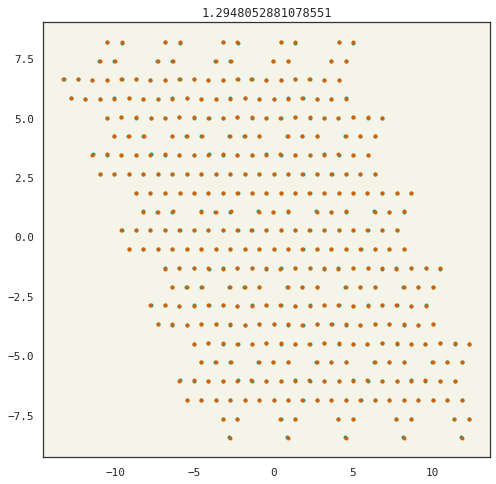

In [38]:
plt.figure(figsize=(8, 8))
plt.title(f'{nd}')
plt.plot(config[:,0], config[:,1], '.')
plt.plot(config2[:,0], config2[:,1], '.')

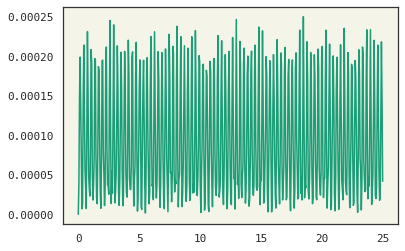

In [39]:
plt.plot(time, csm)

In [40]:
are you sure you want to run this?

from multiprocessing import Pool

cdf = None
results = []
trajs = {}

with Pool() as pool:
    for N in [8,16,32,128]:
        for i,t in enumerate(titles):
            W = len(symd.groups.load_group(i+1, 2)['specpos'])    
            for j in range(1 + W):
                wycks = None if j == 0 else [1] * j
                name = f'{t}-w{j}-n{N}'
                job = pool.apply_async(crystal, (N, i+1, wycks))
                #job = crystal(N, i+1, wycks)
                results.append((t, name, N, j, job))
                
    for r in results:        
        t, name, N, j, ar = r
        print('Getting result for ', name)
        res = ar.get()
        #res = ar
        if res is None:
            continue
        config, config2, nd, csm, traj, time = res
        T = len(csm)
        
        df2 = pd.DataFrame({'Group':[t] * T, 'Traj': [name] * T, 'rho': [nd] * T,
                            'N':[N] * T, 'Wyckoffs':[str(j)] * T, 'RMSD':csm, 'Time':time})
        if cdf is None:
            cdf = df2
        else:
            cdf = pd.concat((cdf, df2))
        trajs[name] = traj
        
cdf.reset_index(inplace=True)
cdf.to_pickle('atlas2d.pkl.gz')
with open('atlas2d.traj.pkl', 'wb') as f:
    pickle.dump(trajs, f, pickle.HIGHEST_PROTOCOL)

SimulatingSimulatingSimulatingSimulatingSimulatingSimulatingSimulatingSimulatingSimulating SimulatingSimulatingSimulating    SimulatingSimulatingSimulatingSimulating    4 8  568    7454 6 23   5423    particles: particles:  particles:particles:particles:    particles:particles:particles:particles: particles: particles:particles:  particles: particles:particles:particles:    2-4 1-8  2-6-22-8-42-5-12-7-3    3-5-14-43-4

3-6-25-26-3-1


6-5-36-4-26-25-3-1










Getting result for  p1-w0-n8
Simulating 6 particles: 6-6-4
Simulating 7 particles: 6-7-5
{"steps": 1000, "n_particles": 6, "time_step": 0.005, "seed": 435423, "anderson_nu": 100, "langevin_gamma": 10, "bussi_taut": 0.5, "thermostat_seed": 54344, "rcut": 10, "skin": 0.6000000000000001, "temperature": 0.01, "pressure": null, "box_update_period": 0, "start_temperature": 0.5, "thermostat": "baoab", "force_type": "lj", "final_positions": "crystal-6-6-4/group-6.dat", "cell_log_file": "crystal-6-6-4/cell_log_file.dat", "print_period"


Exiting due to high temperature or energy  (T = 3.70877e+29)

Simulating 8 particles: 6-8-6
Simulating 9 particles: 6-9-7
Simulating 10Simulating  particles:2 6-10-8 
particles: 7-2
Simulating 3 particles: 7-3-1
SimulatingSimulating  45  particles:particles:  7-4-27-5-3

Simulating 2 particles: 8-2
Simulating 3 particles: 8-3-1
Simulating 4 Simulating particles:2  8-4-2particles:
 9-2
Getting result for  p2-w0-n8
Getting result for  p2-w1-n8
Getting result for  p2-w2-n8
Getting result for  p2-w3-n8
Simulating 3 particles: 9-3-1
Simulating 4 particles: 9-4-2
Simulating 5 particles: Getting result for  p2-w4-n8
9-5-3
Simulating 6 particles: 9-6-4
Getting result for  pm-w0-n8
Getting result for  pm-w1-n8
Getting result for  pm-w2-n8
Getting result for  pg-w0-n8
Getting result for  cm-w0-n8
Getting result for  cm-w1-n8
Getting result for  pmm-w0-n8
Getting result for  pmm-w1-n8
Getting result for  pmm-w2-n8
Getting result for  pmm-w3-n8
Getting result for  pmm-w4-n8
{"steps": 1000000, "n_


Exiting due to high temperature or energy  (T = 1.86448e+47)

Simulating 7 particles: 9-7-5
{"steps": 1000000, "n_particles": 8, "time_step": 0.005, "seed": 435423, "anderson_nu": 100, "langevin_gamma": 0.1, "bussi_taut": 0.5, "thermostat_seed": 54344, "rcut": 10, "skin": 0.6000000000000001, "temperature": 0.1, "pressure": 0.25, "box_update_period": 5, "start_temperature": 0.1, "thermostat": "baoab", "force_type": "lj", "final_positions": "crystal-6-8-6/final_positions.dat", "cell_log_file": "crystal-6-8-6/cell_log_file.dat", "print_period": 10000.0, "cell": [4.72909, 0.0, 0.0, 2.9012], "lj_epsilon": 1, "lj_sigma": 1, "n_images": 2, "start_positions": "crystal-6-8-6/final_positions.dat", "group": "crystal-6-8-6/group-6.json", "wyckoffs": [{"group": "crystal-6-8-6/group-6-00.json", "n_particles": 1}, {"group": "crystal-6-8-6/group-6-01.json", "n_particles": 1}, {"group": "crystal-6-8-6/group-6-02.json", "n_particles": 1}, {"group": "crystal-6-8-6/group-6-03.json", "n_particles": 1}, {"

{"steps": 1000000, "n_particles": 3, "time_step": 0.005, "seed": 435423, "anderson_nu": 100, "langevin_gamma": 0.1, "bussi_taut": 0.5, "thermostat_seed": 54344, "rcut": 10, "skin": 0.6000000000000001, "temperature": 0.1, "pressure": 0.25, "box_update_period": 5, "start_temperature": 0.1, "thermostat": "baoab", "force_type": "lj", "final_positions": "crystal-9-3-1/final_positions.dat", "cell_log_file": "crystal-9-3-1/cell_log_file.dat", "print_period": 10000.0, "cell": [3.58879, 0.0, 0.0, 3.94476], "lj_epsilon": 1, "lj_sigma": 1, "n_images": 2, "start_positions": "crystal-9-3-1/final_positions.dat", "group": "crystal-9-3-1/group-9.json", "wyckoffs": [{"group": "crystal-9-3-1/group-9-00.json", "n_particles": 1}], "position_log_period": 10000, "positions_log_file": "crystal-9-3-1/positions.xyz"}
Info: You are running version cf97-dirty of symd
Assuming you'll pass parameters via stdin. Waiting...
Info: Loaded group group-9 with 2 particles and 8 members
Info: Loaded group group-9-0 with 1

{"steps": 5000, "n_particles": 12, "time_step": 0.005, "seed": 435423, "anderson_nu": 100, "langevin_gamma": 0.1, "bussi_taut": 0.5, "thermostat_seed": 54344, "rcut": 10, "skin": 0.6000000000000001, "temperature": 0, "pressure": null, "box_update_period": 0, "start_temperature": 0, "thermostat": null, "force_type": "lj", "final_positions": "melt-7-4-2/final_positions.dat", "cell_log_file": "melt-7-4-2/cell_log_file.dat", "print_period": 50.0, "cell": [3.99584, 0.0, 0.0, 1.8592], "lj_epsilon": 1, "lj_sigma": 1, "n_images": 2, "start_positions": "melt-7-4-2/final_positions.dat", "group": "melt-7-4-2/group-1.json", "position_log_period": 10, "positions_log_file": "melt-7-4-2/positions.xyz"}
Info: You are running version cf97-dirty of symd
Assuming you'll pass parameters via stdin. Waiting...
Info: Loaded group group-1 with 12 particles and 1 members
Info: Duplicating 12 particles into 12 real particles and 288 ghost for group with 1 elements and 24 tilings. Each cell has 12 particles.
Inf


Exiting due to high temperature or energy  (T = 2.98547e+28)

Simulating {"steps": 1000000, "n_particles": 3, "time_step": 0.005, "seed": 435423, "anderson_nu": 100, "langevin_gamma": 0.1, "bussi_taut": 0.5, "thermostat_seed": 54344, "rcut": 10, "skin": 0.6000000000000001, "temperature": 0.1, "pressure": 0.25, "box_update_period": 5, "start_temperature": 0.1, "thermostat": "baoab", "force_type": "lj", "final_positions": "crystal-9-3-1/final_positions.dat", "cell_log_file": "crystal-9-3-1/cell_log_file.dat", "print_period": 10000.0, "cell": [3.68894, 0.0, 0.0, 3.75308], "lj_epsilon": 1, "lj_sigma": 1, "n_images": 2, "start_positions": "crystal-9-3-1/final_positions.dat", "group": "crystal-9-3-1/group-9.json", "wyckoffs": [{"group": "crystal-9-3-1/group-9-00.json", "n_particles": 1}], "position_log_period": 10000, "positions_log_file": "crystal-9-3-1/positions.xyz"}Simulating4
 5Info: You are running version cf97-dirty of symd
Assuming you'll pass parameters via stdin. Waiting...
Info: 


Exiting due to high temperature or energy  (T = 3.94703e+26)

Simulating 5 particles: 11-5-3
Simulating 6 particles: 11-6-4
Getting result for  pmm-w6-n8
{"steps": 1000, "n_particles": 5, "time_step": 0.005, "seed": 435423, "anderson_nu": 100, "langevin_gamma": 10, "bussi_taut": 0.5, "thermostat_seed": 54344, "rcut": 10, "skin": 0.6000000000000001, "temperature": 0.01, "pressure": null, "box_update_period": 0, "start_temperature": 0.5, "thermostat": "baoab", "force_type": "lj", "final_positions": "crystal-11-5-3/group-11.dat", "cell_log_file": "crystal-11-5-3/cell_log_file.dat", "print_period": 10000.0, "cell": [5.91608, 0.0, 0.0, 5.91608], "lj_epsilon": 1, "lj_sigma": 1.0, "n_images": 2, "start_positions": "crystal-11-5-3/group-11.dat", "group": "crystal-11-5-3/group-11.json", "wyckoffs": [{"group": "crystal-11-5-3/group-11-00.json", "n_particles": 1}, {"group": "crystal-11-5-3/group-11-01.json", "n_particles": 1}, {"group": "crystal-11-5-3/group-11-02.json", "n_particles": 1}]}
Info

Info: You are running version cf97-dirty of symd
Assuming you'll pass parameters via stdin. Waiting...
Info: Loaded group group-11 with 2 particles and 8 members
Info: Loaded group group-11-0 with 1 particles and 4 members
Info: Loaded group group-11-1 with 1 particles and 4 members
Info: Loaded group group-11-2 with 1 particles and 4 members
Info: Loaded group group-11-3 with 1 particles and 2 members
Info: Duplicating 6 particles into 6 real particles and 744 ghost for group with 8 elements and 24 tilings. Each cell has 30 particles.
Info: Computed 8 degrees of freedom
        Step         Time            T           PE           KE            E       Htherm            V
           0            0  4.45441e+35       4.5589  1.78176e+36  1.78176e+36  1.78176e+36          150


Exiting due to high temperature or energy  (T = 4.45441e+35)
Exiting due to high temperature or energy  (T = 1.86747e+25)
{"steps": 1000, "n_particles": 5, "time_step": 0.005, "seed": 435423, "anderson_nu": 100, 

 
Exiting due to high temperature or energy  (T = 4.00117e+25)
11-8-6

{"steps": 5000, "n_particles": 16, "time_step": 0.005, "seed": 435423, "anderson_nu": 100, "langevin_gamma": 0.1, "bussi_taut": 0.5, "thermostat_seed": 54344, "rcut": 10, "skin": 0.6000000000000001, "temperature": 0, "pressure": null, "box_update_period": 0, "start_temperature": 0, "thermostat": null, "force_type": "lj", "final_positions": "melt-9-2/final_positions.dat", "cell_log_file": "melt-9-2/cell_log_file.dat", "print_period": 50.0, "cell": [2.61476, 0.0, 0.0, 5.229], "lj_epsilon": 1, "lj_sigma": 1, "n_images": 2, "start_positions": "melt-9-2/final_positions.dat", "group": "melt-9-2/group-1.json", "position_log_period": 10, "positions_log_file": "melt-9-2/positions.xyz"}
Info: You are running version cf97-dirty of symd
Assuming you'll pass parameters via stdin. Waiting...
Info: Loaded group group-1 with 16 particles and 1 members
Info: Duplicating 16 particles into 16 real particles and 384 ghost for group wit


Exiting due to high temperature or energy  (T = 6.76702e+34)

{"steps": 1000, "n_particles": 4, "time_step": 0.005, "seed": 435423, "anderson_nu": 100, "langevin_gamma": 10, "bussi_taut": 0.5, "thermostat_seed": 54344, "rcut": 10, "skin": 0.6000000000000001, "temperature": 0.01, "pressure": null, "box_update_period": 0, "start_temperature": 0.5, "thermostat": "baoab", "force_type": "lj", "final_positions": "crystal-12-4-2/group-12.dat", "cell_log_file": "crystal-12-4-2/cell_log_file.dat", "print_period": 10000.0, "cell": [5.24406, 0.0, 0.0, 5.24406], "lj_epsilon": 1, "lj_sigma": 1.0, "n_images": 2, "start_positions": "crystal-12-4-2/group-12.dat", "group": "crystal-12-4-2/group-12.json", "wyckoffs": [{"group": "crystal-12-4-2/group-12-00.json", "n_particles": 1}, {"group": "crystal-12-4-2/group-12-01.json", "n_particles": 1}]}
Info: You are running version cf97-dirty of symd
Assuming you'll pass parameters via stdin. Waiting...
Info: Loaded group group-12 with 2 particles and 8 member


Exiting due to high temperature or energy  (T = 4.30564e+27)

{"steps": 1000000, "n_particles": 4, "time_step": 0.005, "seed": 435423, "anderson_nu": 100, "langevin_gamma": 0.1, "bussi_taut": 0.5, "thermostat_seed": 54344, "rcut": 10, "skin": 0.6000000000000001, "temperature": 0.1, "pressure": 0.25, "box_update_period": 5, "start_temperature": 0.1, "thermostat": "baoab", "force_type": "lj", "final_positions": "crystal-10-4-2/final_positions.dat", "cell_log_file": "crystal-10-4-2/cell_log_file.dat", "print_period": 10000.0, "cell": [1.33194, 0.0, 0.0, 1.26771], "lj_epsilon": 1, "lj_sigma": 1, "n_images": 2, "start_positions": "crystal-10-4-2/final_positions.dat", "group": "crystal-10-4-2/group-10.json", "wyckoffs": [{"group": "crystal-10-4-2/group-10-00.json", "n_particles": 1}, {"group": "crystal-10-4-2/group-10-01.json", "n_particles": 1}], "position_log_period": 10000, "positions_log_file": "crystal-10-4-2/positions.xyz"}
{"steps": 1000000, "n_particles": 2, "time_step": 0.005, "see


Exiting due to high temperature or energy  (T = 9.16552e+25)


Info: You are running version cf97-dirty of symd
Assuming you'll pass parameters via stdin. Waiting...
Info: Loaded group group-11 with 2 particles and 8 members
Info: Duplicating 2 particles into 2 real particles and 398 ghost for group with 8 elements and 24 tilings. Each cell has 16 particles.
Info: Computed 4 degrees of freedom
        Step         Time            T           PE           KE            E       Htherm            V
           0            0     0.174106     -2.18617     0.348211     -1.83796     -1.83796      79.9394
       10000           50     0.184079     -2.61128     0.368157     -2.24312     -2.24312      75.8781
       20000          100     0.119682     -2.46231     0.239365     -2.22294     -2.22294      74.8028
       30000          150    0.0730907     -2.67608     0.146181      -2.5299      -2.5299      68.6169
       40000          200    0.0274051     -2.72456    0.0548103     -2.66975     


Exiting due to high temperature or energy  (T = 4.17396e+28)

{"steps": 1000000, "n_particles": 4, "time_step": 0.005, "seed": 435423, "anderson_nu": 100, "langevin_gamma": 0.1, "bussi_taut": 0.5, "thermostat_seed": 54344, "rcut": 10, "skin": 0.6000000000000001, "temperature": 0.1, "pressure": 0.25, "box_update_period": 5, "start_temperature": 0.1, "thermostat": "baoab", "force_type": "lj", "final_positions": "crystal-11-4-2/final_positions.dat", "cell_log_file": "crystal-11-4-2/cell_log_file.dat", "print_period": 10000.0, "cell": [2.04018, 0.0, 0.0, 2.06115], "lj_epsilon": 1, "lj_sigma": 1, "n_images": 2, "start_positions": "crystal-11-4-2/final_positions.dat", "group": "crystal-11-4-2/group-11.json", "wyckoffs": [{"group": "crystal-11-4-2/group-11-00.json", "n_particles": 1}, {"group": "crystal-11-4-2/group-11-01.json", "n_particles": 1}], "position_log_period": 10000, "positions_log_file": "crystal-11-4-2/positions.xyz"}
Info: You are running version cf97-dirty of symd
Assuming you

{"steps": 5000, "n_particles": 16, "time_step": 0.005, "seed": 435423, "anderson_nu": 100, "langevin_gamma": 0.1, "bussi_taut": 0.5, "thermostat_seed": 54344, "rcut": 10, "skin": 0.6000000000000001, "temperature": 0, "pressure": null, "box_update_period": 0, "start_temperature": 0, "thermostat": null, "force_type": "lj", "final_positions": "melt-11-2/final_positions.dat", "cell_log_file": "melt-11-2/cell_log_file.dat", "print_period": 50.0, "cell": [3.7988, 0.0, 0.0, 3.7988], "lj_epsilon": 1, "lj_sigma": 1, "n_images": 2, "start_positions": "melt-11-2/final_positions.dat", "group": "melt-11-2/group-1.json", "position_log_period": 10, "positions_log_file": "melt-11-2/positions.xyz"}
Info: You are running version cf97-dirty of symd
Assuming you'll pass parameters via stdin. Waiting...
Info: Loaded group group-1 with 16 particles and 1 members
Info: Duplicating 16 particles into 16 real particles and 384 ghost for group with 1 elements and 24 tilings. Each cell has 16 particles.
Info: Com


Exiting due to high temperature or energy  (T = 6.34e+30)

{"steps": 1000, "n_particles": 4, "time_step": 0.005, "seed": 435423, "anderson_nu": 100, "langevin_gamma": 10, "bussi_taut": 0.5, "thermostat_seed": 54344, "rcut": 10, "skin": 0.6000000000000001, "temperature": 0.01, "pressure": null, "box_update_period": 0, "start_temperature": 0.5, "thermostat": "baoab", "force_type": "lj", "final_positions": "crystal-11-4-2/group-11.dat", "cell_log_file": "crystal-11-4-2/cell_log_file.dat", "print_period": 10000.0, "cell": [5.47719, 0.0, 0.0, 5.47719], "lj_epsilon": 1, "lj_sigma": 1.0, "n_images": 2, "start_positions": "crystal-11-4-2/group-11.dat", "group": "crystal-11-4-2/group-11.json", "wyckoffs": [{"group": "crystal-11-4-2/group-11-00.json", "n_particles": 1}, {"group": "crystal-11-4-2/group-11-01.json", "n_particles": 1}]}
Info: You are running version cf97-dirty of symd
Assuming you'll pass parameters via stdin. Waiting...
Info: Loaded group group-11 with 2 particles and 8 members
I


Exiting due to high temperature or energy  (T = 5.43807e+28)

{"steps": 1000, "n_particles": 2, "time_step": 0.005, "seed": 435423, "anderson_nu": 100, "langevin_gamma": 10, "bussi_taut": 0.5, "thermostat_seed": 54344, "rcut": 10, "skin": 0.6000000000000001, "temperature": 0.01, "pressure": null, "box_update_period": 0, "start_temperature": 0.5, "thermostat": "baoab", "force_type": "lj", "final_positions": "crystal-15-2/group-15.dat", "cell_log_file": "crystal-15-2/cell_log_file.dat", "print_period": 10000.0, "cell": [4.16182, 0.0, 0.0, 4.16182], "lj_epsilon": 1, "lj_sigma": 1.0, "n_images": 2, "start_positions": "crystal-15-2/group-15.dat", "group": "crystal-15-2/group-15.json"}
Info: You are running version cf97-dirty of symd
Assuming you'll pass parameters via stdin. Waiting...
Info: Loaded group group-15 with 2 particles and 6 members
Info: Duplicating 2 particles into 2 real particles and 298 ghost for group with 6 elements and 24 tilings. Each cell has 12 particles.
Info: Comput


Exiting due to high temperature or energy  (T = 2.13479e+26)

Simulating 4 particles: 15-4-2
Simulating 5 particles: 15-5-3
Getting result for  pmm-w7-n8
Getting result for  pmm-w8-n8
Getting result for  pmg-w0-n8
Getting result for  pmg-w1-n8
Getting result for  pmg-w2-n8
Getting result for  pmg-w3-n8
Getting result for  pgg-w0-n8
Getting result for  pgg-w1-n8
Getting result for  pgg-w2-n8
Getting result for  cmm-w0-n8
Getting result for  cmm-w1-n8
Getting result for  cmm-w2-n8
Getting result for  cmm-w3-n8
Getting result for  cmm-w4-n8
Simulating 2 particles: 16-2
{"steps": 5000, "n_particles": 12, "time_step": 0.005, "seed": 435423, "anderson_nu": 100, "langevin_gamma": 0.1, "bussi_taut": 0.5, "thermostat_seed": 54344, "rcut": 10, "skin": 0.6000000000000001, "temperature": 0, "pressure": null, "box_update_period": 0, "start_temperature": 0, "thermostat": null, "force_type": "lj", "final_positions": "melt-14-2/final_positions.dat", "cell_log_file": "melt-14-2/cell_log_file.dat", "pr


Exiting due to high temperature or energy  (T = 9.43167e+27)

Simulating 3 particles: 16-3-1
{"steps": 1000, "n_particles": 3, "time_step": 0.005, "seed": 435423, "anderson_nu": 100, "langevin_gamma": 10, "bussi_taut": 0.5, "thermostat_seed": 54344, "rcut": 10, "skin": 0.6000000000000001, "temperature": 0.01, "pressure": null, "box_update_period": 0, "start_temperature": 0.5, "thermostat": "baoab", "force_type": "lj", "final_positions": "crystal-16-3-1/group-16.dat", "cell_log_file": "crystal-16-3-1/cell_log_file.dat", "print_period": 10000.0, "cell": [4.65303, 0.0, 0.0, 4.65303], "lj_epsilon": 1, "lj_sigma": 1.0, "n_images": 2, "start_positions": "crystal-16-3-1/group-16.dat", "group": "crystal-16-3-1/group-16.json", "wyckoffs": [{"group": "crystal-16-3-1/group-16-00.json", "n_particles": 1}]}
Info: You are running version cf97-dirty of symd
Assuming you'll pass parameters via stdin. Waiting...
Info: Loaded group group-16 with 2 particles and 6 members
Info: Loaded group group-16-0 w


Exiting due to high temperature or energy  (T = 6.9264e+35)


Exiting due to high temperature or energy  (T = 2.90294e+27)

{"steps": 1000, "n_particles": 4, "time_step": 0.005, "seed": 435423, "anderson_nu": 100, "langevin_gamma": 10, "bussi_taut": 0.5, "thermostat_seed": 54344, "rcut": 10, "skin": 0.6000000000000001, "temperature": 0.01, "pressure": null, "box_update_period": 0, "start_temperature": 0.5, "thermostat": "baoab", "force_type": "lj", "final_positions": "crystal-14-4-2/group-14.dat", "cell_log_file": "crystal-14-4-2/cell_log_file.dat", "print_period": 10000.0, "cell": [4.80565, 0.0, 0.0, 4.80565], "lj_epsilon": 1, "lj_sigma": 1.0, "n_images": 2, "start_positions": "crystal-14-4-2/group-14.dat", "group": "crystal-14-4-2/group-14.json", "wyckoffs": [{"group": "crystal-14-4-2/group-14-00.json", "n_particles": 1}, {"group": "crystal-14-4-2/group-14-01.json", "n_particles": 1}]}{"steps": 1000000, "n_particles": 7, "time_step": 0.005, "seed": 435423, "anderson_nu": 100, "lange

{"steps": 100000, "n_particles": 7, "time_step": 0.005, "seed": 435423, "anderson_nu": 100, "langevin_gamma": 0.1, "bussi_taut": 0.5, "thermostat_seed": 54344, "rcut": 10, "skin": 0.6000000000000001, "temperature": 0.05, "pressure": 0.25, "box_update_period": 0, "start_temperature": 0.1, "thermostat": "baoab", "force_type": "lj", "final_positions": "crystal-11-7-5/final_positions.dat", "cell_log_file": "crystal-11-7-5/cell_log_file.dat", "print_period": 10000.0, "cell": [2.17567, 0.0, 0.0, 2.48589], "lj_epsilon": 1, "lj_sigma": 1, "n_images": 2, "start_positions": "crystal-11-7-5/final_positions.dat", "group": "crystal-11-7-5/group-11.json", "wyckoffs": [{"group": "crystal-11-7-5/group-11-00.json", "n_particles": 1}, {"group": "crystal-11-7-5/group-11-01.json", "n_particles": 1}, {"group": "crystal-11-7-5/group-11-02.json", "n_particles": 1}, {"group": "crystal-11-7-5/group-11-03.json", "n_particles": 1}, {"group": "crystal-11-7-5/group-11-04.json", "n_particles": 1}], "position_log_pe


Exiting due to high temperature or energy  (T = 1.13631e+26)

16-5-317-3-1{"steps": 1000, "n_particles": 2, "time_step": 0.005, "seed": 435423, "anderson_nu": 100, "langevin_gamma": 10, "bussi_taut": 0.5, "thermostat_seed": 54344, "rcut": 10, "skin": 0.6000000000000001, "temperature": 0.01, "pressure": null, "box_update_period": 0, "start_temperature": 0.5, "thermostat": "baoab", "force_type": "lj", "final_positions": "crystal-17-2/group-17.dat", "cell_log_file": "crystal-17-2/cell_log_file.dat", "print_period": 10000.0, "cell": [5.88566, 0.0, 0.0, 5.88566], "lj_epsilon": 1, "lj_sigma": 1.0, "n_images": 2, "start_positions": "crystal-17-2/group-17.dat", "group": "crystal-17-2/group-17.json"}

Info: You are running version cf97-dirty of symd
Assuming you'll pass parameters via stdin. Waiting...
Info: Loaded group group-17 with 2 particles and 12 members
Info: Duplicating 2 particles into 2 real particles and 598 ghost for group with 12 elements and 24 tilings. Each cell has 24 particle


Exiting due to high temperature or energy  (T = 7.24036e+36)

{"steps": 1000, "n_particles": 3, "time_step": 0.005, "seed": 435423, "anderson_nu": 100, "langevin_gamma": 10, "bussi_taut": 0.5, "thermostat_seed": 54344, "rcut": 10, "skin": 0.6000000000000001, "temperature": 0.01, "pressure": null, "box_update_period": 0, "start_temperature": 0.5, "thermostat": "baoab", "force_type": "lj", "final_positions": "crystal-17-3-1/group-17.dat", "cell_log_file": "crystal-17-3-1/cell_log_file.dat", "print_period": 10000.0, "cell": [6.58037, 0.0, 0.0, 6.58037], "lj_epsilon": 1, "lj_sigma": 1.0, "n_images": 2, "start_positions": "crystal-17-3-1/group-17.dat", "group": "crystal-17-3-1/group-17.json", "wyckoffs": [{"group": "crystal-17-3-1/group-17-00.json", "n_particles": 1}]}
Info: You are running version cf97-dirty of symd
Assuming you'll pass parameters via stdin. Waiting...
Info: Loaded group group-17 with 2 particles and 12 members
Info: Loaded group group-17-0 with 1 particles and 6 members


{"steps": 1000, "n_particles": 6, "time_step": 0.005, "seed": 435423, "anderson_nu": 100, "langevin_gamma": 10, "bussi_taut": 0.5, "thermostat_seed": 54344, "rcut": 10, "skin": 0.6000000000000001, "temperature": 0.01, "pressure": null, "box_update_period": 0, "start_temperature": 0.5, "thermostat": "baoab", "force_type": "lj", "final_positions": "crystal-14-6-4/group-14.dat", "cell_log_file": "crystal-14-6-4/cell_log_file.dat", "print_period": 10000.0, "cell": [5.09714, 0.0, 0.0, 5.09714], "lj_epsilon": 1, "lj_sigma": 1.0, "n_images": 2, "start_positions": "crystal-14-6-4/group-14.dat", "group": "crystal-14-6-4/group-14.json", "wyckoffs": [{"group": "crystal-14-6-4/group-14-00.json", "n_particles": 1}, {"group": "crystal-14-6-4/group-14-01.json", "n_particles": 1}, {"group": "crystal-14-6-4/group-14-02.json", "n_particles": 1}, {"group": "crystal-14-6-4/group-14-03.json", "n_particles": 1}]}Info: You are running version cf97-dirty of symd
Assuming you'll pass parameters via stdin. Wait


{"steps": 1000000, "n_particles": 3, "time_step": 0.005, "seed": 435423, "anderson_nu": 100, "langevin_gamma": 0.1, "bussi_taut": 0.5, "thermostat_seed": 54344, "rcut": 10, "skin": 0.6000000000000001, "temperature": 0.1, "pressure": 0.25, "box_update_period": 5, "start_temperature": 0.1, "thermostat": "baoab", "force_type": "lj", "final_positions": "crystal-15-3-1/final_positions.dat", "cell_log_file": "crystal-15-3-1/cell_log_file.dat", "print_period": 10000.0, "cell": [1.46864, 0.0, 0.0, 1.93466], "lj_epsilon": 1, "lj_sigma": 1, "n_images": 2, "start_positions": "crystal-15-3-1/final_positions.dat", "group": "crystal-15-3-1/group-15.json", "wyckoffs": [{"group": "crystal-15-3-1/group-15-00.json", "n_particles": 1}], "position_log_period": 10000, "positions_log_file": "crystal-15-3-1/positions.xyz"}Exiting due to high temperature or energy  (T = 1.60375e+27)


Info: You are running version cf97-dirty of symd
Assuming you'll pass parameters via stdin. Waiting...
Info: Loaded group gro



Exiting due to high temperature or energy  (T = 1.80371e+26)

{"steps": 1000, "n_particles": 16, "time_step": 0.005, "seed": 435423, "anderson_nu": 100, "langevin_gamma": 10, "bussi_taut": 0.5, "thermostat_seed": 54344, "rcut": 10, "skin": 0.6000000000000001, "temperature": 0.01, "pressure": null, "box_update_period": 0, "start_temperature": 0.5, "thermostat": "baoab", "force_type": "lj", "final_positions": "crystal-1-16/group-1.dat", "cell_log_file": "crystal-1-16/cell_log_file.dat", "print_period": 10000.0, "cell": [8.94432, 0.0, 0.0, 8.94432], "lj_epsilon": 1, "lj_sigma": 1.0, "n_images": 2, "start_positions": "crystal-1-16/group-1.dat", "group": "crystal-1-16/group-1.json"}
Info: You are running version cf97-dirty of symd
Assuming you'll pass parameters via stdin. Waiting...
Info: Loaded group group-1 with 16 particles and 1 members
Info: Duplicating 16 particles into 16 real particles and 384 ghost for group with 1 elements and 24 tilings. Each cell has 16 particles.
Info: Compu

 
particles:Exiting due to high temperature or energy  (T = 1.62896e+27)
 
2-11-3
{"steps": 5000, "n_particles": 17, "time_step": 0.005, "seed": 435423, "anderson_nu": 100, "langevin_gamma": 0.1, "bussi_taut": 0.5, "thermostat_seed": 54344, "rcut": 10, "skin": 0.6000000000000001, "temperature": 0, "pressure": null, "box_update_period": 0, "start_temperature": 0, "thermostat": null, "force_type": "lj", "final_positions": "melt-16-4-2/final_positions.dat", "cell_log_file": "melt-16-4-2/cell_log_file.dat", "print_period": 50.0, "cell": [3.61218, -1.80609, 0.0, 3.12824], "lj_epsilon": 1, "lj_sigma": 1, "n_images": 2, "start_positions": "melt-16-4-2/final_positions.dat", "group": "melt-16-4-2/group-1.json", "position_log_period": 10, "positions_log_file": "melt-16-4-2/positions.xyz"}
Info: You are running version cf97-dirty of symd
Assuming you'll pass parameters via stdin. Waiting...
Info: Loaded group group-1 with 17 particles and 1 members
Info: Duplicating 17 particles into 17 real part

Info: You are running version cf97-dirty of symd
Assuming you'll pass parameters via stdin. Waiting...
Info: Loaded group group-17 with 2 particles and 12 members
Info: Loaded group group-17-0 with 1 particles and 6 members
Info: Loaded group group-17-1 with 1 particles and 6 members
Info: Loaded group group-17-2 with 1 particles and 3 members
Info: Loaded group group-17-3 with 1 particles and 2 members
Info: Duplicating 6 particles into 6 real particles and 1019 ghost for group with 12 elements and 24 tilings. Each cell has 41 particles.
Info: Computed 8 degrees of freedom
        Step         Time            T           PE           KE            E       Htherm            V
           0            0    0.0974317     -5.08117     0.389727     -4.69145     -4.69145      204.893
       10000           50    0.0801227     -8.10474     0.320491     -7.78425     -7.78425       174.54
       20000          100     0.217859     -7.94263     0.871436      -7.0712      -7.0712      150.693
   


Exiting due to high temperature or energy  (T = 7.03792e+30)

Simulating 12 particles: 2-12-4
Simulating 8 particles: 3-8
{"steps": 5000, "n_particles": 15, "time_step": 0.005, "seed": 435423, "anderson_nu": 100, "langevin_gamma": 0.1, "bussi_taut": 0.5, "thermostat_seed": 54344, "rcut": 10, "skin": 0.6000000000000001, "temperature": 0, "pressure": null, "box_update_period": 0, "start_temperature": 0, "thermostat": null, "force_type": "lj", "final_positions": "melt-15-3-1/final_positions.dat", "cell_log_file": "melt-15-3-1/cell_log_file.dat", "print_period": 50.0, "cell": [3.41856, -1.70928, 0.0, 2.96056], "lj_epsilon": 1, "lj_sigma": 1, "n_images": 2, "start_positions": "melt-15-3-1/final_positions.dat", "group": "melt-15-3-1/group-1.json", "position_log_period": 10, "positions_log_file": "melt-15-3-1/positions.xyz"}
Info: You are running version cf97-dirty of symd
Assuming you'll pass parameters via stdin. Waiting...
Info: Loaded group group-1 with 15 particles and 1 members
Info: D

{"steps": 5000, "n_particles": 18, "time_step": 0.005, "seed": 435423, "anderson_nu": 100, "langevin_gamma": 0.1, "bussi_taut": 0.5, "thermostat_seed": 54344, "rcut": 10, "skin": 0.6000000000000001, "temperature": 0, "pressure": null, "box_update_period": 0, "start_temperature": 0, "thermostat": null, "force_type": "lj", "final_positions": "melt-16-5-3/final_positions.dat", "cell_log_file": "melt-16-5-3/cell_log_file.dat", "print_period": 50.0, "cell": [3.57368, -1.78684, 0.0, 3.0949], "lj_epsilon": 1, "lj_sigma": 1, "n_images": 2, "start_positions": "melt-16-5-3/final_positions.dat", "group": "melt-16-5-3/group-1.json", "position_log_period": 10, "positions_log_file": "melt-16-5-3/positions.xyz"} 

Exiting due to high temperature or energy  (T = 4.10276e+27)

3-9-1Info: You are running version cf97-dirty of symd
Assuming you'll pass parameters via stdin. Waiting...
Info: Loaded group group-1 with 18 particles and 1 members
Info: Duplicating 18 particles into 18 real particles and 432 

Info: You are running version cf97-dirty of symd
Assuming you'll pass parameters via stdin. Waiting...
Info: Loaded group group-1 with 41 particles and 1 members
Info: Duplicating 41 particles into 41 real particles and 984 ghost for group with 1 elements and 24 tilings. Each cell has 41 particles.
Info: Computed 82 degrees of freedom
        Step         Time            T           PE           KE            E       Htherm            V
           0            0    0.0105513      2398.15     0.432602      2398.58      2398.58      29.6639
          50         0.25     0.963131      2359.65      39.4884      2399.14      2399.14      29.6639
         100          0.5      20.0953      1839.41      823.908      2663.32      2663.32      29.6639
         150         0.75      29.6366      1532.18       1215.1      2747.28      2747.28      29.6639
         200            1      25.3836      1649.65      1040.73      2690.38      2690.38      29.6639
         250         1.25      26.2579 


Exiting due to high temperature or energy  (T = 5.74169e+31)

{"steps": 1000000, "n_particles": 7, "time_step": 0.005, "seed": 435423, "anderson_nu": 100, "langevin_gamma": 0.1, "bussi_taut": 0.5, "thermostat_seed": 54344, "rcut": 10, "skin": 0.6000000000000001, "temperature": 0.1, "pressure": 0.25, "box_update_period": 5, "start_temperature": 0.1, "thermostat": "baoab", "force_type": "lj", "final_positions": "crystal-17-7-5/final_positions.dat", "cell_log_file": "crystal-17-7-5/cell_log_file.dat", "print_period": 10000.0, "cell": [2.72661, 0.0, 0.0, 2.98266], "lj_epsilon": 1, "lj_sigma": 1, "n_images": 2, "start_positions": "crystal-17-7-5/final_positions.dat", "group": "crystal-17-7-5/group-17.json", "wyckoffs": [{"group": "crystal-17-7-5/group-17-00.json", "n_particles": 1}, {"group": "crystal-17-7-5/group-17-01.json", "n_particles": 1}, {"group": "crystal-17-7-5/group-17-02.json", "n_particles": 1}, {"group": "crystal-17-7-5/group-17-03.json", "n_particles": 1}, {"group": "crystal

{"steps": 5000, "n_particles": 42, "time_step": 0.005, "seed": 435423, "anderson_nu": 100, "langevin_gamma": 0.1, "bussi_taut": 0.5, "thermostat_seed": 54344, "rcut": 10, "skin": 0.6000000000000001, "temperature": 0, "pressure": null, "box_update_period": 0, "start_temperature": 0, "thermostat": null, "force_type": "lj", "final_positions": "melt-17-7-5/final_positions.dat", "cell_log_file": "melt-17-7-5/cell_log_file.dat", "print_period": 50.0, "cell": [5.70927, -2.85464, 0.0, 4.94437], "lj_epsilon": 1, "lj_sigma": 1, "n_images": 2, "start_positions": "melt-17-7-5/final_positions.dat", "group": "melt-17-7-5/group-1.json", "position_log_period": 10, "positions_log_file": "melt-17-7-5/positions.xyz"}
Info: You are running version cf97-dirty of symd
Assuming you'll pass parameters via stdin. Waiting...
Info: Loaded group group-1 with 42 particles and 1 members
Info: Duplicating 42 particles into 42 real particles and 1008 ghost for group with 1 elements and 24 tilings. Each cell has 42 pa


Exiting due to high temperature or energy  (T = 6.24087e+31)

{"steps": 1000, "n_particles": 7, "time_step": 0.005, "seed": 435423, "anderson_nu": 100, "langevin_gamma": 10, "bussi_taut": 0.5, "thermostat_seed": 54344, "rcut": 10, "skin": 0.6000000000000001, "temperature": 0.01, "pressure": null, "box_update_period": 0, "start_temperature": 0.5, "thermostat": "baoab", "force_type": "lj", "final_positions": "crystal-6-7-3/group-6.dat", "cell_log_file": "crystal-6-7-3/cell_log_file.dat", "print_period": 10000.0, "cell": [10.4881, 0.0, 0.0, 10.4881], "lj_epsilon": 1, "lj_sigma": 1.0, "n_images": 2, "start_positions": "crystal-6-7-3/group-6.dat", "group": "crystal-6-7-3/group-6.json", "wyckoffs": [{"group": "crystal-6-7-3/group-6-00.json", "n_particles": 1}, {"group": "crystal-6-7-3/group-6-01.json", "n_particles": 1}, {"group": "crystal-6-7-3/group-6-02.json", "n_particles": 1}]}
Info: You are running version cf97-dirty of symd
Assuming you'll pass parameters via stdin. Waiting...
Info: 


Exiting due to high temperature or energy  (T = 4.2083e+27)

Simulating 6Getting result for  p2-w4-n16
 particles: 7-6-2
{"steps": 5000, "n_particles": 16, "time_step": 0.005, "seed": 435423, "anderson_nu": 100, "langevin_gamma": 0.1, "bussi_taut": 0.5, "thermostat_seed": 54344, "rcut": 10, "skin": 0.6000000000000001, "temperature": 0, "pressure": null, "box_update_period": 0, "start_temperature": 0, "thermostat": null, "force_type": "lj", "final_positions": "melt-4-8/final_positions.dat", "cell_log_file": "melt-4-8/cell_log_file.dat", "print_period": 50.0, "cell": [2.98977, 0.0, 0.0, 3.4226], "lj_epsilon": 1, "lj_sigma": 1, "n_images": 2, "start_positions": "melt-4-8/final_positions.dat", "group": "melt-4-8/group-1.json", "position_log_period": 10, "positions_log_file": "melt-4-8/positions.xyz"}
Info: You are running version cf97-dirty of symd
Assuming you'll pass parameters via stdin. Waiting...
Info: Loaded group group-1 with 16 particles and 1 members
Info: Duplicating 16 particle

{"steps": 5000, "n_particles": 20, "time_step": 0.005, "seed": 435423, "anderson_nu": 100, "langevin_gamma": 0.1, "bussi_taut": 0.5, "thermostat_seed": 54344, "rcut": 10, "skin": 0.6000000000000001, "temperature": 0, "pressure": null, "box_update_period": 0, "start_temperature": 0, "thermostat": null, "force_type": "lj", "final_positions": "melt-6-6-2/final_positions.dat", "cell_log_file": "melt-6-6-2/cell_log_file.dat", "print_period": 50.0, "cell": [3.11806, 0.0, 0.0, 4.48301], "lj_epsilon": 1, "lj_sigma": 1, "n_images": 2, "start_positions": "melt-6-6-2/final_positions.dat", "group": "melt-6-6-2/group-1.json", "position_log_period": 10, "positions_log_file": "melt-6-6-2/positions.xyz"}
Info: You are running version cf97-dirty of symd
Assuming you'll pass parameters via stdin. Waiting...
Info: Loaded group group-1 with 20 particles and 1 members
Info: Duplicating 20 particles into 20 real particles and 480 ghost for group with 1 elements and 24 tilings. Each cell has 20 particles.
In


Exiting due to high temperature or energy  (T = 1.90889e+25)

Simulating 2 particles: 9-2
{"steps": 5000, "n_particles": 18, "time_step": 0.005, "seed": 435423, "anderson_nu": 100, "langevin_gamma": 0.1, "bussi_taut": 0.5, "thermostat_seed": 54344, "rcut": 10, "skin": 0.6000000000000001, "temperature": 0, "pressure": null, "box_update_period": 0, "start_temperature": 0, "thermostat": null, "force_type": "lj", "final_positions": "melt-6-5-1/final_positions.dat", "cell_log_file": "melt-6-5-1/cell_log_file.dat", "print_period": 50.0, "cell": [1.54417, 0.0, 0.0, 9.98554], "lj_epsilon": 1, "lj_sigma": 1, "n_images": 2, "start_positions": "melt-6-5-1/final_positions.dat", "group": "melt-6-5-1/group-1.json", "position_log_period": 10, "positions_log_file": "melt-6-5-1/positions.xyz"}
Info: You are running version cf97-dirty of symd
Assuming you'll pass parameters via stdin. Waiting...
Info: Loaded group group-1 with 18 particles and 1 members
Info: Duplicating 18 particles into 18 real parti


Exiting due to high temperature or energy  (T = 1.21804e+35)

{"steps": 5000, "n_particles": 16, "time_step": 0.005, "seed": 435423, "anderson_nu": 100, "langevin_gamma": 0.1, "bussi_taut": 0.5, "thermostat_seed": 54344, "rcut": 10, "skin": 0.6000000000000001, "temperature": 0, "pressure": null, "box_update_period": 0, "start_temperature": 0, "thermostat": null, "force_type": "lj", "final_positions": "melt-9-2/final_positions.dat", "cell_log_file": "melt-9-2/cell_log_file.dat", "print_period": 50.0, "cell": [2.8228, 0.0, 0.0, 4.85204], "lj_epsilon": 1, "lj_sigma": 1, "n_images": 2, "start_positions": "melt-9-2/final_positions.dat", "group": "melt-9-2/group-1.json", "position_log_period": 10, "positions_log_file": "melt-9-2/positions.xyz"}
Info: You are running version cf97-dirty of symd
Assuming you'll pass parameters via stdin. Waiting...
Info: Loaded group group-1 with 16 particles and 1 members
Info: Duplicating 16 particles into 16 real particles and 384 ghost for group with 1 ele


Exiting due to high temperature or energy  (T = 2.08311e+42)

Simulating 5 particles: 10-5-1
Simulating 6 particles: 10-6-2
{"steps": 1000000, "n_particles": 2, "time_step": 0.005, "seed": 435423, "anderson_nu": 100, "langevin_gamma": 0.1, "bussi_taut": 0.5, "thermostat_seed": 54344, "rcut": 10, "skin": 0.6000000000000001, "temperature": 0.1, "pressure": 0.25, "box_update_period": 5, "start_temperature": 0.1, "thermostat": "baoab", "force_type": "lj", "final_positions": "crystal-9-2/final_positions.dat", "cell_log_file": "crystal-9-2/cell_log_file.dat", "print_period": 10000.0, "cell": [2.6916, 0.0, 0.0, 5.07241], "lj_epsilon": 1, "lj_sigma": 1, "n_images": 2, "start_positions": "crystal-9-2/final_positions.dat", "group": "crystal-9-2/group-9.json", "position_log_period": 10000, "positions_log_file": "crystal-9-2/positions.xyz"}
Info: You are running version cf97-dirty of symd
Assuming you'll pass parameters via stdin. Waiting...
Info: Loaded group group-9 with 2 particles and 8 membe


Exiting due to high temperature or energy  (T = 1.53153e+28)

{"steps": 5000, "n_particles": 24, "time_step": 0.005, "seed": 435423, "anderson_nu": 100, "langevin_gamma": 0.1, "bussi_taut": 0.5, "thermostat_seed": 54344, "rcut": 10, "skin": 0.6000000000000001, "temperature": 0, "pressure": null, "box_update_period": 0, "start_temperature": 0, "thermostat": null, "force_type": "lj", "final_positions": "melt-9-4-2/final_positions.dat", "cell_log_file": "melt-9-4-2/cell_log_file.dat", "print_period": 50.0, "cell": [3.88977, 0.0, 0.0, 4.1543], "lj_epsilon": 1, "lj_sigma": 1, "n_images": 2, "start_positions": "melt-9-4-2/final_positions.dat", "group": "melt-9-4-2/group-1.json", "position_log_period": 10, "positions_log_file": "melt-9-4-2/positions.xyz"}
Info: You are running version cf97-dirty of symd
Assuming you'll pass parameters via stdin. Waiting...
Info: Loaded group group-1 with 24 particles and 1 members
Info: Duplicating 24 particles into 24 real particles and 576 ghost for group 

particles:
 Exiting due to high temperature or energy  (T = 7.21033e+26)
11-5-3

{"steps": 1000, "n_particles": 5, "time_step": 0.005, "seed": 435423, "anderson_nu": 100, "langevin_gamma": 10, "bussi_taut": 0.5, "thermostat_seed": 54344, "rcut": 10, "skin": 0.6000000000000001, "temperature": 0.01, "pressure": null, "box_update_period": 0, "start_temperature": 0.5, "thermostat": "baoab", "force_type": "lj", "final_positions": "crystal-11-5-3/group-11.dat", "cell_log_file": "crystal-11-5-3/cell_log_file.dat", "print_period": 10000.0, "cell": [5.91608, 0.0, 0.0, 5.91608], "lj_epsilon": 1, "lj_sigma": 1.0, "n_images": 2, "start_positions": "crystal-11-5-3/group-11.dat", "group": "crystal-11-5-3/group-11.json", "wyckoffs": [{"group": "crystal-11-5-3/group-11-00.json", "n_particles": 1}, {"group": "crystal-11-5-3/group-11-01.json", "n_particles": 1}, {"group": "crystal-11-5-3/group-11-02.json", "n_particles": 1}]}
Info: You are running version cf97-dirty of symd
Assuming you'll pass paramete



Exiting due to high temperature or energy  (T = 2.18374e+51)

Simulating 7 particles: 11-7-5
Getting result for  cm-w0-n16
Getting result for  cm-w1-n16
Getting result for  pmm-w0-n16
Getting result for  pmm-w1-n16
Getting result for  pmm-w2-n16
Getting result for  pmm-w3-n16
Getting result for  pmm-w4-n16
Getting result for  pmm-w5-n16
Getting result for  pmm-w6-n16
{"steps": 5000, "n_particles": 22, "time_step": 0.005, "seed": 435423, "anderson_nu": 100, "langevin_gamma": 0.1, "bussi_taut": 0.5, "thermostat_seed": 54344, "rcut": 10, "skin": 0.6000000000000001, "temperature": 0, "pressure": null, "box_update_period": 0, "start_temperature": 0, "thermostat": null, "force_type": "lj", "final_positions": "melt-7-7-3/final_positions.dat", "cell_log_file": "melt-7-7-3/cell_log_file.dat", "print_period": 50.0, "cell": [9.73392, 0.0, 0.0, 1.33677], "lj_epsilon": 1, "lj_sigma": 1, "n_images": 2, "start_positions": "melt-7-7-3/final_positions.dat", "group": "melt-7-7-3/group-1.json", "positi


Exiting due to high temperature or energy  (T = 2.07376e+33)

{"steps": 5000, "n_particles": 16, "time_step": 0.005, "seed": 435423, "anderson_nu": 100, "langevin_gamma": 0.1, "bussi_taut": 0.5, "thermostat_seed": 54344, "rcut": 10, "skin": 0.6000000000000001, "temperature": 0, "pressure": null, "box_update_period": 0, "start_temperature": 0, "thermostat": null, "force_type": "lj", "final_positions": "melt-11-2/final_positions.dat", "cell_log_file": "melt-11-2/cell_log_file.dat", "print_period": 50.0, "cell": [3.78797, 0.0, 0.0, 3.78797], "lj_epsilon": 1, "lj_sigma": 1, "n_images": 2, "start_positions": "melt-11-2/final_positions.dat", "group": "melt-11-2/group-1.json", "position_log_period": 10, "positions_log_file": "melt-11-2/positions.xyz"}
Info: You are running version cf97-dirty of symd
Assuming you'll pass parameters via stdin. Waiting...
Info: Loaded group group-1 with 16 particles and 1 members
Info: Duplicating 16 particles into 16 real particles and 384 ghost for group with


Exiting due to high temperature or energy  (T = 1.36391e+28)

{"steps": 1000000, "n_particles": 6, "time_step": 0.005, "seed": 435423, "anderson_nu": 100, "langevin_gamma": 0.1, "bussi_taut": 0.5, "thermostat_seed": 54344, "rcut": 10, "skin": 0.6000000000000001, "temperature": 0.1, "pressure": 0.25, "box_update_period": 5, "start_temperature": 0.1, "thermostat": "baoab", "force_type": "lj", "final_positions": "crystal-11-6-4/final_positions.dat", "cell_log_file": "crystal-11-6-4/cell_log_file.dat", "print_period": 10000.0, "cell": [2.33487, 0.0, 0.0, 2.0295], "lj_epsilon": 1, "lj_sigma": 1, "n_images": 2, "start_positions": "crystal-11-6-4/final_positions.dat", "group": "crystal-11-6-4/group-11.json", "wyckoffs": [{"group": "crystal-11-6-4/group-11-00.json", "n_particles": 1}, {"group": "crystal-11-6-4/group-11-01.json", "n_particles": 1}, {"group": "crystal-11-6-4/group-11-02.json", "n_particles": 1}, {"group": "crystal-11-6-4/group-11-03.json", "n_particles": 1}], "position_log_peri


Exiting due to high temperature or energy  (T = 2.82041e+33)

Simulating 5 particles:{"steps": 1000, "n_particles": 4, "time_step": 0.005, "seed": 435423, "anderson_nu": 100, "langevin_gamma": 10, "bussi_taut": 0.5, "thermostat_seed": 54344, "rcut": 10, "skin": 0.6000000000000001, "temperature": 0.01, "pressure": null, "box_update_period": 0, "start_temperature": 0.5, "thermostat": "baoab", "force_type": "lj", "final_positions": "crystal-12-4-2/group-12.dat", "cell_log_file": "crystal-12-4-2/cell_log_file.dat", "print_period": 10000.0, "cell": [5.24406, 0.0, 0.0, 5.24406], "lj_epsilon": 1, "lj_sigma": 1.0, "n_images": 2, "start_positions": "crystal-12-4-2/group-12.dat", "group": "crystal-12-4-2/group-12.json", "wyckoffs": [{"group": "crystal-12-4-2/group-12-00.json", "n_particles": 1}, {"group": "crystal-12-4-2/group-12-01.json", "n_particles": 1}]} 
Info: You are running version cf97-dirty of symd
Assuming you'll pass parameters via stdin. Waiting...
Info: Loaded group group-12 with 


Exiting due to high temperature or energy  (T = 7.99551e+26)

{"steps": 5000, "n_particles": 30, "time_step": 0.005, "seed": 435423, "anderson_nu": 100, "langevin_gamma": 0.1, "bussi_taut": 0.5, "thermostat_seed": 54344, "rcut": 10, "skin": 0.6000000000000001, "temperature": 0, "pressure": null, "box_update_period": 0, "start_temperature": 0, "thermostat": null, "force_type": "lj", "final_positions": "melt-11-6-4/final_positions.dat", "cell_log_file": "melt-11-6-4/cell_log_file.dat", "print_period": 50.0, "cell": [4.36437, 0.0, 0.0, 4.36437], "lj_epsilon": 1, "lj_sigma": 1, "n_images": 2, "start_positions": "melt-11-6-4/final_positions.dat", "group": "melt-11-6-4/group-1.json", "position_log_period": 10, "positions_log_file": "melt-11-6-4/positions.xyz"}
Info: You are running version cf97-dirty of symd
Assuming you'll pass parameters via stdin. Waiting...
Info: Loaded group group-1 with 30 particles and 1 members
Info: Duplicating 30 particles into 30 real particles and 720 ghost for 


Exiting due to high temperature or energy  (T = 5.08662e+32)
{"steps": 1000, "n_particles": 4, "time_step": 0.005, "seed": 435423, "anderson_nu": 100, "langevin_gamma": 10, "bussi_taut": 0.5, "thermostat_seed": 54344, "rcut": 10, "skin": 0.6000000000000001, "temperature": 0.01, "pressure": null, "box_update_period": 0, "start_temperature": 0.5, "thermostat": "baoab", "force_type": "lj", "final_positions": "crystal-12-4-2/group-12.dat", "cell_log_file": "crystal-12-4-2/cell_log_file.dat", "print_period": 10000.0, "cell": [5.24406, 0.0, 0.0, 5.24406], "lj_epsilon": 1, "lj_sigma": 1.0, "n_images": 2, "start_positions": "crystal-12-4-2/group-12.dat", "group": "crystal-12-4-2/group-12.json", "wyckoffs": [{"group": "crystal-12-4-2/group-12-00.json", "n_particles": 1}, {"group": "crystal-12-4-2/group-12-01.json", "n_particles": 1}]}

Info: You are running version cf97-dirty of symd
Assuming you'll pass parameters via stdin. Waiting...
Info: Loaded group group-12 with 2 particles and 8 member


Exiting due to high temperature or energy  (T = 1.23829e+44)

{"steps": 100000, "n_particles": 7, "time_step": 0.005, "seed": 435423, "anderson_nu": 100, "langevin_gamma": 0.1, "bussi_taut": 0.5, "thermostat_seed": 54344, "rcut": 10, "skin": 0.6000000000000001, "temperature": 0.05, "pressure": 0.25, "box_update_period": 0, "start_temperature": 0.1, "thermostat": "baoab", "force_type": "lj", "final_positions": "crystal-11-7-5/final_positions.dat", "cell_log_file": "crystal-11-7-5/cell_log_file.dat", "print_period": 10000.0, "cell": [2.17567, 0.0, 0.0, 2.48589], "lj_epsilon": 1, "lj_sigma": 1, "n_images": 2, "start_positions": "crystal-11-7-5/final_positions.dat", "group": "crystal-11-7-5/group-11.json", "wyckoffs": [{"group": "crystal-11-7-5/group-11-00.json", "n_particles": 1}, {"group": "crystal-11-7-5/group-11-01.json", "n_particles": 1}, {"group": "crystal-11-7-5/group-11-02.json", "n_particles": 1}, {"group": "crystal-11-7-5/group-11-03.json", "n_particles": 1}, {"group": "crystal

8
 Exiting due to high temperature or energy  (T = 2.80922e+25)
particles:
 13-8-3
SimulatingSimulating 2 3  particles:particles:  14-214-3-1

{"steps": 1000, "n_particles": 3, "time_step": 0.005, "seed": 435423, "anderson_nu": 100, "langevin_gamma": 10, "bussi_taut": 0.5, "thermostat_seed": 54344, "rcut": 10, "skin": 0.6000000000000001, "temperature": 0.01, "pressure": null, "box_update_period": 0, "start_temperature": 0.5, "thermostat": "baoab", "force_type": "lj", "final_positions": "crystal-14-3-1/group-14.dat", "cell_log_file": "crystal-14-3-1/cell_log_file.dat", "print_period": 10000.0, "cell": [4.65303, 0.0, 0.0, 4.65303], "lj_epsilon": 1, "lj_sigma": 1.0, "n_images": 2, "start_positions": "crystal-14-3-1/group-14.dat", "group": "crystal-14-3-1/group-14.json", "wyckoffs": [{"group": "crystal-14-3-1/group-14-00.json", "n_particles": 1}]}
Info: You are running version cf97-dirty of symd
Assuming you'll pass parameters via stdin. Waiting...
Info: Loaded group group-14 with 2 partic


Exiting due to high temperature or energy  (T = 3.05316e+28)

{"steps": 1000000, "n_particles": 2, "time_step": 0.005, "seed": 435423, "anderson_nu": 100, "langevin_gamma": 0.1, "bussi_taut": 0.5, "thermostat_seed": 54344, "rcut": 10, "skin": 0.6000000000000001, "temperature": 0.1, "pressure": 0.25, "box_update_period": 5, "start_temperature": 0.1, "thermostat": "baoab", "force_type": "lj", "final_positions": "crystal-12-2/final_positions.dat", "cell_log_file": "crystal-12-2/cell_log_file.dat", "print_period": 10000.0, "cell": [1.15965, 0.0, 0.0, 2.13035], "lj_epsilon": 1, "lj_sigma": 1, "n_images": 2, "start_positions": "crystal-12-2/final_positions.dat", "group": "crystal-12-2/group-12.json", "position_log_period": 10000, "positions_log_file": "crystal-12-2/positions.xyz"}
Info: You are running version cf97-dirty of symd
Assuming you'll pass parameters via stdin. Waiting...
Info: Loaded group group-12 with 2 particles and 8 members
Info: Duplicating 2 particles into 2 real particles


Exiting due to high temperature or energy  (T = 2.06533e+43)

{"steps": 5000, "n_particles": 16, "time_step": 0.005, "seed": 435423, "anderson_nu": 100, "langevin_gamma": 0.1, "bussi_taut": 0.5, "thermostat_seed": 54344, "rcut": 10, "skin": 0.6000000000000001, "temperature": 0, "pressure": null, "box_update_period": 0, "start_temperature": 0, "thermostat": null, "force_type": "lj", "final_positions": "melt-12-2/final_positions.dat", "cell_log_file": "melt-12-2/cell_log_file.dat", "print_period": 50.0, "cell": [3.29, 0.0, 0.0, 3.29], "lj_epsilon": 1, "lj_sigma": 1, "n_images": 2, "start_positions": "melt-12-2/final_positions.dat", "group": "melt-12-2/group-1.json", "position_log_period": 10, "positions_log_file": "melt-12-2/positions.xyz"}
Info: You are running version cf97-dirty of symd
Assuming you'll pass parameters via stdin. Waiting...
Info: Loaded group group-1 with 16 particles and 1 members
Info: Duplicating 16 particles into 16 real particles and 384 ghost for group with 1 ele

{"steps": 1000000, "n_particles": 4, "time_step": 0.005, "seed": 435423, "anderson_nu": 100, "langevin_gamma": 0.1, "bussi_taut": 0.5, "thermostat_seed": 54344, "rcut": 10, "skin": 0.6000000000000001, "temperature": 0.1, "pressure": 0.25, "box_update_period": 5, "start_temperature": 0.1, "thermostat": "baoab", "force_type": "lj", "final_positions": "crystal-14-4-2/final_positions.dat", "cell_log_file": "crystal-14-4-2/cell_log_file.dat", "print_period": 10000.0, "cell": [1.81773, 0.0, 0.0, 1.91704], "lj_epsilon": 1, "lj_sigma": 1, "n_images": 2, "start_positions": "crystal-14-4-2/final_positions.dat", "group": "crystal-14-4-2/group-14.json", "wyckoffs": [{"group": "crystal-14-4-2/group-14-00.json", "n_particles": 1}, {"group": "crystal-14-4-2/group-14-01.json", "n_particles": 1}], "position_log_period": 10000, "positions_log_file": "crystal-14-4-2/positions.xyz"}
Info: You are running version cf97-dirty of symd
Assuming you'll pass parameters via stdin. Waiting...
Info: Loaded group gr


Exiting due to high temperature or energy  (T = 5.26322e+26)

Simulating 4 particles:{"steps": 1000, "n_particles": 3, "time_step": 0.005, "seed": 435423, "anderson_nu": 100, "langevin_gamma": 10, "bussi_taut": 0.5, "thermostat_seed": 54344, "rcut": 10, "skin": 0.6000000000000001, "temperature": 0.01, "pressure": null, "box_update_period": 0, "start_temperature": 0.5, "thermostat": "baoab", "force_type": "lj", "final_positions": "crystal-15-3-1/group-15.dat", "cell_log_file": "crystal-15-3-1/cell_log_file.dat", "print_period": 10000.0, "cell": [4.65303, 0.0, 0.0, 4.65303], "lj_epsilon": 1, "lj_sigma": 1.0, "n_images": 2, "start_positions": "crystal-15-3-1/group-15.dat", "group": "crystal-15-3-1/group-15.json", "wyckoffs": [{"group": "crystal-15-3-1/group-15-00.json", "n_particles": 1}]} 
Info: You are running version cf97-dirty of symd
Assuming you'll pass parameters via stdin. Waiting...
Info: Loaded group group-15 with 2 particles and 6 members
Info: Loaded group group-15-0 with 1 p


Exiting due to high temperature or energy  (T = 7.45308e+27)

{"steps": 1000000, "n_particles": 3, "time_step": 0.005, "seed": 435423, "anderson_nu": 100, "langevin_gamma": 0.1, "bussi_taut": 0.5, "thermostat_seed": 54344, "rcut": 10, "skin": 0.6000000000000001, "temperature": 0.1, "pressure": 0.25, "box_update_period": 5, "start_temperature": 0.1, "thermostat": "baoab", "force_type": "lj", "final_positions": "crystal-15-3-1/final_positions.dat", "cell_log_file": "crystal-15-3-1/cell_log_file.dat", "print_period": 10000.0, "cell": [1.71246, 0.0, 0.0, 1.71556], "lj_epsilon": 1, "lj_sigma": 1, "n_images": 2, "start_positions": "crystal-15-3-1/final_positions.dat", "group": "crystal-15-3-1/group-15.json", "wyckoffs": [{"group": "crystal-15-3-1/group-15-00.json", "n_particles": 1}], "position_log_period": 10000, "positions_log_file": "crystal-15-3-1/positions.xyz"}
Info: You are running version cf97-dirty of symd
Assuming you'll pass parameters via stdin. Waiting...
Info: Loaded group gro


Exiting due to high temperature or energy  (T = 5.81335e+64)

{"steps": 1000000, "n_particles": 7, "time_step": 0.005, "seed": 435423, "anderson_nu": 100, "langevin_gamma": 0.1, "bussi_taut": 0.5, "thermostat_seed": 54344, "rcut": 10, "skin": 0.6000000000000001, "temperature": 0.1, "pressure": 0.25, "box_update_period": 5, "start_temperature": 0.1, "thermostat": "baoab", "force_type": "lj", "final_positions": "crystal-10-7-3/final_positions.dat", "cell_log_file": "crystal-10-7-3/cell_log_file.dat", "print_period": 10000.0, "cell": [1.50276, 0.0, 0.0, 1.94532], "lj_epsilon": 1, "lj_sigma": 1, "n_images": 2, "start_positions": "crystal-10-7-3/final_positions.dat", "group": "crystal-10-7-3/group-10.json", "wyckoffs": [{"group": "crystal-10-7-3/group-10-00.json", "n_particles": 1}, {"group": "crystal-10-7-3/group-10-01.json", "n_particles": 1}, {"group": "crystal-10-7-3/group-10-02.json", "n_particles": 1}], "position_log_period": 10000, "positions_log_file": "crystal-10-7-3/positions.xyz

 
particles: Exiting due to high temperature or energy  (T = 1.79852e+26)

16-2
Simulating 3 particles: 16-3-1
{"steps": 1000000, "n_particles": 2, "time_step": 0.005, "seed": 435423, "anderson_nu": 100, "langevin_gamma": 0.1, "bussi_taut": 0.5, "thermostat_seed": 54344, "rcut": 10, "skin": 0.6000000000000001, "temperature": 0.1, "pressure": 0.25, "box_update_period": 5, "start_temperature": 0.1, "thermostat": "baoab", "force_type": "lj", "final_positions": "crystal-14-2/final_positions.dat", "cell_log_file": "crystal-14-2/cell_log_file.dat", "print_period": 10000.0, "cell": [1.5613, 0.0, 0.0, 2.19867], "lj_epsilon": 1, "lj_sigma": 1, "n_images": 2, "start_positions": "crystal-14-2/final_positions.dat", "group": "crystal-14-2/group-14.json", "position_log_period": 10000, "positions_log_file": "crystal-14-2/positions.xyz"}
Info: You are running version cf97-dirty of symd
Assuming you'll pass parameters via stdin. Waiting...
Info: Loaded group group-14 with 2 particles and 6 members
Info


Exiting due to high temperature or energy  (T = 2.39179e+28)

{"steps": 5000, "n_particles": 17, "time_step": 0.005, "seed": 435423, "anderson_nu": 100, "langevin_gamma": 0.1, "bussi_taut": 0.5, "thermostat_seed": 54344, "rcut": 10, "skin": 0.6000000000000001, "temperature": 0, "pressure": null, "box_update_period": 0, "start_temperature": 0, "thermostat": null, "force_type": "lj", "final_positions": "melt-14-5-3/final_positions.dat", "cell_log_file": "melt-14-5-3/cell_log_file.dat", "print_period": 50.0, "cell": [3.71268, -1.85634, 0.0, 3.21528], "lj_epsilon": 1, "lj_sigma": 1, "n_images": 2, "start_positions": "melt-14-5-3/final_positions.dat", "group": "melt-14-5-3/group-1.json", "position_log_period": 10, "positions_log_file": "melt-14-5-3/positions.xyz"}
Info: You are running version cf97-dirty of symd
Assuming you'll pass parameters via stdin. Waiting...
Info: Loaded group group-1 with 17 particles and 1 members
Info: Duplicating 17 particles into 17 real particles and 408 ghost


Exiting due to high temperature or energy  (T = 9.79139e+25)

{"steps": 1000, "n_particles": 3, "time_step": 0.005, "seed": 435423, "anderson_nu": 100, "langevin_gamma": 10, "bussi_taut": 0.5, "thermostat_seed": 54344, "rcut": 10, "skin": 0.6000000000000001, "temperature": 0.01, "pressure": null, "box_update_period": 0, "start_temperature": 0.5, "thermostat": "baoab", "force_type": "lj", "final_positions": "crystal-17-3-1/group-17.dat", "cell_log_file": "crystal-17-3-1/cell_log_file.dat", "print_period": 10000.0, "cell": [6.58037, 0.0, 0.0, 6.58037], "lj_epsilon": 1, "lj_sigma": 1.0, "n_images": 2, "start_positions": "crystal-17-3-1/group-17.dat", "group": "crystal-17-3-1/group-17.json", "wyckoffs": [{"group": "crystal-17-3-1/group-17-00.json", "n_particles": 1}]}
Info: You are running version cf97-dirty of symd
Assuming you'll pass parameters via stdin. Waiting...
Info: Loaded group group-17 with 2 particles and 12 members
Info: Loaded group group-17-0 with 1 particles and 6 members



Exiting due to high temperature or energy  (T = 5.8739e+31)

{"steps": 1000000, "n_particles": 4, "time_step": 0.005, "seed": 435423, "anderson_nu": 100, "langevin_gamma": 0.1, "bussi_taut": 0.5, "thermostat_seed": 54344, "rcut": 10, "skin": 0.6000000000000001, "temperature": 0.1, "pressure": 0.25, "box_update_period": 5, "start_temperature": 0.1, "thermostat": "baoab", "force_type": "lj", "final_positions": "crystal-17-4-2/final_positions.dat", "cell_log_file": "crystal-17-4-2/cell_log_file.dat", "print_period": 10000.0, "cell": [2.82967, 0.0, 0.0, 3.11833], "lj_epsilon": 1, "lj_sigma": 1, "n_images": 2, "start_positions": "crystal-17-4-2/final_positions.dat", "group": "crystal-17-4-2/group-17.json", "wyckoffs": [{"group": "crystal-17-4-2/group-17-00.json", "n_particles": 1}, {"group": "crystal-17-4-2/group-17-01.json", "n_particles": 1}], "position_log_period": 10000, "positions_log_file": "crystal-17-4-2/positions.xyz"}
Info: You are running version cf97-dirty of symd
Assuming you'


Exiting due to high temperature or energy  (T = 5.26583e+26)

Simulating 32 particles: 1-32
Simulating 16 particles: 2-16
Simulating 17 particles: 2-17-1
{"steps": 1000000, "n_particles": 5, "time_step": 0.005, "seed": 435423, "anderson_nu": 100, "langevin_gamma": 0.1, "bussi_taut": 0.5, "thermostat_seed": 54344, "rcut": 10, "skin": 0.6000000000000001, "temperature": 0.1, "pressure": 0.25, "box_update_period": 5, "start_temperature": 0.1, "thermostat": "baoab", "force_type": "lj", "final_positions": "crystal-17-5-3/final_positions.dat", "cell_log_file": "crystal-17-5-3/cell_log_file.dat", "print_period": 10000.0, "cell": [3.14282, 0.0, 0.0, 2.89131], "lj_epsilon": 1, "lj_sigma": 1, "n_images": 2, "start_positions": "crystal-17-5-3/final_positions.dat", "group": "crystal-17-5-3/group-17.json", "wyckoffs": [{"group": "crystal-17-5-3/group-17-00.json", "n_particles": 1}, {"group": "crystal-17-5-3/group-17-01.json", "n_particles": 1}, {"group": "crystal-17-5-3/group-17-02.json", "n_partic


Exiting due to high temperature or energy  (T = 8.29278e+25)

{"steps": 5000, "n_particles": 24, "time_step": 0.005, "seed": 435423, "anderson_nu": 100, "langevin_gamma": 0.1, "bussi_taut": 0.5, "thermostat_seed": 54344, "rcut": 10, "skin": 0.6000000000000001, "temperature": 0, "pressure": null, "box_update_period": 0, "start_temperature": 0, "thermostat": null, "force_type": "lj", "final_positions": "melt-17-2/final_positions.dat", "cell_log_file": "melt-17-2/cell_log_file.dat", "print_period": 50.0, "cell": [5.02016, -2.51008, 0.0, 4.34759], "lj_epsilon": 1, "lj_sigma": 1, "n_images": 2, "start_positions": "melt-17-2/final_positions.dat", "group": "melt-17-2/group-1.json", "position_log_period": 10, "positions_log_file": "melt-17-2/positions.xyz"}
Info: You are running version cf97-dirty of symd
Assuming you'll pass parameters via stdin. Waiting...
Info: Loaded group group-1 with 24 particles and 1 members
Info: Duplicating 24 particles into 24 real particles and 576 ghost for group


Exiting due to high temperature or energy  (T = 1.16076e+25)
Simulating
 17 particles:{"steps": 5000, "n_particles": 39, "time_step": 0.005, "seed": 435423, "anderson_nu": 100, "langevin_gamma": 0.1, "bussi_taut": 0.5, "thermostat_seed": 54344, "rcut": 10, "skin": 0.6000000000000001, "temperature": 0, "pressure": null, "box_update_period": 0, "start_temperature": 0, "thermostat": null, "force_type": "lj", "final_positions": "melt-17-5-3/final_positions.dat", "cell_log_file": "melt-17-5-3/cell_log_file.dat", "print_period": 50.0, "cell": [6.03413, -3.01707, 0.0, 5.22571], "lj_epsilon": 1, "lj_sigma": 1, "n_images": 2, "start_positions": "melt-17-5-3/final_positions.dat", "group": "melt-17-5-3/group-1.json", "position_log_period": 10, "positions_log_file": "melt-17-5-3/positions.xyz"} 
3-17-1Info: You are running version cf97-dirty of symd
Assuming you'll pass parameters via stdin. Waiting...
Info: Loaded group group-1 with 39 particles and 1 members
Info: Duplicating 39 particles into 


Exiting due to high temperature or energy  (T = 6.40366e+38)

Simulating 16 particles: 4-16
Simulating 8 particles: 5-8
Getting result for  p4-w0-n16
Getting result for  p4-w1-n16
Getting result for  p4-w2-n16
Getting result for  p4-w3-n16
Getting result for  p4m-w0-n16
Getting result for  p4m-w1-n16
Getting result for  p4m-w2-n16
Getting result for  p4m-w3-n16
Getting result for  p4m-w4-n16
Getting result for  p4m-w5-n16
Getting result for  p4m-w6-n16
Getting result for  p4g-w0-n16
Getting result for  p4g-w1-n16
Getting result for  p4g-w2-n16
Getting result for  p4g-w3-n16
Getting result for  p3-w0-n16
Getting result for  p3-w1-n16
Getting result for  p3-w2-n16
Getting result for  p3-w3-n16
Getting result for  p3m1-w0-n16
Getting result for  p3m1-w1-n16
Getting result for  p3m1-w2-n16
Getting result for  p3m1-w3-n16
Getting result for  p3m1-w4-n16
Getting result for  p31m-w0-n16
Getting result for  p31m-w1-n16
Getting result for  p31m-w2-n16
Getting result for  p31m-w3-n16
Getting re


{"steps": 5000, "n_particles": 41, "time_step": 0.005, "seed": 435423, "anderson_nu": 100, "langevin_gamma": 0.1, "bussi_taut": 0.5, "thermostat_seed": 54344, "rcut": 10, "skin": 0.6000000000000001, "temperature": 0, "pressure": null, "box_update_period": 0, "start_temperature": 0, "thermostat": null, "force_type": "lj", "final_positions": "melt-17-6-4/final_positions.dat", "cell_log_file": "melt-17-6-4/cell_log_file.dat", "print_period": 50.0, "cell": [5.63176, -2.81588, 0.0, 4.87725], "lj_epsilon": 1, "lj_sigma": 1, "n_images": 2, "start_positions": "melt-17-6-4/final_positions.dat", "group": "melt-17-6-4/group-1.json", "position_log_period": 10, "positions_log_file": "melt-17-6-4/positions.xyz"}
Info: You are running version cf97-dirty of symd
Assuming you'll pass parameters via stdin. Waiting...
Info: Loaded group group-1 with 41 particles and 1 members
Info: Duplicating 41 particles into 41 real particles and 984 ghost for group with 1 elements and 24 tilings. Each cell has 41 pa


Exiting due to high temperature or energy  (T = 2.73092e+31)

Simulating 8 particles: 6-8
{"steps": 1000000, "n_particles": 7, "time_step": 0.005, "seed": 435423, "anderson_nu": 100, "langevin_gamma": 0.1, "bussi_taut": 0.5, "thermostat_seed": 54344, "rcut": 10, "skin": 0.6000000000000001, "temperature": 0.1, "pressure": 0.25, "box_update_period": 5, "start_temperature": 0.1, "thermostat": "baoab", "force_type": "lj", "final_positions": "crystal-17-7-5/final_positions.dat", "cell_log_file": "crystal-17-7-5/cell_log_file.dat", "print_period": 10000.0, "cell": [2.73797, 0.0, 0.0, 3.23844], "lj_epsilon": 1, "lj_sigma": 1, "n_images": 2, "start_positions": "crystal-17-7-5/final_positions.dat", "group": "crystal-17-7-5/group-17.json", "wyckoffs": [{"group": "crystal-17-7-5/group-17-00.json", "n_particles": 1}, {"group": "crystal-17-7-5/group-17-01.json", "n_particles": 1}, {"group": "crystal-17-7-5/group-17-02.json", "n_particles": 1}, {"group": "crystal-17-7-5/group-17-03.json", "n_partic


Exiting due to high temperature or energy  (T = 1.67632e+25)

{"steps": 5000, "n_particles": 42, "time_step": 0.005, "seed": 435423, "anderson_nu": 100, "langevin_gamma": 0.1, "bussi_taut": 0.5, "thermostat_seed": 54344, "rcut": 10, "skin": 0.6000000000000001, "temperature": 0, "pressure": null, "box_update_period": 0, "start_temperature": 0, "thermostat": null, "force_type": "lj", "final_positions": "melt-17-7-5/final_positions.dat", "cell_log_file": "melt-17-7-5/cell_log_file.dat", "print_period": 50.0, "cell": [5.97641, -2.98821, 0.0, 5.17572], "lj_epsilon": 1, "lj_sigma": 1, "n_images": 2, "start_positions": "melt-17-7-5/final_positions.dat", "group": "melt-17-7-5/group-1.json", "position_log_period": 10, "positions_log_file": "melt-17-7-5/positions.xyz"}
Info: You are running version cf97-dirty of symd
Assuming you'll pass parameters via stdin. Waiting...
Info: Loaded group group-1 with 42 particles and 1 members
Info: Duplicating 42 particles into 42 real particles and 1008 ghos


Exiting due to high temperature or energy  (T = 2.53557e+25)

{"steps": 100000, "n_particles": 9, "time_step": 0.005, "seed": 435423, "anderson_nu": 100, "langevin_gamma": 0.1, "bussi_taut": 0.5, "thermostat_seed": 54344, "rcut": 10, "skin": 0.6000000000000001, "temperature": 0.05, "pressure": 0.25, "box_update_period": 0, "start_temperature": 0.1, "thermostat": "baoab", "force_type": "lj", "final_positions": "crystal-5-9-1/final_positions.dat", "cell_log_file": "crystal-5-9-1/cell_log_file.dat", "print_period": 10000.0, "cell": [4.14959, 0.0, 0.0, 5.47651], "lj_epsilon": 1, "lj_sigma": 1, "n_images": 2, "start_positions": "crystal-5-9-1/final_positions.dat", "group": "crystal-5-9-1/group-5.json", "wyckoffs": [{"group": "crystal-5-9-1/group-5-00.json", "n_particles": 1}], "position_log_period": 1000, "positions_log_file": "crystal-5-9-1/equil.xyz", "Pressure": null}
Info: You are running version cf97-dirty of symd
Assuming you'll pass parameters via stdin. Waiting...
Info: Loaded grou


Exiting due to high temperature or energy  (T = 7.54765e+51)

{"steps": 1000000, "n_particles": 8, "time_step": 0.005, "seed": 435423, "anderson_nu": 100, "langevin_gamma": 0.1, "bussi_taut": 0.5, "thermostat_seed": 54344, "rcut": 10, "skin": 0.6000000000000001, "temperature": 0.1, "pressure": 0.25, "box_update_period": 5, "start_temperature": 0.1, "thermostat": "baoab", "force_type": "lj", "final_positions": "crystal-5-8/final_positions.dat", "cell_log_file": "crystal-5-8/cell_log_file.dat", "print_period": 10000.0, "cell": [5.27161, 0.0, 0.0, 4.18092], "lj_epsilon": 1, "lj_sigma": 1, "n_images": 2, "start_positions": "crystal-5-8/final_positions.dat", "group": "crystal-5-8/group-5.json", "position_log_period": 10000, "positions_log_file": "crystal-5-8/positions.xyz"}
Info: You are running version cf97-dirty of symd
Assuming you'll pass parameters via stdin. Waiting...
Info: Loaded group group-5 with 8 particles and 4 members
Info: Duplicating 8 particles into 8 real particles and 79


Exiting due to high temperature or energy  (T = 1.30803e+37)

{"steps": 5000, "n_particles": 32, "time_step": 0.005, "seed": 435423, "anderson_nu": 100, "langevin_gamma": 0.1, "bussi_taut": 0.5, "thermostat_seed": 54344, "rcut": 10, "skin": 0.6000000000000001, "temperature": 0, "pressure": null, "box_update_period": 0, "start_temperature": 0, "thermostat": null, "force_type": "lj", "final_positions": "melt-5-8/final_positions.dat", "cell_log_file": "melt-5-8/cell_log_file.dat", "print_period": 50.0, "cell": [5.27161, 0.0, 0.0, 4.18092], "lj_epsilon": 1, "lj_sigma": 1, "n_images": 2, "start_positions": "melt-5-8/final_positions.dat", "group": "melt-5-8/group-1.json", "position_log_period": 10, "positions_log_file": "melt-5-8/positions.xyz"}
Info: You are running version cf97-dirty of symd
Assuming you'll pass parameters via stdin. Waiting...
Info: Loaded group group-1 with 32 particles and 1 members
Info: Duplicating 32 particles into 32 real particles and 768 ghost for group with 1 el


Exiting due to high temperature or energy  (T = 2.97337e+25)

{"steps": 1000000, "n_particles": 8, "time_step": 0.005, "seed": 435423, "anderson_nu": 100, "langevin_gamma": 0.1, "bussi_taut": 0.5, "thermostat_seed": 54344, "rcut": 10, "skin": 0.6000000000000001, "temperature": 0.1, "pressure": 0.25, "box_update_period": 5, "start_temperature": 0.1, "thermostat": "baoab", "force_type": "lj", "final_positions": "crystal-6-8/final_positions.dat", "cell_log_file": "crystal-6-8/cell_log_file.dat", "print_period": 10000.0, "cell": [5.26152, 0.0, 0.0, 4.13957], "lj_epsilon": 1, "lj_sigma": 1, "n_images": 2, "start_positions": "crystal-6-8/final_positions.dat", "group": "crystal-6-8/group-6.json", "position_log_period": 10000, "positions_log_file": "crystal-6-8/positions.xyz"}
Info: You are running version cf97-dirty of symd
Assuming you'll pass parameters via stdin. Waiting...
Info: Loaded group group-6 with 8 particles and 4 members
Info: Duplicating 8 particles into 8 real particles and 79


Exiting due to high temperature or energy  (T = 3.88743e+33)

{"steps": 1000000, "n_particles": 16, "time_step": 0.005, "seed": 435423, "anderson_nu": 100, "langevin_gamma": 0.1, "bussi_taut": 0.5, "thermostat_seed": 54344, "rcut": 10, "skin": 0.6000000000000001, "temperature": 0.1, "pressure": 0.25, "box_update_period": 5, "start_temperature": 0.1, "thermostat": "baoab", "force_type": "lj", "final_positions": "crystal-2-16/final_positions.dat", "cell_log_file": "crystal-2-16/cell_log_file.dat", "print_period": 10000.0, "cell": [4.01338, 0.0, 0.0, 4.90921], "lj_epsilon": 1, "lj_sigma": 1, "n_images": 2, "start_positions": "crystal-2-16/final_positions.dat", "group": "crystal-2-16/group-2.json", "position_log_period": 10000, "positions_log_file": "crystal-2-16/positions.xyz"}
Info: You are running version cf97-dirty of symd
Assuming you'll pass parameters via stdin. Waiting...
Info: Loaded group group-2 with 16 particles and 2 members
Info: Duplicating 16 particles into 16 real particl


Exiting due to high temperature or energy  (T = 2.15981e+28)

{"steps": 100000, "n_particles": 8, "time_step": 0.005, "seed": 435423, "anderson_nu": 100, "langevin_gamma": 0.1, "bussi_taut": 0.5, "thermostat_seed": 54344, "rcut": 10, "skin": 0.6000000000000001, "temperature": 0.05, "pressure": 0.25, "box_update_period": 0, "start_temperature": 0.1, "thermostat": "baoab", "force_type": "lj", "final_positions": "crystal-6-8/final_positions.dat", "cell_log_file": "crystal-6-8/cell_log_file.dat", "print_period": 10000.0, "cell": [5.26152, 0.0, 0.0, 4.13957], "lj_epsilon": 1, "lj_sigma": 1, "n_images": 2, "start_positions": "crystal-6-8/final_positions.dat", "group": "crystal-6-8/group-6.json", "position_log_period": 1000, "positions_log_file": "crystal-6-8/equil.xyz", "Pressure": null}
Info: You are running version cf97-dirty of symd
Assuming you'll pass parameters via stdin. Waiting...
Info: Loaded group group-6 with 8 particles and 4 members
Info: Duplicating 8 particles into 8 real par


Exiting due to high temperature or energy  (T = 7.08657e+41)

{"steps": 1000, "n_particles": 15, "time_step": 0.005, "seed": 435423, "anderson_nu": 100, "langevin_gamma": 10, "bussi_taut": 0.5, "thermostat_seed": 54344, "rcut": 10, "skin": 0.6000000000000001, "temperature": 0.01, "pressure": null, "box_update_period": 0, "start_temperature": 0.5, "thermostat": "baoab", "force_type": "lj", "final_positions": "crystal-6-15-7/group-6.dat", "cell_log_file": "crystal-6-15-7/cell_log_file.dat", "print_period": 10000.0, "cell": [14.6629, 0.0, 0.0, 14.6629], "lj_epsilon": 1, "lj_sigma": 1.0, "n_images": 2, "start_positions": "crystal-6-15-7/group-6.dat", "group": "crystal-6-15-7/group-6.json", "wyckoffs": [{"group": "crystal-6-15-7/group-6-00.json", "n_particles": 1}, {"group": "crystal-6-15-7/group-6-01.json", "n_particles": 1}, {"group": "crystal-6-15-7/group-6-02.json", "n_particles": 1}, {"group": "crystal-6-15-7/group-6-03.json", "n_particles": 1}, {"group": "crystal-6-15-7/group-6-04.js


Exiting due to high temperature or energy  (T = 9.90519e+30)

Simulating 8 particles: 7-8
{"steps": 1000, "n_particles": 8, "time_step": 0.005, "seed": 435423, "anderson_nu": 100, "langevin_gamma": 10, "bussi_taut": 0.5, "thermostat_seed": 54344, "rcut": 10, "skin": 0.6000000000000001, "temperature": 0.01, "pressure": null, "box_update_period": 0, "start_temperature": 0.5, "thermostat": "baoab", "force_type": "lj", "final_positions": "crystal-7-8/group-7.dat", "cell_log_file": "crystal-7-8/cell_log_file.dat", "print_period": 10000.0, "cell": [12.6491, 0.0, 0.0, 12.6491], "lj_epsilon": 1, "lj_sigma": 1.0, "n_images": 2, "start_positions": "crystal-7-8/group-7.dat", "group": "crystal-7-8/group-7.json"}
Info: You are running version cf97-dirty of symd
Assuming you'll pass parameters via stdin. Waiting...
Info: Loaded group group-7 with 8 particles and 4 members
Info: Duplicating 8 particles into 8 real particles and 792 ghost for group with 4 elements and 24 tilings. Each cell has 32 par


Exiting due to high temperature or energy  (T = 5.12416e+28)

{"steps": 1000000, "n_particles": 16, "time_step": 0.005, "seed": 435423, "anderson_nu": 100, "langevin_gamma": 0.1, "bussi_taut": 0.5, "thermostat_seed": 54344, "rcut": 10, "skin": 0.6000000000000001, "temperature": 0.1, "pressure": 0.25, "box_update_period": 5, "start_temperature": 0.1, "thermostat": "baoab", "force_type": "lj", "final_positions": "crystal-4-16/final_positions.dat", "cell_log_file": "crystal-4-16/cell_log_file.dat", "print_period": 10000.0, "cell": [4.33294, 0.0, 0.0, 4.43018], "lj_epsilon": 1, "lj_sigma": 1, "n_images": 2, "start_positions": "crystal-4-16/final_positions.dat", "group": "crystal-4-16/group-4.json", "position_log_period": 10000, "positions_log_file": "crystal-4-16/positions.xyz"}
Info: You are running version cf97-dirty of symd
Assuming you'll pass parameters via stdin. Waiting...
Info: Loaded group group-4 with 16 particles and 2 members
Info: Duplicating 16 particles into 16 real particl


Exiting due to high temperature or energy  (T = 2.83749e+25)

Simulating 10 particles: 7-10-2
Simulating 11 particles: 7-11-3
Simulating 8 particles: 8-8
Simulating 9 particles: 8-9-1
{"steps": 5000, "n_particles": 32, "time_step": 0.005, "seed": 435423, "anderson_nu": 100, "langevin_gamma": 0.1, "bussi_taut": 0.5, "thermostat_seed": 54344, "rcut": 10, "skin": 0.6000000000000001, "temperature": 0, "pressure": null, "box_update_period": 0, "start_temperature": 0, "thermostat": null, "force_type": "lj", "final_positions": "melt-4-16/final_positions.dat", "cell_log_file": "melt-4-16/cell_log_file.dat", "print_period": 50.0, "cell": [4.33294, 0.0, 0.0, 4.43018], "lj_epsilon": 1, "lj_sigma": 1, "n_images": 2, "start_positions": "melt-4-16/final_positions.dat", "group": "melt-4-16/group-1.json", "position_log_period": 10, "positions_log_file": "melt-4-16/positions.xyz"}
Info: You are running version cf97-dirty of symd
Assuming you'll pass parameters via stdin. Waiting...
Info: Loaded group 

 
8-10-2Exiting due to high temperature or energy  (T = 9.67012e+25)


Simulating 4 particles: 9-4
Simulating 5 particles: 9-5-1
{"steps": 1000, "n_particles": 5, "time_step": 0.005, "seed": 435423, "anderson_nu": 100, "langevin_gamma": 10, "bussi_taut": 0.5, "thermostat_seed": 54344, "rcut": 10, "skin": 0.6000000000000001, "temperature": 0.01, "pressure": null, "box_update_period": 0, "start_temperature": 0.5, "thermostat": "baoab", "force_type": "lj", "final_positions": "crystal-9-5-1/group-9.dat", "cell_log_file": "crystal-9-5-1/cell_log_file.dat", "print_period": 10000.0, "cell": [13.4164, 0.0, 0.0, 13.4164], "lj_epsilon": 1, "lj_sigma": 1.0, "n_images": 2, "start_positions": "crystal-9-5-1/group-9.dat", "group": "crystal-9-5-1/group-9.json", "wyckoffs": [{"group": "crystal-9-5-1/group-9-00.json", "n_particles": 1}]}
Info: You are running version cf97-dirty of symd
Assuming you'll pass parameters via stdin. Waiting...
Info: Loaded group group-9 with 4 particles and 8 members
Info: 

{"steps": 1000000, "n_particles": 16, "time_step": 0.005, "seed": 435423, "anderson_nu": 100, "langevin_gamma": 0.1, "bussi_taut": 0.5, "thermostat_seed": 54344, "rcut": 10, "skin": 0.6000000000000001, "temperature": 0.1, "pressure": 0.25, "box_update_period": 5, "start_temperature": 0.1, "thermostat": "baoab", "force_type": "lj", "final_positions": "crystal-6-16-8/final_positions.dat", "cell_log_file": "crystal-6-16-8/cell_log_file.dat", "print_period": 10000.0, "cell": [5.72773, 0.0, 0.0, 4.65184], "lj_epsilon": 1, "lj_sigma": 1, "n_images": 2, "start_positions": "crystal-6-16-8/final_positions.dat", "group": "crystal-6-16-8/group-6.json", "wyckoffs": [{"group": "crystal-6-16-8/group-6-00.json", "n_particles": 1}, {"group": "crystal-6-16-8/group-6-01.json", "n_particles": 1}, {"group": "crystal-6-16-8/group-6-02.json", "n_particles": 1}, {"group": "crystal-6-16-8/group-6-03.json", "n_particles": 1}, {"group": "crystal-6-16-8/group-6-04.json", "n_particles": 1}, {"group": "crystal-6-1

{"steps": 1000000, "n_particles": 8, "time_step": 0.005, "seed": 435423, "anderson_nu": 100, "langevin_gamma": 0.1, "bussi_taut": 0.5, "thermostat_seed": 54344, "rcut": 10, "skin": 0.6000000000000001, "temperature": 0.1, "pressure": 0.25, "box_update_period": 5, "start_temperature": 0.1, "thermostat": "baoab", "force_type": "lj", "final_positions": "crystal-7-8/final_positions.dat", "cell_log_file": "crystal-7-8/cell_log_file.dat", "print_period": 10000.0, "cell": [5.18595, 0.0, 0.0, 4.29655], "lj_epsilon": 1, "lj_sigma": 1, "n_images": 2, "start_positions": "crystal-7-8/final_positions.dat", "group": "crystal-7-8/group-7.json", "position_log_period": 10000, "positions_log_file": "crystal-7-8/positions.xyz"}Simulating
 7Info: You are running version cf97-dirty of symd
Assuming you'll pass parameters via stdin. Waiting...
Info: Loaded group group-7 with 8 particles and 4 members
Info: Duplicating 8 particles into 8 real particles and 792 ghost for group with 4 elements and 24 tilings. E


 Exiting due to high temperature or energy  (T = 1.63423e+31)
particles:
 9-7-3
{"steps": 1000000, "n_particles": 4, "time_step": 0.005, "seed": 435423, "anderson_nu": 100, "langevin_gamma": 0.1, "bussi_taut": 0.5, "thermostat_seed": 54344, "rcut": 10, "skin": 0.6000000000000001, "temperature": 0.1, "pressure": 0.25, "box_update_period": 5, "start_temperature": 0.1, "thermostat": "baoab", "force_type": "lj", "final_positions": "crystal-9-4/final_positions.dat", "cell_log_file": "crystal-9-4/cell_log_file.dat", "print_period": 10000.0, "cell": [4.90299, 0.0, 0.0, 4.81244], "lj_epsilon": 1, "lj_sigma": 1, "n_images": 2, "start_positions": "crystal-9-4/final_positions.dat", "group": "crystal-9-4/group-9.json", "position_log_period": 10000, "positions_log_file": "crystal-9-4/positions.xyz"}
Info: You are running version cf97-dirty of symd
Assuming you'll pass parameters via stdin. Waiting...
Info: Loaded group group-9 with 4 particles and 8 members
Info: Duplicating 4 particles into 4 rea

{"steps": 5000, "n_particles": 32, "time_step": 0.005, "seed": 435423, "anderson_nu": 100, "langevin_gamma": 0.1, "bussi_taut": 0.5, "thermostat_seed": 54344, "rcut": 10, "skin": 0.6000000000000001, "temperature": 0, "pressure": null, "box_update_period": 0, "start_temperature": 0, "thermostat": null, "force_type": "lj", "final_positions": "melt-7-8/final_positions.dat", "cell_log_file": "melt-7-8/cell_log_file.dat", "print_period": 50.0, "cell": [5.18595, 0.0, 0.0, 4.29655], "lj_epsilon": 1, "lj_sigma": 1, "n_images": 2, "start_positions": "melt-7-8/final_positions.dat", "group": "melt-7-8/group-1.json", "position_log_period": 10, "positions_log_file": "melt-7-8/positions.xyz"}
Info: You are running version cf97-dirty of symd
Assuming you'll pass parameters via stdin. Waiting...
Info: Loaded group group-1 with 32 particles and 1 members
Info: Duplicating 32 particles into 32 real particles and 768 ghost for group with 1 elements and 24 tilings. Each cell has 32 particles.
Info: Comput

{"steps": 1000000, "n_particles": 6, "time_step": 0.005, "seed": 435423, "anderson_nu": 100, "langevin_gamma": 0.1, "bussi_taut": 0.5, "thermostat_seed": 54344, "rcut": 10, "skin": 0.6000000000000001, "temperature": 0.1, "pressure": 0.25, "box_update_period": 5, "start_temperature": 0.1, "thermostat": "baoab", "force_type": "lj", "final_positions": "crystal-9-6-2/final_positions.dat", "cell_log_file": "crystal-9-6-2/cell_log_file.dat", "print_period": 10000.0, "cell": [5.1117, 0.0, 0.0, 5.28851], "lj_epsilon": 1, "lj_sigma": 1, "n_images": 2, "start_positions": "crystal-9-6-2/final_positions.dat", "group": "crystal-9-6-2/group-9.json", "wyckoffs": [{"group": "crystal-9-6-2/group-9-00.json", "n_particles": 1}, {"group": "crystal-9-6-2/group-9-01.json", "n_particles": 1}], "position_log_period": 10000, "positions_log_file": "crystal-9-6-2/positions.xyz"}
Info: You are running version cf97-dirty of symd
Assuming you'll pass parameters via stdin. Waiting...
Info: Loaded group group-9 with 

{"steps": 5000, "n_particles": 44, "time_step": 0.005, "seed": 435423, "anderson_nu": 100, "langevin_gamma": 0.1, "bussi_taut": 0.5, "thermostat_seed": 54344, "rcut": 10, "skin": 0.6000000000000001, "temperature": 0, "pressure": null, "box_update_period": 0, "start_temperature": 0, "thermostat": null, "force_type": "lj", "final_positions": "melt-6-16-8/final_positions.dat", "cell_log_file": "melt-6-16-8/cell_log_file.dat", "print_period": 50.0, "cell": [5.72773, 0.0, 0.0, 4.65184], "lj_epsilon": 1, "lj_sigma": 1, "n_images": 2, "start_positions": "melt-6-16-8/final_positions.dat", "group": "melt-6-16-8/group-1.json", "position_log_period": 10, "positions_log_file": "melt-6-16-8/positions.xyz"}{"steps": 1000, "n_particles": 9, "time_step": 0.005, "seed": 435423, "anderson_nu": 100, "langevin_gamma": 10, "bussi_taut": 0.5, "thermostat_seed": 54344, "rcut": 10, "skin": 0.6000000000000001, "temperature": 0.01, "pressure": null, "box_update_period": 0, "start_temperature": 0.5, "thermostat"

particles: 
Exiting due to high temperature or energy  (T = 2.14756e+41)

10-9-1
{"steps": 1000, "n_particles": 9, "time_step": 0.005, "seed": 435423, "anderson_nu": 100, "langevin_gamma": 10, "bussi_taut": 0.5, "thermostat_seed": 54344, "rcut": 10, "skin": 0.6000000000000001, "temperature": 0.01, "pressure": null, "box_update_period": 0, "start_temperature": 0.5, "thermostat": "baoab", "force_type": "lj", "final_positions": "crystal-10-9-1/group-10.dat", "cell_log_file": "crystal-10-9-1/cell_log_file.dat", "print_period": 10000.0, "cell": [6.51919, 0.0, 0.0, 6.51919], "lj_epsilon": 1, "lj_sigma": 1.0, "n_images": 2, "start_positions": "crystal-10-9-1/group-10.dat", "group": "crystal-10-9-1/group-10.json", "wyckoffs": [{"group": "crystal-10-9-1/group-10-00.json", "n_particles": 1}]}
Info: You are running version cf97-dirty of symd
Assuming you'll pass parameters via stdin. Waiting...
Info: Loaded group group-10 with 8 particles and 4 members
Info: Loaded group group-10-0 with 1 particl


Exiting due to high temperature or energy  (T = 7.26906e+29)

{"steps": 1000000, "n_particles": 8, "time_step": 0.005, "seed": 435423, "anderson_nu": 100, "langevin_gamma": 0.1, "bussi_taut": 0.5, "thermostat_seed": 54344, "rcut": 10, "skin": 0.6000000000000001, "temperature": 0.1, "pressure": 0.25, "box_update_period": 5, "start_temperature": 0.1, "thermostat": "baoab", "force_type": "lj", "final_positions": "crystal-8-8/final_positions.dat", "cell_log_file": "crystal-8-8/cell_log_file.dat", "print_period": 10000.0, "cell": [4.55357, 0.0, 0.0, 4.28198], "lj_epsilon": 1, "lj_sigma": 1, "n_images": 2, "start_positions": "crystal-8-8/final_positions.dat", "group": "crystal-8-8/group-8.json", "position_log_period": 10000, "positions_log_file": "crystal-8-8/positions.xyz"}
Info: You are running version cf97-dirty of symd
Assuming you'll pass parameters via stdin. Waiting...
Info: Loaded group group-8 with 8 particles and 4 members
Info: Duplicating 8 particles into 8 real particles and 79


Exiting due to high temperature or energy  (T = 1.1801e+40)

Simulating 11 particles: 10-11-3
{"steps": 1000000, "n_particles": 8, "time_step": 0.005, "seed": 435423, "anderson_nu": 100, "langevin_gamma": 0.1, "bussi_taut": 0.5, "thermostat_seed": 54344, "rcut": 10, "skin": 0.6000000000000001, "temperature": 0.1, "pressure": 0.25, "box_update_period": 5, "start_temperature": 0.1, "thermostat": "baoab", "force_type": "lj", "final_positions": "crystal-9-8-4/final_positions.dat", "cell_log_file": "crystal-9-8-4/cell_log_file.dat", "print_period": 10000.0, "cell": [5.96091, 0.0, 0.0, 5.19302], "lj_epsilon": 1, "lj_sigma": 1, "n_images": 2, "start_positions": "crystal-9-8-4/final_positions.dat", "group": "crystal-9-8-4/group-9.json", "wyckoffs": [{"group": "crystal-9-8-4/group-9-00.json", "n_particles": 1}, {"group": "crystal-9-8-4/group-9-01.json", "n_particles": 1}, {"group": "crystal-9-8-4/group-9-02.json", "n_particles": 1}, {"group": "crystal-9-8-4/group-9-03.json", "n_particles": 1}]

{"steps": 5000, "n_particles": 32, "time_step": 0.005, "seed": 435423, "anderson_nu": 100, "langevin_gamma": 0.1, "bussi_taut": 0.5, "thermostat_seed": 54344, "rcut": 10, "skin": 0.6000000000000001, "temperature": 0, "pressure": null, "box_update_period": 0, "start_temperature": 0, "thermostat": null, "force_type": "lj", "final_positions": "melt-8-8/final_positions.dat", "cell_log_file": "melt-8-8/cell_log_file.dat", "print_period": 50.0, "cell": [4.55357, 0.0, 0.0, 4.28198], "lj_epsilon": 1, "lj_sigma": 1, "n_images": 2, "start_positions": "melt-8-8/final_positions.dat", "group": "melt-8-8/group-1.json", "position_log_period": 10, "positions_log_file": "melt-8-8/positions.xyz"}
Info: You are running version cf97-dirty of symd
Assuming you'll pass parameters via stdin. Waiting...
Info: Loaded group group-1 with 32 particles and 1 members
Info: Duplicating 32 particles into 32 real particles and 768 ghost for group with 1 elements and 24 tilings. Each cell has 32 particles.
Info: Comput


Exiting due to high temperature or energy  (T = 2.0403e+30)

Simulating 6 particles: 11-6-2
{"steps": 1000000, "n_particles": 5, "time_step": 0.005, "seed": 435423, "anderson_nu": 100, "langevin_gamma": 0.1, "bussi_taut": 0.5, "thermostat_seed": 54344, "rcut": 10, "skin": 0.6000000000000001, "temperature": 0.1, "pressure": 0.25, "box_update_period": 5, "start_temperature": 0.1, "thermostat": "baoab", "force_type": "lj", "final_positions": "crystal-11-5-1/final_positions.dat", "cell_log_file": "crystal-11-5-1/cell_log_file.dat", "print_period": 10000.0, "cell": [2.75699, 0.0, 0.0, 2.53588], "lj_epsilon": 1, "lj_sigma": 1, "n_images": 2, "start_positions": "crystal-11-5-1/final_positions.dat", "group": "crystal-11-5-1/group-11.json", "wyckoffs": [{"group": "crystal-11-5-1/group-11-00.json", "n_particles": 1}], "position_log_period": 10000, "positions_log_file": "crystal-11-5-1/positions.xyz"}
Info: You are running version cf97-dirty of symd
Assuming you'll pass parameters via stdin. Wai


Exiting due to high temperature or energy  (T = 3.77055e+38)

{"steps": 1000, "n_particles": 8, "time_step": 0.005, "seed": 435423, "anderson_nu": 100, "langevin_gamma": 10, "bussi_taut": 0.5, "thermostat_seed": 54344, "rcut": 10, "skin": 0.6000000000000001, "temperature": 0.01, "pressure": null, "box_update_period": 0, "start_temperature": 0.5, "thermostat": "baoab", "force_type": "lj", "final_positions": "crystal-11-8-4/group-11.dat", "cell_log_file": "crystal-11-8-4/cell_log_file.dat", "print_period": 10000.0, "cell": [7.58291, 0.0, 0.0, 7.58291], "lj_epsilon": 1, "lj_sigma": 1.0, "n_images": 2, "start_positions": "crystal-11-8-4/group-11.dat", "group": "crystal-11-8-4/group-11.json", "wyckoffs": [{"group": "crystal-11-8-4/group-11-00.json", "n_particles": 1}, {"group": "crystal-11-8-4/group-11-01.json", "n_particles": 1}, {"group": "crystal-11-8-4/group-11-02.json", "n_particles": 1}, {"group": "crystal-11-8-4/group-11-03.json", "n_particles": 1}]}
{"steps": 1000, "n_particles": 7


Exiting due to high temperature or energy  (T = 8.03855e+51)

{"steps": 5000, "n_particles": 36, "time_step": 0.005, "seed": 435423, "anderson_nu": 100, "langevin_gamma": 0.1, "bussi_taut": 0.5, "thermostat_seed": 54344, "rcut": 10, "skin": 0.6000000000000001, "temperature": 0, "pressure": null, "box_update_period": 0, "start_temperature": 0, "thermostat": null, "force_type": "lj", "final_positions": "melt-11-5-1/final_positions.dat", "cell_log_file": "melt-11-5-1/cell_log_file.dat", "print_period": 50.0, "cell": [5.29287, 0.0, 0.0, 5.29287], "lj_epsilon": 1, "lj_sigma": 1, "n_images": 2, "start_positions": "melt-11-5-1/final_positions.dat", "group": "melt-11-5-1/group-1.json", "position_log_period": 10, "positions_log_file": "melt-11-5-1/positions.xyz"}
Info: You are running version cf97-dirty of symd
Assuming you'll pass parameters via stdin. Waiting...
Info: Loaded group group-1 with 36 particles and 1 members
Info: Duplicating 36 particles into 36 real particles and 864 ghost for 


Exiting due to high temperature or energy  (T = 1.38684e+26)

{"steps": 1000, "n_particles": 5, "time_step": 0.005, "seed": 435423, "anderson_nu": 100, "langevin_gamma": 10, "bussi_taut": 0.5, "thermostat_seed": 54344, "rcut": 10, "skin": 0.6000000000000001, "temperature": 0.01, "pressure": null, "box_update_period": 0, "start_temperature": 0.5, "thermostat": "baoab", "force_type": "lj", "final_positions": "crystal-12-5-1/group-12.dat", "cell_log_file": "crystal-12-5-1/cell_log_file.dat", "print_period": 10000.0, "cell": [6.70821, 0.0, 0.0, 6.70821], "lj_epsilon": 1, "lj_sigma": 1.0, "n_images": 2, "start_positions": "crystal-12-5-1/group-12.dat", "group": "crystal-12-5-1/group-12.json", "wyckoffs": [{"group": "crystal-12-5-1/group-12-00.json", "n_particles": 1}]}
Info: You are running version cf97-dirty of symd
Assuming you'll pass parameters via stdin. Waiting...
Info: Loaded group group-12 with 4 particles and 8 members
Info: Loaded group group-12-0 with 1 particles and 4 members
I


Exiting due to high temperature or energy  (T = 1.63099e+25)

{"steps": 1000000, "n_particles": 16, "time_step": 0.005, "seed": 435423, "anderson_nu": 100, "langevin_gamma": 0.1, "bussi_taut": 0.5, "thermostat_seed": 54344, "rcut": 10, "skin": 0.6000000000000001, "temperature": 0.1, "pressure": 0.25, "box_update_period": 5, "start_temperature": 0.1, "thermostat": "baoab", "force_type": "lj", "final_positions": "crystal-4-16/final_positions.dat", "cell_log_file": "crystal-4-16/cell_log_file.dat", "print_period": 10000.0, "cell": [3.81675, 0.0, 0.0, 4.84015], "lj_epsilon": 1, "lj_sigma": 1, "n_images": 2, "start_positions": "crystal-4-16/final_positions.dat", "group": "crystal-4-16/group-4.json", "position_log_period": 10000, "positions_log_file": "crystal-4-16/positions.xyz"}
Info: You are running version cf97-dirty of symd
Assuming you'll pass parameters via stdin. Waiting...
Info: Loaded group group-4 with 16 particles and 2 members
Info: Duplicating 16 particles into 16 real particl

{"steps": 1000, "n_particles": 7, "time_step": 0.005, "seed": 435423, "anderson_nu": 100, "langevin_gamma": 10, "bussi_taut": 0.5, "thermostat_seed": 54344, "rcut": 10, "skin": 0.6000000000000001, "temperature": 0.01, "pressure": null, "box_update_period": 0, "start_temperature": 0.5, "thermostat": "baoab", "force_type": "lj", "final_positions": "crystal-12-7-3/group-12.dat", "cell_log_file": "crystal-12-7-3/cell_log_file.dat", "print_period": 10000.0, "cell": [7.07107, 0.0, 0.0, 7.07107], "lj_epsilon": 1, "lj_sigma": 1.0, "n_images": 2, "start_positions": "crystal-12-7-3/group-12.dat", "group": "crystal-12-7-3/group-12.json", "wyckoffs": [{"group": "crystal-12-7-3/group-12-00.json", "n_particles": 1}, {"group": "crystal-12-7-3/group-12-01.json", "n_particles": 1}, {"group": "crystal-12-7-3/group-12-02.json", "n_particles": 1}]}

Exiting due to high temperature or energy  (T = 1.04841e+28)
Info: You are running version cf97-dirty of symd
Assuming you'll pass parameters via stdin. Waiti


Exiting due to high temperature or energy  (T = 5.37337e+30)

{"steps": 5000, "n_particles": 47, "time_step": 0.005, "seed": 435423, "anderson_nu": 100, "langevin_gamma": 0.1, "bussi_taut": 0.5, "thermostat_seed": 54344, "rcut": 10, "skin": 0.6000000000000001, "temperature": 0, "pressure": null, "box_update_period": 0, "start_temperature": 0, "thermostat": null, "force_type": "lj", "final_positions": "melt-11-9-5/final_positions.dat", "cell_log_file": "melt-11-9-5/cell_log_file.dat", "print_period": 50.0, "cell": [5.79545, 0.0, 0.0, 5.79545], "lj_epsilon": 1, "lj_sigma": 1, "n_images": 2, "start_positions": "melt-11-9-5/final_positions.dat", "group": "melt-11-9-5/group-1.json", "position_log_period": 10, "positions_log_file": "melt-11-9-5/positions.xyz"}
Info: You are running version cf97-dirty of symd
Assuming you'll pass parameters via stdin. Waiting...
Info: Loaded group group-1 with 47 particles and 1 members
Info: Duplicating 47 particles into 47 real particles and 1128 ghost for


Exiting due to high temperature or energy  (T = 8.16233e+33)

{"steps": 5000, "n_particles": 32, "time_step": 0.005, "seed": 435423, "anderson_nu": 100, "langevin_gamma": 0.1, "bussi_taut": 0.5, "thermostat_seed": 54344, "rcut": 10, "skin": 0.6000000000000001, "temperature": 0, "pressure": null, "box_update_period": 0, "start_temperature": 0, "thermostat": null, "force_type": "lj", "final_positions": "melt-4-16/final_positions.dat", "cell_log_file": "melt-4-16/cell_log_file.dat", "print_period": 50.0, "cell": [3.81675, 0.0, 0.0, 4.84015], "lj_epsilon": 1, "lj_sigma": 1, "n_images": 2, "start_positions": "melt-4-16/final_positions.dat", "group": "melt-4-16/group-1.json", "position_log_period": 10, "positions_log_file": "melt-4-16/positions.xyz"}
Info: You are running version cf97-dirty of symd
Assuming you'll pass parameters via stdin. Waiting...
Info: Loaded group group-1 with 32 particles and 1 members
Info: Duplicating 32 particles into 32 real particles and 768 ghost for group with


Exiting due to high temperature or energy  (T = 7.83502e+25)

Simulating 7 particles: 14-7-2
{"steps": 1000000, "n_particles": 4, "time_step": 0.005, "seed": 435423, "anderson_nu": 100, "langevin_gamma": 0.1, "bussi_taut": 0.5, "thermostat_seed": 54344, "rcut": 10, "skin": 0.6000000000000001, "temperature": 0.1, "pressure": 0.25, "box_update_period": 5, "start_temperature": 0.1, "thermostat": "baoab", "force_type": "lj", "final_positions": "crystal-12-4/final_positions.dat", "cell_log_file": "crystal-12-4/cell_log_file.dat", "print_period": 10000.0, "cell": [2.23992, 0.0, 0.0, 2.21686], "lj_epsilon": 1, "lj_sigma": 1, "n_images": 2, "start_positions": "crystal-12-4/final_positions.dat", "group": "crystal-12-4/group-12.json", "position_log_period": 10000, "positions_log_file": "crystal-12-4/positions.xyz"}
Info: You are running version cf97-dirty of symd
Assuming you'll pass parameters via stdin. Waiting...
Info: Loaded group group-12 with 4 particles and 8 members
Info: Duplicating 4 

{"steps": 1000, "n_particles": 7, "time_step": 0.005, "seed": 435423, "anderson_nu": 100, "langevin_gamma": 10, "bussi_taut": 0.5, "thermostat_seed": 54344, "rcut": 10, "skin": 0.6000000000000001, "temperature": 0.01, "pressure": null, "box_update_period": 0, "start_temperature": 0.5, "thermostat": "baoab", "force_type": "lj", "final_positions": "crystal-14-7-2/group-14.dat", "cell_log_file": "crystal-14-7-2/cell_log_file.dat", "print_period": 10000.0, "cell": [7.00534, 0.0, 0.0, 7.00534], "lj_epsilon": 1, "lj_sigma": 1.0, "n_images": 2, "start_positions": "crystal-14-7-2/group-14.dat", "group": "crystal-14-7-2/group-14.json", "wyckoffs": [{"group": "crystal-14-7-2/group-14-00.json", "n_particles": 1}, {"group": "crystal-14-7-2/group-14-01.json", "n_particles": 1}]}

Exiting due to high temperature or energy  (T = 4.02962e+28)
Info: You are running version cf97-dirty of symd
Assuming you'll pass parameters via stdin. Waiting...
Info: Loaded group group-14 with 5 particles and 6 members

{"steps": 1000, "n_particles": 9, "time_step": 0.005, "seed": 435423, "anderson_nu": 100, "langevin_gamma": 10, "bussi_taut": 0.5, "thermostat_seed": 54344, "rcut": 10, "skin": 0.6000000000000001, "temperature": 0.01, "pressure": null, "box_update_period": 0, "start_temperature": 0.5, "thermostat": "baoab", "force_type": "lj", "final_positions": "crystal-14-9-4/group-14.dat", "cell_log_file": "crystal-14-9-4/cell_log_file.dat", "print_period": 10000.0, "cell": [7.20843, 0.0, 0.0, 7.20843], "lj_epsilon": 1, "lj_sigma": 1.0, "n_images": 2, "start_positions": "crystal-14-9-4/group-14.dat", "group": "crystal-14-9-4/group-14.json", "wyckoffs": [{"group": "crystal-14-9-4/group-14-00.json", "n_particles": 1}, {"group": "crystal-14-9-4/group-14-01.json", "n_particles": 1}, {"group": "crystal-14-9-4/group-14-02.json", "n_particles": 1}, {"group": "crystal-14-9-4/group-14-03.json", "n_particles": 1}]}
Info: You are running version cf97-dirty of symd
Assuming you'll pass parameters via stdin. Wai


Exiting due to high temperature or energy  (T = 3.26145e+27)

Simulating 5 particles: 15-5
Simulating 6 particles: 15-6-1
{"steps": 1000000, "n_particles": 7, "time_step": 0.005, "seed": 435423, "anderson_nu": 100, "langevin_gamma": 0.1, "bussi_taut": 0.5, "thermostat_seed": 54344, "rcut": 10, "skin": 0.6000000000000001, "temperature": 0.1, "pressure": 0.25, "box_update_period": 5, "start_temperature": 0.1, "thermostat": "baoab", "force_type": "lj", "final_positions": "crystal-14-7-2/final_positions.dat", "cell_log_file": "crystal-14-7-2/cell_log_file.dat", "print_period": 10000.0, "cell": [2.27742, 0.0, 0.0, 2.76532], "lj_epsilon": 1, "lj_sigma": 1, "n_images": 2, "start_positions": "crystal-14-7-2/final_positions.dat", "group": "crystal-14-7-2/group-14.json", "wyckoffs": [{"group": "crystal-14-7-2/group-14-00.json", "n_particles": 1}, {"group": "crystal-14-7-2/group-14-01.json", "n_particles": 1}], "position_log_period": 10000, "positions_log_file": "crystal-14-7-2/positions.xyz"}
I

 
Exiting due to high temperature or energy  (T = 1.17917e+27)

15-7-2
Simulating 8 particles: 15-8-3
Getting result for  cmm-w0-n32
Getting result for  cmm-w1-n32
Getting result for  cmm-w2-n32
Getting result for  cmm-w3-n32
Getting result for  cmm-w4-n32
{"steps": 1000000, "n_particles": 6, "time_step": 0.005, "seed": 435423, "anderson_nu": 100, "langevin_gamma": 0.1, "bussi_taut": 0.5, "thermostat_seed": 54344, "rcut": 10, "skin": 0.6000000000000001, "temperature": 0.1, "pressure": 0.25, "box_update_period": 5, "start_temperature": 0.1, "thermostat": "baoab", "force_type": "lj", "final_positions": "crystal-14-6-1/final_positions.dat", "cell_log_file": "crystal-14-6-1/cell_log_file.dat", "print_period": 10000.0, "cell": [2.40952, 0.0, 0.0, 2.77696], "lj_epsilon": 1, "lj_sigma": 1, "n_images": 2, "start_positions": "crystal-14-6-1/final_positions.dat", "group": "crystal-14-6-1/group-14.json", "wyckoffs": [{"group": "crystal-14-6-1/group-14-00.json", "n_particles": 1}], "position_log_p

{"steps": 5000, "n_particles": 32, "time_step": 0.005, "seed": 435423, "anderson_nu": 100, "langevin_gamma": 0.1, "bussi_taut": 0.5, "thermostat_seed": 54344, "rcut": 10, "skin": 0.6000000000000001, "temperature": 0, "pressure": null, "box_update_period": 0, "start_temperature": 0, "thermostat": null, "force_type": "lj", "final_positions": "melt-13-12-2/final_positions.dat", "cell_log_file": "melt-13-12-2/cell_log_file.dat", "print_period": 50.0, "cell": [4.6847, -2.34235, 0.0, 4.05707], "lj_epsilon": 1, "lj_sigma": 1, "n_images": 2, "start_positions": "melt-13-12-2/final_positions.dat", "group": "melt-13-12-2/group-1.json", "position_log_period": 10, "positions_log_file": "melt-13-12-2/positions.xyz"}
Info: You are running version cf97-dirty of symd
Assuming you'll pass parameters via stdin. Waiting...
Info: Loaded group group-1 with 32 particles and 1 members
Info: Duplicating 32 particles into 32 real particles and 768 ghost for group with 1 elements and 24 tilings. Each cell has 32


Exiting due to high temperature or energy  (T = 1.51545e+30)

Simulating 5 particles: 16-5
Getting result for  cmm-w5-n32
Getting result for  p4-w0-n32
Getting result for  p4-w1-n32
Getting result for  p4-w2-n32
Getting result for  p4-w3-n32
{"steps": 1000000, "n_particles": 8, "time_step": 0.005, "seed": 435423, "anderson_nu": 100, "langevin_gamma": 0.1, "bussi_taut": 0.5, "thermostat_seed": 54344, "rcut": 10, "skin": 0.6000000000000001, "temperature": 0.1, "pressure": 0.25, "box_update_period": 5, "start_temperature": 0.1, "thermostat": "baoab", "force_type": "lj", "final_positions": "crystal-14-8-3/final_positions.dat", "cell_log_file": "crystal-14-8-3/cell_log_file.dat", "print_period": 10000.0, "cell": [2.82315, 0.0, 0.0, 2.21877], "lj_epsilon": 1, "lj_sigma": 1, "n_images": 2, "start_positions": "crystal-14-8-3/final_positions.dat", "group": "crystal-14-8-3/group-14.json", "wyckoffs": [{"group": "crystal-14-8-3/group-14-00.json", "n_particles": 1}, {"group": "crystal-14-8-3/grou

 
particles:Exiting due to high temperature or energy  (T = 4.43282e+40)

 {"steps": 5000, "n_particles": 33, "time_step": 0.005, "seed": 435423, "anderson_nu": 100, "langevin_gamma": 0.1, "bussi_taut": 0.5, "thermostat_seed": 54344, "rcut": 10, "skin": 0.6000000000000001, "temperature": 0, "pressure": null, "box_update_period": 0, "start_temperature": 0, "thermostat": null, "force_type": "lj", "final_positions": "melt-14-6-1/final_positions.dat", "cell_log_file": "melt-14-6-1/cell_log_file.dat", "print_period": 50.0, "cell": [5.18648, -2.59324, 0.0, 4.49162], "lj_epsilon": 1, "lj_sigma": 1, "n_images": 2, "start_positions": "melt-14-6-1/final_positions.dat", "group": "melt-14-6-1/group-1.json", "position_log_period": 10, "positions_log_file": "melt-14-6-1/positions.xyz"}16-6-1

Info: You are running version cf97-dirty of symd
Assuming you'll pass parameters via stdin. Waiting...
Info: Loaded group group-1 with 33 particles and 1 members
Info: Duplicating 33 particles into 33 real part


Exiting due to high temperature or energy  (T = 2.2514e+28)

{"steps": 5000, "n_particles": 35, "time_step": 0.005, "seed": 435423, "anderson_nu": 100, "langevin_gamma": 0.1, "bussi_taut": 0.5, "thermostat_seed": 54344, "rcut": 10, "skin": 0.6000000000000001, "temperature": 0, "pressure": null, "box_update_period": 0, "start_temperature": 0, "thermostat": null, "force_type": "lj", "final_positions": "melt-14-8-3/final_positions.dat", "cell_log_file": "melt-14-8-3/cell_log_file.dat", "print_period": 50.0, "cell": [5.04192, -2.52096, 0.0, 4.36643], "lj_epsilon": 1, "lj_sigma": 1, "n_images": 2, "start_positions": "melt-14-8-3/final_positions.dat", "group": "melt-14-8-3/group-1.json", "position_log_period": 10, "positions_log_file": "melt-14-8-3/positions.xyz"}
Info: You are running version cf97-dirty of symd
Assuming you'll pass parameters via stdin. Waiting...
Info: Loaded group group-1 with 35 particles and 1 members
Info: Duplicating 35 particles into 35 real particles and 840 ghost 


Exiting due to high temperature or energy  (T = 2.30881e+30)

  216-8-3 
particles: 17-2
{"steps": 1000, "n_particles": 6, "time_step": 0.005, "seed": 435423, "anderson_nu": 100, "langevin_gamma": 10, "bussi_taut": 0.5, "thermostat_seed": 54344, "rcut": 10, "skin": 0.6000000000000001, "temperature": 0.01, "pressure": null, "box_update_period": 0, "start_temperature": 0.5, "thermostat": "baoab", "force_type": "lj", "final_positions": "crystal-15-6-1/group-15.dat", "cell_log_file": "crystal-15-6-1/cell_log_file.dat", "print_period": 10000.0, "cell": [6.90155, 0.0, 0.0, 6.90155], "lj_epsilon": 1, "lj_sigma": 1.0, "n_images": 2, "start_positions": "crystal-15-6-1/group-15.dat", "group": "crystal-15-6-1/group-15.json", "wyckoffs": [{"group": "crystal-15-6-1/group-15-00.json", "n_particles": 1}]}
Info: You are running version cf97-dirty of symd
Assuming you'll pass parameters via stdin. Waiting...
Info: Loaded group group-15 with 5 particles and 6 members
Info: Loaded group group-15-0 with 

{"steps": 1000000, "n_particles": 2, "time_step": 0.005, "seed": 435423, "anderson_nu": 100, "langevin_gamma": 0.1, "bussi_taut": 0.5, "thermostat_seed": 54344, "rcut": 10, "skin": 0.6000000000000001, "temperature": 0.1, "pressure": 0.25, "box_update_period": 5, "start_temperature": 0.1, "thermostat": "baoab", "force_type": "lj", "final_positions": "crystal-17-2/final_positions.dat", "cell_log_file": "crystal-17-2/cell_log_file.dat", "print_period": 10000.0, "cell": [2.26083, 0.0, 0.0, 2.78639], "lj_epsilon": 1, "lj_sigma": 1, "n_images": 2, "start_positions": "crystal-17-2/final_positions.dat", "group": "crystal-17-2/group-17.json", "position_log_period": 10000, "positions_log_file": "crystal-17-2/positions.xyz"}
Info: You are running version cf97-dirty of symd
Assuming you'll pass parameters via stdin. Waiting...
Info: Loaded group group-17 with 2 particles and 12 members
Info: Duplicating 2 particles into 2 real particles and 598 ghost for group with 12 elements and 24 tilings. Each


Exiting due to high temperature or energy  (T = 2.51561e+27)

Simulating 5 particles: 17-5-3
Getting result for  p4g-w0-n32
Getting result for  p4g-w1-n32
Getting result for  p4g-w2-n32
Getting result for  p4g-w3-n32
Getting result for  p3-w0-n32
{"steps": 5000, "n_particles": 24, "time_step": 0.005, "seed": 435423, "anderson_nu": 100, "langevin_gamma": 0.1, "bussi_taut": 0.5, "thermostat_seed": 54344, "rcut": 10, "skin": 0.6000000000000001, "temperature": 0, "pressure": null, "box_update_period": 0, "start_temperature": 0, "thermostat": null, "force_type": "lj", "final_positions": "melt-17-2/final_positions.dat", "cell_log_file": "melt-17-2/cell_log_file.dat", "print_period": 50.0, "cell": [5.04722, -2.52361, 0.0, 4.37102], "lj_epsilon": 1, "lj_sigma": 1, "n_images": 2, "start_positions": "melt-17-2/final_positions.dat", "group": "melt-17-2/group-1.json", "position_log_period": 10, "positions_log_file": "melt-17-2/positions.xyz"}
{"steps": 1000, "n_particles": 5, "time_step": 0.005, 

{"steps": 5000, "n_particles": 30, "time_step": 0.005, "seed": 435423, "anderson_nu": 100, "langevin_gamma": 0.1, "bussi_taut": 0.5, "thermostat_seed": 54344, "rcut": 10, "skin": 0.6000000000000001, "temperature": 0, "pressure": null, "box_update_period": 0, "start_temperature": 0, "thermostat": null, "force_type": "lj", "final_positions": "melt-14-5/final_positions.dat", "cell_log_file": "melt-14-5/cell_log_file.dat", "print_period": 50.0, "cell": [5.37099, -2.6855, 0.0, 4.65141], "lj_epsilon": 1, "lj_sigma": 1, "n_images": 2, "start_positions": "melt-14-5/final_positions.dat", "group": "melt-14-5/group-1.json", "position_log_period": 10, "positions_log_file": "melt-14-5/positions.xyz"}
Info: You are running version cf97-dirty of symd
Assuming you'll pass parameters via stdin. Waiting...
Info: Loaded group group-1 with 30 particles and 1 members
Info: Duplicating 30 particles into 30 real particles and 720 ghost for group with 1 elements and 24 tilings. Each cell has 30 particles.
Inf


Exiting due to high temperature or energy  (T = 8.79445e+45)

Simulating 67 particles: 2-67-3
{"steps": 1000000, "n_particles": 12, "time_step": 0.005, "seed": 435423, "anderson_nu": 100, "langevin_gamma": 0.1, "bussi_taut": 0.5, "thermostat_seed": 54344, "rcut": 10, "skin": 0.6000000000000001, "temperature": 0.1, "pressure": 0.25, "box_update_period": 5, "start_temperature": 0.1, "thermostat": "baoab", "force_type": "lj", "final_positions": "crystal-13-12-2/final_positions.dat", "cell_log_file": "crystal-13-12-2/cell_log_file.dat", "print_period": 10000.0, "cell": [2.32673, 0.0, 0.0, 2.53987], "lj_epsilon": 1, "lj_sigma": 1, "n_images": 2, "start_positions": "crystal-13-12-2/final_positions.dat", "group": "crystal-13-12-2/group-13.json", "wyckoffs": [{"group": "crystal-13-12-2/group-13-00.json", "n_particles": 1}, {"group": "crystal-13-12-2/group-13-01.json", "n_particles": 1}], "position_log_period": 10000, "positions_log_file": "crystal-13-12-2/positions.xyz"}
Info: You are running

{"steps": 1000, "n_particles": 67, "time_step": 0.005, "seed": 435423, "anderson_nu": 100, "langevin_gamma": 10, "bussi_taut": 0.5, "thermostat_seed": 54344, "rcut": 10, "skin": 0.6000000000000001, "temperature": 0.01, "pressure": null, "box_update_period": 0, "start_temperature": 0.5, "thermostat": "baoab", "force_type": "lj", "final_positions": "crystal-2-67-3/group-2.dat", "cell_log_file": "crystal-2-67-3/cell_log_file.dat", "print_period": 10000.0, "cell": [25.593, 0.0, 0.0, 25.593], "lj_epsilon": 1, "lj_sigma": 1.0, "n_images": 2, "start_positions": "crystal-2-67-3/group-2.dat", "group": "crystal-2-67-3/group-2.json", "wyckoffs": [{"group": "crystal-2-67-3/group-2-00.json", "n_particles": 1}, {"group": "crystal-2-67-3/group-2-01.json", "n_particles": 1}, {"group": "crystal-2-67-3/group-2-02.json", "n_particles": 1}]}

Info: You are running version cf97-dirty of symd
Assuming you'll pass parameters via stdin. Waiting...
Info: Loaded group group-2 with 64 particles and 2 members
Inf


Exiting due to high temperature or energy  (T = 8.83196e+50)

Simulating 65 particles: 3-65-1
{"steps": 1000, "n_particles": 68, "time_step": 0.005, "seed": 435423, "anderson_nu": 100, "langevin_gamma": 10, "bussi_taut": 0.5, "thermostat_seed": 54344, "rcut": 10, "skin": 0.6000000000000001, "temperature": 0.01, "pressure": null, "box_update_period": 0, "start_temperature": 0.5, "thermostat": "baoab", "force_type": "lj", "final_positions": "crystal-2-68-4/group-2.dat", "cell_log_file": "crystal-2-68-4/cell_log_file.dat", "print_period": 10000.0, "cell": [25.6905, 0.0, 0.0, 25.6905], "lj_epsilon": 1, "lj_sigma": 1.0, "n_images": 2, "start_positions": "crystal-2-68-4/group-2.dat", "group": "crystal-2-68-4/group-2.json", "wyckoffs": [{"group": "crystal-2-68-4/group-2-00.json", "n_particles": 1}, {"group": "crystal-2-68-4/group-2-01.json", "n_particles": 1}, {"group": "crystal-2-68-4/group-2-02.json", "n_particles": 1}, {"group": "crystal-2-68-4/group-2-03.json", "n_particles": 1}]}
Info: 


Exiting due to high temperature or energy  (T = 4.47179e+37)
{"steps": 1000, "n_particles": 66, "time_step": 0.005, "seed": 435423, "anderson_nu": 100, "langevin_gamma": 10, "bussi_taut": 0.5, "thermostat_seed": 54344, "rcut": 10, "skin": 0.6000000000000001, "temperature": 0.01, "pressure": null, "box_update_period": 0, "start_temperature": 0.5, "thermostat": "baoab", "force_type": "lj", "final_positions": "crystal-3-66-2/group-3.dat", "cell_log_file": "crystal-3-66-2/cell_log_file.dat", "print_period": 10000.0, "cell": [25.4951, 0.0, 0.0, 25.4951], "lj_epsilon": 1, "lj_sigma": 1.0, "n_images": 2, "start_positions": "crystal-3-66-2/group-3.dat", "group": "crystal-3-66-2/group-3.json", "wyckoffs": [{"group": "crystal-3-66-2/group-3-00.json", "n_particles": 1}, {"group": "crystal-3-66-2/group-3-01.json", "n_particles": 1}]}

Info: You are running version cf97-dirty of symd
Assuming you'll pass parameters via stdin. Waiting...
Info: Loaded group group-3 with 64 particles and 2 members
In


Exiting due to high temperature or energy  (T = 1.15651e+27)

{"steps": 1000, "n_particles": 32, "time_step": 0.005, "seed": 435423, "anderson_nu": 100, "langevin_gamma": 10, "bussi_taut": 0.5, "thermostat_seed": 54344, "rcut": 10, "skin": 0.6000000000000001, "temperature": 0.01, "pressure": null, "box_update_period": 0, "start_temperature": 0.5, "thermostat": "baoab", "force_type": "lj", "final_positions": "crystal-6-32/group-6.dat", "cell_log_file": "crystal-6-32/cell_log_file.dat", "print_period": 10000.0, "cell": [25.2982, 0.0, 0.0, 25.2982], "lj_epsilon": 1, "lj_sigma": 1.0, "n_images": 2, "start_positions": "crystal-6-32/group-6.dat", "group": "crystal-6-32/group-6.json"}
Info: You are running version cf97-dirty of symd
Assuming you'll pass parameters via stdin. Waiting...
Info: Loaded group group-6 with 32 particles and 4 members
Info: Duplicating 32 particles into 32 real particles and 3168 ghost for group with 4 elements and 24 tilings. Each cell has 128 particles.
Info: Comp

 
Exiting due to high temperature or energy  (T = 1.45522e+34)
36
 Simulatingparticles:  6-36-437
 particles: 6-37-5
{"steps": 1000, "n_particles": 35, "time_step": 0.005, "seed": 435423, "anderson_nu": 100, "langevin_gamma": 10, "bussi_taut": 0.5, "thermostat_seed": 54344, "rcut": 10, "skin": 0.6000000000000001, "temperature": 0.01, "pressure": null, "box_update_period": 0, "start_temperature": 0.5, "thermostat": "baoab", "force_type": "lj", "final_positions": "crystal-6-35-3/group-6.dat", "cell_log_file": "crystal-6-35-3/cell_log_file.dat", "print_period": 10000.0, "cell": [25.8844, 0.0, 0.0, 25.8844], "lj_epsilon": 1, "lj_sigma": 1.0, "n_images": 2, "start_positions": "crystal-6-35-3/group-6.dat", "group": "crystal-6-35-3/group-6.json", "wyckoffs": [{"group": "crystal-6-35-3/group-6-00.json", "n_particles": 1}, {"group": "crystal-6-35-3/group-6-01.json", "n_particles": 1}, {"group": "crystal-6-35-3/group-6-02.json", "n_particles": 1}]}
Info: You are running version cf97-dirty of sym


Exiting due to high temperature or energy  (T = 1.02296e+30)

Simulating{"steps": 1000, "n_particles": 35, "time_step": 0.005, "seed": 435423, "anderson_nu": 100, "langevin_gamma": 10, "bussi_taut": 0.5, "thermostat_seed": 54344, "rcut": 10, "skin": 0.6000000000000001, "temperature": 0.01, "pressure": null, "box_update_period": 0, "start_temperature": 0.5, "thermostat": "baoab", "force_type": "lj", "final_positions": "crystal-6-35-3/group-6.dat", "cell_log_file": "crystal-6-35-3/cell_log_file.dat", "print_period": 10000.0, "cell": [25.8844, 0.0, 0.0, 25.8844], "lj_epsilon": 1, "lj_sigma": 1.0, "n_images": 2, "start_positions": "crystal-6-35-3/group-6.dat", "group": "crystal-6-35-3/group-6.json", "wyckoffs": [{"group": "crystal-6-35-3/group-6-00.json", "n_particles": 1}, {"group": "crystal-6-35-3/group-6-01.json", "n_particles": 1}, {"group": "crystal-6-35-3/group-6-02.json", "n_particles": 1}]} 
38Info: You are running version cf97-dirty of symd
Assuming you'll pass parameters via std


Exiting due to high temperature or energy  (T = 2.81826e+31)

{"steps": 1000, "n_particles": 38, "time_step": 0.005, "seed": 435423, "anderson_nu": 100, "langevin_gamma": 10, "bussi_taut": 0.5, "thermostat_seed": 54344, "rcut": 10, "skin": 0.6000000000000001, "temperature": 0.01, "pressure": null, "box_update_period": 0, "start_temperature": 0.5, "thermostat": "baoab", "force_type": "lj", "final_positions": "crystal-6-38-6/group-6.dat", "cell_log_file": "crystal-6-38-6/cell_log_file.dat", "print_period": 10000.0, "cell": [26.2678, 0.0, 0.0, 26.2678], "lj_epsilon": 1, "lj_sigma": 1.0, "n_images": 2, "start_positions": "crystal-6-38-6/group-6.dat", "group": "crystal-6-38-6/group-6.json", "wyckoffs": [{"group": "crystal-6-38-6/group-6-00.json", "n_particles": 1}, {"group": "crystal-6-38-6/group-6-01.json", "n_particles": 1}, {"group": "crystal-6-38-6/group-6-02.json", "n_particles": 1}, {"group": "crystal-6-38-6/group-6-03.json", "n_particles": 1}, {"group": "crystal-6-38-6/group-6-04.js


Exiting due to high temperature or energy  (T = 7.96538e+35)

Simulating 33 particles: 7-33-1
{"steps": 1000, "n_particles": 38, "time_step": 0.005, "seed": 435423, "anderson_nu": 100, "langevin_gamma": 10, "bussi_taut": 0.5, "thermostat_seed": 54344, "rcut": 10, "skin": 0.6000000000000001, "temperature": 0.01, "pressure": null, "box_update_period": 0, "start_temperature": 0.5, "thermostat": "baoab", "force_type": "lj", "final_positions": "crystal-6-38-6/group-6.dat", "cell_log_file": "crystal-6-38-6/cell_log_file.dat", "print_period": 10000.0, "cell": [26.2678, 0.0, 0.0, 26.2678], "lj_epsilon": 1, "lj_sigma": 1.0, "n_images": 2, "start_positions": "crystal-6-38-6/group-6.dat", "group": "crystal-6-38-6/group-6.json", "wyckoffs": [{"group": "crystal-6-38-6/group-6-00.json", "n_particles": 1}, {"group": "crystal-6-38-6/group-6-01.json", "n_particles": 1}, {"group": "crystal-6-38-6/group-6-02.json", "n_particles": 1}, {"group": "crystal-6-38-6/group-6-03.json", "n_particles": 1}, {"group



Info: You are running version cf97-dirty of symd
Assuming you'll pass parameters via stdin. Waiting...
Info: Loaded group group-8 with 32 particles and 4 members
Info: Duplicating 32 particles into 32 real particles and 3168 ghost for group with 4 elements and 24 tilings. Each cell has 128 particles.
Info: Computed 64 degrees of freedom
        Step         Time            T           PE           KE            E       Htherm            V
           0            0  1.34376e+09      36.1376  4.30004e+10  4.30004e+10  4.30004e+10      639.999
Exiting due to high temperature or energy  (T = 1.7947e+42)


Exiting due to high temperature or energy  (T = 2.86134e+25)

Simulating 33 particles: 8-33-1
Getting result for  p6m-w0-n32
Getting result for  p6m-w1-n32
Getting result for  p6m-w2-n32
Getting result for  p6m-w3-n32
Getting result for  p6m-w4-n32
Simulating 34 particles: 8-34-2
Simulating 16 particles: 9-16
Getting result for  p6m-w5-n32
Getting result for  p1-w0-n128
{"steps": 1000, 


Exiting due to high temperature or energy  (T = 3.55142e+31)

{"steps": 1000, "n_particles": 17, "time_step": 0.005, "seed": 435423, "anderson_nu": 100, "langevin_gamma": 10, "bussi_taut": 0.5, "thermostat_seed": 54344, "rcut": 10, "skin": 0.6000000000000001, "temperature": 0.01, "pressure": null, "box_update_period": 0, "start_temperature": 0.5, "thermostat": "baoab", "force_type": "lj", "final_positions": "crystal-9-17-1/group-9.dat", "cell_log_file": "crystal-9-17-1/cell_log_file.dat", "print_period": 10000.0, "cell": [25.6905, 0.0, 0.0, 25.6905], "lj_epsilon": 1, "lj_sigma": 1.0, "n_images": 2, "start_positions": "crystal-9-17-1/group-9.dat", "group": "crystal-9-17-1/group-9.json", "wyckoffs": [{"group": "crystal-9-17-1/group-9-00.json", "n_particles": 1}]}
Info: You are running version cf97-dirty of symd
Assuming you'll pass parameters via stdin. Waiting...
Info: Loaded group group-9 with 16 particles and 8 members
Info: Loaded group group-9-0 with 1 particles and 4 members
Info:


Exiting due to high temperature or energy  (T = 1.06974e+40)

Simulating 20 particles: 9-20-4
{"steps": 1000000, "n_particles": 32, "time_step": 0.005, "seed": 435423, "anderson_nu": 100, "langevin_gamma": 0.1, "bussi_taut": 0.5, "thermostat_seed": 54344, "rcut": 10, "skin": 0.6000000000000001, "temperature": 0.1, "pressure": 0.25, "box_update_period": 5, "start_temperature": 0.1, "thermostat": "baoab", "force_type": "lj", "final_positions": "crystal-7-32/final_positions.dat", "cell_log_file": "crystal-7-32/cell_log_file.dat", "print_period": 10000.0, "cell": [8.11215, 0.0, 0.0, 10.4942], "lj_epsilon": 1, "lj_sigma": 1, "n_images": 2, "start_positions": "crystal-7-32/final_positions.dat", "group": "crystal-7-32/group-7.json", "position_log_period": 10000, "positions_log_file": "crystal-7-32/positions.xyz"}
Info: You are running version cf97-dirty of symd
Assuming you'll pass parameters via stdin. Waiting...
Info: Loaded group group-7 with 32 particles and 4 members
Info: Duplicating 3


Exiting due to high temperature or energy  (T = 3.06683e+25)

Simulating 21 particles: 9-21-5
{"steps": 1000000, "n_particles": 20, "time_step": 0.005, "seed": 435423, "anderson_nu": 100, "langevin_gamma": 0.1, "bussi_taut": 0.5, "thermostat_seed": 54344, "rcut": 10, "skin": 0.6000000000000001, "temperature": 0.1, "pressure": 0.25, "box_update_period": 5, "start_temperature": 0.1, "thermostat": "baoab", "force_type": "lj", "final_positions": "crystal-9-20-4/final_positions.dat", "cell_log_file": "crystal-9-20-4/cell_log_file.dat", "print_period": 10000.0, "cell": [2.78365, 0.0, 0.0, 42.8566], "lj_epsilon": 1, "lj_sigma": 1, "n_images": 2, "start_positions": "crystal-9-20-4/final_positions.dat", "group": "crystal-9-20-4/group-9.json", "wyckoffs": [{"group": "crystal-9-20-4/group-9-00.json", "n_particles": 1}, {"group": "crystal-9-20-4/group-9-01.json", "n_particles": 1}, {"group": "crystal-9-20-4/group-9-02.json", "n_particles": 1}, {"group": "crystal-9-20-4/group-9-03.json", "n_partic


Exiting due to high temperature or energy  (T = 1.22798e+32)

{"steps": 5000, "n_particles": 142, "time_step": 0.005, "seed": 435423, "anderson_nu": 100, "langevin_gamma": 0.1, "bussi_taut": 0.5, "thermostat_seed": 54344, "rcut": 10, "skin": 0.6000000000000001, "temperature": 0, "pressure": null, "box_update_period": 0, "start_temperature": 0, "thermostat": null, "force_type": "lj", "final_positions": "melt-9-20-4/final_positions.dat", "cell_log_file": "melt-9-20-4/cell_log_file.dat", "print_period": 50.0, "cell": [2.78365, 0.0, 0.0, 42.8566], "lj_epsilon": 1, "lj_sigma": 1, "n_images": 2, "start_positions": "melt-9-20-4/final_positions.dat", "group": "melt-9-20-4/group-1.json", "position_log_period": 10, "positions_log_file": "melt-9-20-4/positions.xyz"}
Info: You are running version cf97-dirty of symd
Assuming you'll pass parameters via stdin. Waiting...
Info: Loaded group group-1 with 142 particles and 1 members
Info: Duplicating 142 particles into 142 real particles and 3408 ghost

{"steps": 1000000, "n_particles": 65, "time_step": 0.005, "seed": 435423, "anderson_nu": 100, "langevin_gamma": 0.1, "bussi_taut": 0.5, "thermostat_seed": 54344, "rcut": 10, "skin": 0.6000000000000001, "temperature": 0.1, "pressure": 0.25, "box_update_period": 5, "start_temperature": 0.1, "thermostat": "baoab", "force_type": "lj", "final_positions": "crystal-3-65-1/final_positions.dat", "cell_log_file": "crystal-3-65-1/cell_log_file.dat", "print_period": 10000.0, "cell": [7.67399, 0.0, 0.0, 10.3385], "lj_epsilon": 1, "lj_sigma": 1, "n_images": 2, "start_positions": "crystal-3-65-1/final_positions.dat", "group": "crystal-3-65-1/group-3.json", "wyckoffs": [{"group": "crystal-3-65-1/group-3-00.json", "n_particles": 1}], "position_log_period": 10000, "positions_log_file": "crystal-3-65-1/positions.xyz"}
Info: You are running version cf97-dirty of symd
Assuming you'll pass parameters via stdin. Waiting...
Info: Loaded group group-3 with 64 particles and 2 members
Info: Loaded group group-3-

{"steps": 1000000, "n_particles": 34, "time_step": 0.005, "seed": 435423, "anderson_nu": 100, "langevin_gamma": 0.1, "bussi_taut": 0.5, "thermostat_seed": 54344, "rcut": 10, "skin": 0.6000000000000001, "temperature": 0.1, "pressure": 0.25, "box_update_period": 5, "start_temperature": 0.1, "thermostat": "baoab", "force_type": "lj", "final_positions": "crystal-10-34-2/final_positions.dat", "cell_log_file": "crystal-10-34-2/cell_log_file.dat", "print_period": 10000.0, "cell": [4.46383, 0.0, 0.0, 4.54658], "lj_epsilon": 1, "lj_sigma": 1, "n_images": 2, "start_positions": "crystal-10-34-2/final_positions.dat", "group": "crystal-10-34-2/group-10.json", "wyckoffs": [{"group": "crystal-10-34-2/group-10-00.json", "n_particles": 1}, {"group": "crystal-10-34-2/group-10-01.json", "n_particles": 1}], "position_log_period": 10000, "positions_log_file": "crystal-10-34-2/positions.xyz"}
Info: You are running version cf97-dirty of symd
Assuming you'll pass parameters via stdin. Waiting...
Info: Loaded 

{"steps": 1000, "n_particles": 17, "time_step": 0.005, "seed": 435423, "anderson_nu": 100, "langevin_gamma": 10, "bussi_taut": 0.5, "thermostat_seed": 54344, "rcut": 10, "skin": 0.6000000000000001, "temperature": 0.01, "pressure": null, "box_update_period": 0, "start_temperature": 0.5, "thermostat": "baoab", "force_type": "lj", "final_positions": "crystal-11-17-1/group-11.dat", "cell_log_file": "crystal-11-17-1/cell_log_file.dat", "print_period": 10000.0, "cell": [12.8452, 0.0, 0.0, 12.8452], "lj_epsilon": 1, "lj_sigma": 1.0, "n_images": 2, "start_positions": "crystal-11-17-1/group-11.dat", "group": "crystal-11-17-1/group-11.json", "wyckoffs": [{"group": "crystal-11-17-1/group-11-00.json", "n_particles": 1}]}
Info: You are running version cf97-dirty of symd
Assuming you'll pass parameters via stdin. Waiting...
Info: Loaded group group-11 with 16 particles and 8 members
Info: Loaded group group-11-0 with 1 particles and 4 members
Info: Duplicating 17 particles into 17 real particles and

{"steps": 1000, "n_particles": 17, "time_step": 0.005, "seed": 435423, "anderson_nu": 100, "langevin_gamma": 10, "bussi_taut": 0.5, "thermostat_seed": 54344, "rcut": 10, "skin": 0.6000000000000001, "temperature": 0.01, "pressure": null, "box_update_period": 0, "start_temperature": 0.5, "thermostat": "baoab", "force_type": "lj", "final_positions": "crystal-12-17-1/group-12.dat", "cell_log_file": "crystal-12-17-1/cell_log_file.dat", "print_period": 10000.0, "cell": [12.8452, 0.0, 0.0, 12.8452], "lj_epsilon": 1, "lj_sigma": 1.0, "n_images": 2, "start_positions": "crystal-12-17-1/group-12.dat", "group": "crystal-12-17-1/group-12.json", "wyckoffs": [{"group": "crystal-12-17-1/group-12-00.json", "n_particles": 1}]}
Info: You are running version cf97-dirty of symd
Assuming you'll pass parameters via stdin. Waiting...
Info: Loaded group group-12 with 16 particles and 8 members
Info: Loaded group group-12-0 with 1 particles and 4 members
Info: Duplicating 17 particles into 17 real particles and

Simulating 19{"steps": 1000, "n_particles": 18, "time_step": 0.005, "seed": 435423, "anderson_nu": 100, "langevin_gamma": 10, "bussi_taut": 0.5, "thermostat_seed": 54344, "rcut": 10, "skin": 0.6000000000000001, "temperature": 0.01, "pressure": null, "box_update_period": 0, "start_temperature": 0.5, "thermostat": "baoab", "force_type": "lj", "final_positions": "crystal-12-18-2/group-12.dat", "cell_log_file": "crystal-12-18-2/cell_log_file.dat", "print_period": 10000.0, "cell": [12.9422, 0.0, 0.0, 12.9422], "lj_epsilon": 1, "lj_sigma": 1.0, "n_images": 2, "start_positions": "crystal-12-18-2/group-12.dat", "group": "crystal-12-18-2/group-12.json", "wyckoffs": [{"group": "crystal-12-18-2/group-12-00.json", "n_particles": 1}, {"group": "crystal-12-18-2/group-12-01.json", "n_particles": 1}]} 
Info: You are running version cf97-dirty of symd
Assuming you'll pass parameters via stdin. Waiting...
Info: Loaded group group-12 with 16 particles and 8 members
Info: Loaded group group-12-0 with 1 pa


Exiting due to high temperature or energy  (T = 1.56748e+33)

{"steps": 1000000, "n_particles": 16, "time_step": 0.005, "seed": 435423, "anderson_nu": 100, "langevin_gamma": 0.1, "bussi_taut": 0.5, "thermostat_seed": 54344, "rcut": 10, "skin": 0.6000000000000001, "temperature": 0.1, "pressure": 0.25, "box_update_period": 5, "start_temperature": 0.1, "thermostat": "baoab", "force_type": "lj", "final_positions": "crystal-11-16/final_positions.dat", "cell_log_file": "crystal-11-16/cell_log_file.dat", "print_period": 10000.0, "cell": [5.09657, 0.0, 0.0, 4.81866], "lj_epsilon": 1, "lj_sigma": 1, "n_images": 2, "start_positions": "crystal-11-16/final_positions.dat", "group": "crystal-11-16/group-11.json", "position_log_period": 10000, "positions_log_file": "crystal-11-16/positions.xyz"}
Info: You are running version cf97-dirty of symd
Assuming you'll pass parameters via stdin. Waiting...
Info: Loaded group group-11 with 16 particles and 8 members
Info: Duplicating 16 particles into 16 real 


Exiting due to high temperature or energy  (T = 1.48165e+31)

{"steps": 5000, "n_particles": 142, "time_step": 0.005, "seed": 435423, "anderson_nu": 100, "langevin_gamma": 0.1, "bussi_taut": 0.5, "thermostat_seed": 54344, "rcut": 10, "skin": 0.6000000000000001, "temperature": 0, "pressure": null, "box_update_period": 0, "start_temperature": 0, "thermostat": null, "force_type": "lj", "final_positions": "melt-11-20-4/final_positions.dat", "cell_log_file": "melt-11-20-4/cell_log_file.dat", "print_period": 50.0, "cell": [10.0628, 0.0, 0.0, 10.0628], "lj_epsilon": 1, "lj_sigma": 1, "n_images": 2, "start_positions": "melt-11-20-4/final_positions.dat", "group": "melt-11-20-4/group-1.json", "position_log_period": 10, "positions_log_file": "melt-11-20-4/positions.xyz"}
{"steps": 1000000, "n_particles": 64, "time_step": 0.005, "seed": 435423, "anderson_nu": 100, "langevin_gamma": 0.1, "bussi_taut": 0.5, "thermostat_seed": 54344, "rcut": 10, "skin": 0.6000000000000001, "temperature": 0.1, "press

Exiting due to high temperature or energy  (T = 1.27722e+25)


Exiting due to high temperature or energy  (T = 2.35465e+26)

{"steps": 5000, "n_particles": 128, "time_step": 0.005, "seed": 435423, "anderson_nu": 100, "langevin_gamma": 0.1, "bussi_taut": 0.5, "thermostat_seed": 54344, "rcut": 10, "skin": 0.6000000000000001, "temperature": 0, "pressure": null, "box_update_period": 0, "start_temperature": 0, "thermostat": null, "force_type": "lj", "final_positions": "melt-11-16/final_positions.dat", "cell_log_file": "melt-11-16/cell_log_file.dat", "print_period": 50.0, "cell": [9.91523, 0.0, 0.0, 9.91523], "lj_epsilon": 1, "lj_sigma": 1, "n_images": 2, "start_positions": "melt-11-16/final_positions.dat", "group": "melt-11-16/group-1.json", "position_log_period": 10, "positions_log_file": "melt-11-16/positions.xyz"}
Info: You are running version cf97-dirty of symd
Assuming you'll pass parameters via stdin. Waiting...
Info: Loaded group group-1 with 128 particles and 1 members
Info: Duplica


Exiting due to high temperature or energy  (T = 1.69816e+30)

{"steps": 1000, "n_particles": 20, "time_step": 0.005, "seed": 435423, "anderson_nu": 100, "langevin_gamma": 10, "bussi_taut": 0.5, "thermostat_seed": 54344, "rcut": 10, "skin": 0.6000000000000001, "temperature": 0.01, "pressure": null, "box_update_period": 0, "start_temperature": 0.5, "thermostat": "baoab", "force_type": "lj", "final_positions": "crystal-11-20-4/group-11.dat", "cell_log_file": "crystal-11-20-4/cell_log_file.dat", "print_period": 10000.0, "cell": [13.3229, 0.0, 0.0, 13.3229], "lj_epsilon": 1, "lj_sigma": 1.0, "n_images": 2, "start_positions": "crystal-11-20-4/group-11.dat", "group": "crystal-11-20-4/group-11.json", "wyckoffs": [{"group": "crystal-11-20-4/group-11-00.json", "n_particles": 1}, {"group": "crystal-11-20-4/group-11-01.json", "n_particles": 1}, {"group": "crystal-11-20-4/group-11-02.json", "n_particles": 1}, {"group": "crystal-11-20-4/group-11-03.json", "n_particles": 1}]}
Info: You are running v

{"steps": 1000, "n_particles": 22, "time_step": 0.005, "seed": 435423, "anderson_nu": 100, "langevin_gamma": 10, "bussi_taut": 0.5, "thermostat_seed": 54344, "rcut": 10, "skin": 0.6000000000000001, "temperature": 0.01, "pressure": null, "box_update_period": 0, "start_temperature": 0.5, "thermostat": "baoab", "force_type": "lj", "final_positions": "crystal-14-22-1/group-14.dat", "cell_log_file": "crystal-14-22-1/cell_log_file.dat", "print_period": 10000.0, "cell": [13.6454, 0.0, 0.0, 13.6454], "lj_epsilon": 1, "lj_sigma": 1.0, "n_images": 2, "start_positions": "crystal-14-22-1/group-14.dat", "group": "crystal-14-22-1/group-14.json", "wyckoffs": [{"group": "crystal-14-22-1/group-14-00.json", "n_particles": 1}]}
Info: You are running version cf97-dirty of symd
Assuming you'll pass parameters via stdin. Waiting...
Info: Loaded group group-14 with 21 particles and 6 members
Info: Loaded group group-14-0 with 1 particles and 3 members
Info: Duplicating 22 particles into 22 real particles and


Exiting due to high temperature or energy  (T = 1.27132e+32)

{"steps": 1000000, "n_particles": 43, "time_step": 0.005, "seed": 435423, "anderson_nu": 100, "langevin_gamma": 0.1, "bussi_taut": 0.5, "thermostat_seed": 54344, "rcut": 10, "skin": 0.6000000000000001, "temperature": 0.1, "pressure": 0.25, "box_update_period": 5, "start_temperature": 0.1, "thermostat": "baoab", "force_type": "lj", "final_positions": "crystal-13-43-1/final_positions.dat", "cell_log_file": "crystal-13-43-1/cell_log_file.dat", "print_period": 10000.0, "cell": [4.68415, 0.0, 0.0, 4.67127], "lj_epsilon": 1, "lj_sigma": 1, "n_images": 2, "start_positions": "crystal-13-43-1/final_positions.dat", "group": "crystal-13-43-1/group-13.json", "wyckoffs": [{"group": "crystal-13-43-1/group-13-00.json", "n_particles": 1}], "position_log_period": 10000, "positions_log_file": "crystal-13-43-1/positions.xyz"}
Info: You are running version cf97-dirty of symd
Assuming you'll pass parameters via stdin. Waiting...
Info: Loaded gr


Exiting due to high temperature or energy  (T = 1.43538e+36)

{"steps": 1000000, "n_particles": 23, "time_step": 0.005, "seed": 435423, "anderson_nu": 100, "langevin_gamma": 0.1, "bussi_taut": 0.5, "thermostat_seed": 54344, "rcut": 10, "skin": 0.6000000000000001, "temperature": 0.1, "pressure": 0.25, "box_update_period": 5, "start_temperature": 0.1, "thermostat": "baoab", "force_type": "lj", "final_positions": "crystal-14-23-2/final_positions.dat", "cell_log_file": "crystal-14-23-2/cell_log_file.dat", "print_period": 10000.0, "cell": [4.97689, 0.0, 0.0, 4.85483], "lj_epsilon": 1, "lj_sigma": 1, "n_images": 2, "start_positions": "crystal-14-23-2/final_positions.dat", "group": "crystal-14-23-2/group-14.json", "wyckoffs": [{"group": "crystal-14-23-2/group-14-00.json", "n_particles": 1}, {"group": "crystal-14-23-2/group-14-01.json", "n_particles": 1}], "position_log_period": 10000, "positions_log_file": "crystal-14-23-2/positions.xyz"}
Info: You are running version cf97-dirty of symd
Assu

{"steps": 1000, "n_particles": 25, "time_step": 0.005, "seed": 435423, "anderson_nu": 100, "langevin_gamma": 10, "bussi_taut": 0.5, "thermostat_seed": 54344, "rcut": 10, "skin": 0.6000000000000001, "temperature": 0.01, "pressure": null, "box_update_period": 0, "start_temperature": 0.5, "thermostat": "baoab", "force_type": "lj", "final_positions": "crystal-14-25-4/group-14.dat", "cell_log_file": "crystal-14-25-4/cell_log_file.dat", "print_period": 10000.0, "cell": [13.8031, 0.0, 0.0, 13.8031], "lj_epsilon": 1, "lj_sigma": 1.0, "n_images": 2, "start_positions": "crystal-14-25-4/group-14.dat", "group": "crystal-14-25-4/group-14.json", "wyckoffs": [{"group": "crystal-14-25-4/group-14-00.json", "n_particles": 1}, {"group": "crystal-14-25-4/group-14-01.json", "n_particles": 1}, {"group": "crystal-14-25-4/group-14-02.json", "n_particles": 1}, {"group": "crystal-14-25-4/group-14-03.json", "n_particles": 1}]}
Info: You are running version cf97-dirty of symd
Assuming you'll pass parameters via s

{"steps": 1000000, "n_particles": 21, "time_step": 0.005, "seed": 435423, "anderson_nu": 100, "langevin_gamma": 0.1, "bussi_taut": 0.5, "thermostat_seed": 54344, "rcut": 10, "skin": 0.6000000000000001, "temperature": 0.1, "pressure": 0.25, "box_update_period": 5, "start_temperature": 0.1, "thermostat": "baoab", "force_type": "lj", "final_positions": "crystal-14-21/final_positions.dat", "cell_log_file": "crystal-14-21/cell_log_file.dat", "print_period": 10000.0, "cell": [5.2123, 0.0, 0.0, 4.28876], "lj_epsilon": 1, "lj_sigma": 1, "n_images": 2, "start_positions": "crystal-14-21/final_positions.dat", "group": "crystal-14-21/group-14.json", "position_log_period": 10000, "positions_log_file": "crystal-14-21/positions.xyz"}
Info: You are running version cf97-dirty of symd
Assuming you'll pass parameters via stdin. Waiting...
Info: Loaded group group-14 with 21 particles and 6 members
Info: Duplicating 21 particles into 21 real particles and 3129 ghost for group with 6 elements and 24 tiling


Exiting due to high temperature or energy  (T = 1.48719e+30)

Simulating 23 particles: 15-23-2
{"steps": 1000, "n_particles": 23, "time_step": 0.005, "seed": 435423, "anderson_nu": 100, "langevin_gamma": 10, "bussi_taut": 0.5, "thermostat_seed": 54344, "rcut": 10, "skin": 0.6000000000000001, "temperature": 0.01, "pressure": null, "box_update_period": 0, "start_temperature": 0.5, "thermostat": "baoab", "force_type": "lj", "final_positions": "crystal-15-23-2/group-15.dat", "cell_log_file": "crystal-15-23-2/cell_log_file.dat", "print_period": 10000.0, "cell": [13.7507, 0.0, 0.0, 13.7507], "lj_epsilon": 1, "lj_sigma": 1.0, "n_images": 2, "start_positions": "crystal-15-23-2/group-15.dat", "group": "crystal-15-23-2/group-15.json", "wyckoffs": [{"group": "crystal-15-23-2/group-15-00.json", "n_particles": 1}, {"group": "crystal-15-23-2/group-15-01.json", "n_particles": 1}]}
Info: You are running version cf97-dirty of symd
Assuming you'll pass parameters via stdin. Waiting...
Info: Loaded grou


Exiting due to high temperature or energy  (T = 8.25027e+42)

{"steps": 1000, "n_particles": 21, "time_step": 0.005, "seed": 435423, "anderson_nu": 100, "langevin_gamma": 10, "bussi_taut": 0.5, "thermostat_seed": 54344, "rcut": 10, "skin": 0.6000000000000001, "temperature": 0.01, "pressure": null, "box_update_period": 0, "start_temperature": 0.5, "thermostat": "baoab", "force_type": "lj", "final_positions": "crystal-14-21/group-14.dat", "cell_log_file": "crystal-14-21/cell_log_file.dat", "print_period": 10000.0, "cell": [13.4857, 0.0, 0.0, 13.4857], "lj_epsilon": 1, "lj_sigma": 1.0, "n_images": 2, "start_positions": "crystal-14-21/group-14.dat", "group": "crystal-14-21/group-14.json"}
Info: You are running version cf97-dirty of symd
Assuming you'll pass parameters via stdin. Waiting...
Info: Loaded group group-14 with 21 particles and 6 members
Info: Duplicating 21 particles into 21 real particles and 3129 ghost for group with 6 elements and 24 tilings. Each cell has 126 particles.
In


Exiting due to high temperature or energy  (T = 1.13704e+26)

{"steps": 1000000, "n_particles": 44, "time_step": 0.005, "seed": 435423, "anderson_nu": 100, "langevin_gamma": 0.1, "bussi_taut": 0.5, "thermostat_seed": 54344, "rcut": 10, "skin": 0.6000000000000001, "temperature": 0.1, "pressure": 0.25, "box_update_period": 5, "start_temperature": 0.1, "thermostat": "baoab", "force_type": "lj", "final_positions": "crystal-13-44-2/final_positions.dat", "cell_log_file": "crystal-13-44-2/cell_log_file.dat", "print_period": 10000.0, "cell": [4.636, 0.0, 0.0, 4.96358], "lj_epsilon": 1, "lj_sigma": 1, "n_images": 2, "start_positions": "crystal-13-44-2/final_positions.dat", "group": "crystal-13-44-2/group-13.json", "wyckoffs": [{"group": "crystal-13-44-2/group-13-00.json", "n_particles": 1}, {"group": "crystal-13-44-2/group-13-01.json", "n_particles": 1}], "position_log_period": 10000, "positions_log_file": "crystal-13-44-2/positions.xyz"}
Info: You are running version cf97-dirty of symd
Assumi

Exiting due to high temperature or energy  (T = 1.63863e+36)


Exiting due to high temperature or energy  (T = 3.36253e+29)

{"steps": 5000, "n_particles": 132, "time_step": 0.005, "seed": 435423, "anderson_nu": 100, "langevin_gamma": 0.1, "bussi_taut": 0.5, "thermostat_seed": 54344, "rcut": 10, "skin": 0.6000000000000001, "temperature": 0, "pressure": null, "box_update_period": 0, "start_temperature": 0, "thermostat": null, "force_type": "lj", "final_positions": "melt-15-24-3/final_positions.dat", "cell_log_file": "melt-15-24-3/cell_log_file.dat", "print_period": 50.0, "cell": [9.78636, -4.89318, 0.0, 8.47524], "lj_epsilon": 1, "lj_sigma": 1, "n_images": 2, "start_positions": "melt-15-24-3/final_positions.dat", "group": "melt-15-24-3/group-1.json", "position_log_period": 10, "positions_log_file": "melt-15-24-3/positions.xyz"}
Info: You are running version cf97-dirty of symd
Assuming you'll pass parameters via stdin. Waiting...
Info: Loaded group group-1 with 132 particles and 1 member


Exiting due to high temperature or energy  (T = 4.61393e+28)

{"steps": 1000, "n_particles": 10, "time_step": 0.005, "seed": 435423, "anderson_nu": 100, "langevin_gamma": 10, "bussi_taut": 0.5, "thermostat_seed": 54344, "rcut": 10, "skin": 0.6000000000000001, "temperature": 0.01, "pressure": null, "box_update_period": 0, "start_temperature": 0.5, "thermostat": "baoab", "force_type": "lj", "final_positions": "crystal-17-10/group-17.dat", "cell_log_file": "crystal-17-10/cell_log_file.dat", "print_period": 10000.0, "cell": [13.1607, 0.0, 0.0, 13.1607], "lj_epsilon": 1, "lj_sigma": 1.0, "n_images": 2, "start_positions": "crystal-17-10/group-17.dat", "group": "crystal-17-10/group-17.json"}
Info: You are running version cf97-dirty of symd
Assuming you'll pass parameters via stdin. Waiting...
Info: Loaded group group-17 with 10 particles and 12 members
Info: Duplicating 10 particles into 10 real particles and 2990 ghost for group with 12 elements and 24 tilings. Each cell has 120 particles.



Exiting due to high temperature or energy  (T = 8.28957e+28)

Simulating 13 particles: 17-13-3
{"steps": 1000, "n_particles": 13, "time_step": 0.005, "seed": 435423, "anderson_nu": 100, "langevin_gamma": 10, "bussi_taut": 0.5, "thermostat_seed": 54344, "rcut": 10, "skin": 0.6000000000000001, "temperature": 0.01, "pressure": null, "box_update_period": 0, "start_temperature": 0.5, "thermostat": "baoab", "force_type": "lj", "final_positions": "crystal-17-13-3/group-17.dat", "cell_log_file": "crystal-17-13-3/cell_log_file.dat", "print_period": 10000.0, "cell": [13.9591, 0.0, 0.0, 13.9591], "lj_epsilon": 1, "lj_sigma": 1.0, "n_images": 2, "start_positions": "crystal-17-13-3/group-17.dat", "group": "crystal-17-13-3/group-17.json", "wyckoffs": [{"group": "crystal-17-13-3/group-17-00.json", "n_particles": 1}, {"group": "crystal-17-13-3/group-17-01.json", "n_particles": 1}, {"group": "crystal-17-13-3/group-17-02.json", "n_particles": 1}]}
Info: You are running version cf97-dirty of symd
Assumi


Exiting due to high temperature or energy  (T = 1.45952e+32)

{"steps": 1000, "n_particles": 15, "time_step": 0.005, "seed": 435423, "anderson_nu": 100, "langevin_gamma": 10, "bussi_taut": 0.5, "thermostat_seed": 54344, "rcut": 10, "skin": 0.6000000000000001, "temperature": 0.01, "pressure": null, "box_update_period": 0, "start_temperature": 0.5, "thermostat": "baoab", "force_type": "lj", "final_positions": "crystal-17-15-5/group-17.dat", "cell_log_file": "crystal-17-15-5/cell_log_file.dat", "print_period": 10000.0, "cell": [14.1133, 0.0, 0.0, 14.1133], "lj_epsilon": 1, "lj_sigma": 1.0, "n_images": 2, "start_positions": "crystal-17-15-5/group-17.dat", "group": "crystal-17-15-5/group-17.json", "wyckoffs": [{"group": "crystal-17-15-5/group-17-00.json", "n_particles": 1}, {"group": "crystal-17-15-5/group-17-01.json", "n_particles": 1}, {"group": "crystal-17-15-5/group-17-02.json", "n_particles": 1}, {"group": "crystal-17-15-5/group-17-03.json", "n_particles": 1}, {"group": "crystal-17-15


Exiting due to high temperature or energy  (T = 1.0366e+32)

{"steps": 5000, "n_particles": 132, "time_step": 0.005, "seed": 435423, "anderson_nu": 100, "langevin_gamma": 0.1, "bussi_taut": 0.5, "thermostat_seed": 54344, "rcut": 10, "skin": 0.6000000000000001, "temperature": 0, "pressure": null, "box_update_period": 0, "start_temperature": 0, "thermostat": null, "force_type": "lj", "final_positions": "melt-16-24-3/final_positions.dat", "cell_log_file": "melt-16-24-3/cell_log_file.dat", "print_period": 50.0, "cell": [9.84942, -4.92471, 0.0, 8.52985], "lj_epsilon": 1, "lj_sigma": 1, "n_images": 2, "start_positions": "melt-16-24-3/final_positions.dat", "group": "melt-16-24-3/group-1.json", "position_log_period": 10, "positions_log_file": "melt-16-24-3/positions.xyz"}
Info: You are running version cf97-dirty of symd
Assuming you'll pass parameters via stdin. Waiting...
Info: Loaded group group-1 with 132 particles and 1 members
Info: Duplicating 132 particles into 132 real particles and 3


Exiting due to high temperature or energy  (T = 1.90119e+28)

{"steps": 1000000, "n_particles": 14, "time_step": 0.005, "seed": 435423, "anderson_nu": 100, "langevin_gamma": 0.1, "bussi_taut": 0.5, "thermostat_seed": 54344, "rcut": 10, "skin": 0.6000000000000001, "temperature": 0.1, "pressure": 0.25, "box_update_period": 5, "start_temperature": 0.1, "thermostat": "baoab", "force_type": "lj", "final_positions": "crystal-17-14-4/final_positions.dat", "cell_log_file": "crystal-17-14-4/cell_log_file.dat", "print_period": 10000.0, "cell": [5.3067, 0.0, 0.0, 5.65854], "lj_epsilon": 1, "lj_sigma": 1, "n_images": 2, "start_positions": "crystal-17-14-4/final_positions.dat", "group": "crystal-17-14-4/group-17.json", "wyckoffs": [{"group": "crystal-17-14-4/group-17-00.json", "n_particles": 1}, {"group": "crystal-17-14-4/group-17-01.json", "n_particles": 1}, {"group": "crystal-17-14-4/group-17-02.json", "n_particles": 1}, {"group": "crystal-17-14-4/group-17-03.json", "n_particles": 1}], "position


Exiting due to high temperature or energy  (T = 4.62133e+26)

{"steps": 5000, "n_particles": 126, "time_step": 0.005, "seed": 435423, "anderson_nu": 100, "langevin_gamma": 0.1, "bussi_taut": 0.5, "thermostat_seed": 54344, "rcut": 10, "skin": 0.6000000000000001, "temperature": 0, "pressure": null, "box_update_period": 0, "start_temperature": 0, "thermostat": null, "force_type": "lj", "final_positions": "melt-16-21/final_positions.dat", "cell_log_file": "melt-16-21/cell_log_file.dat", "print_period": 50.0, "cell": [9.2099, -4.60495, 0.0, 7.97601], "lj_epsilon": 1, "lj_sigma": 1, "n_images": 2, "start_positions": "melt-16-21/final_positions.dat", "group": "melt-16-21/group-1.json", "position_log_period": 10, "positions_log_file": "melt-16-21/positions.xyz"}
Info: You are running version cf97-dirty of symd
Assuming you'll pass parameters via stdin. Waiting...
Info: Loaded group group-1 with 126 particles and 1 members
Info: Duplicating 126 particles into 126 real particles and 3024 ghost 


Exiting due to high temperature or energy  (T = 1.45947e+30)

{"steps": 1000000, "n_particles": 21, "time_step": 0.005, "seed": 435423, "anderson_nu": 100, "langevin_gamma": 0.1, "bussi_taut": 0.5, "thermostat_seed": 54344, "rcut": 10, "skin": 0.6000000000000001, "temperature": 0.1, "pressure": 0.25, "box_update_period": 5, "start_temperature": 0.1, "thermostat": "baoab", "force_type": "lj", "final_positions": "crystal-16-21/final_positions.dat", "cell_log_file": "crystal-16-21/cell_log_file.dat", "print_period": 10000.0, "cell": [4.88573, 0.0, 0.0, 4.41167], "lj_epsilon": 1, "lj_sigma": 1, "n_images": 2, "start_positions": "crystal-16-21/final_positions.dat", "group": "crystal-16-21/group-16.json", "position_log_period": 10000, "positions_log_file": "crystal-16-21/positions.xyz"}
Info: You are running version cf97-dirty of symd
Assuming you'll pass parameters via stdin. Waiting...
Info: Loaded group group-16 with 21 particles and 6 members
Info: Duplicating 21 particles into 21 real 

In [23]:
cdf = pd.read_pickle('atlas2d.pkl.gz')
with open('atlas2d.traj.pkl', 'rb') as f:
    trajs = pickle.load(f)

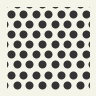

In [60]:
def plot_config(pos, figsize=(1.5,1.5), color='#333333'):
    N, D = pos.shape    
    fig, ax = plt.subplots(figsize=figsize)
    ax.plot(pos[:,0], pos[:,1], color=color, marker='o', markersize=8, markeredgewidth=0.0, linestyle='None')
    ax.set_facecolor('#f5f4e9')
    fig.patch.set_facecolor('#f5f4e9')
    ax.axis('off')
    # want about 64 points
    #q = max(0.05, min(0.5, 64 / N))
    #xlim = np.quantile(pos[:,0], [0.5 - q, 0.5 + q])
    #ylim = np.quantile(pos[:,1], [0.5 - q, 0.5 + q])    
    xlim = (-3,3)
    ylim = (-3,3)
    ax.set_aspect('equal') 
    ax.set_xlim(*xlim)
    ax.set_ylim(*ylim)
    plt.tight_layout()
    return skunk.pltsvg(fig=fig)
skunk.display(plot_config(trajs['pg-w0-n16'][0]))

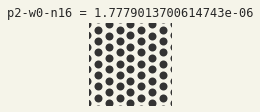

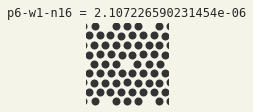

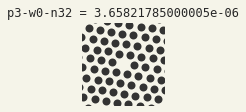

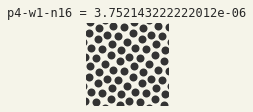

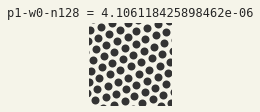

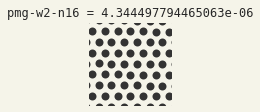

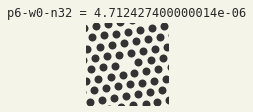

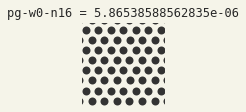

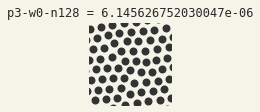

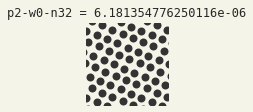

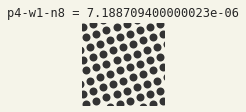

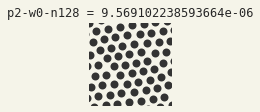

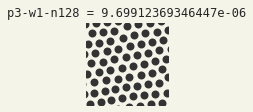

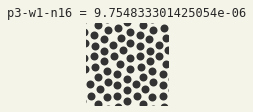

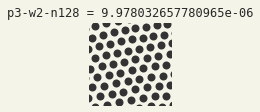

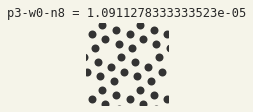

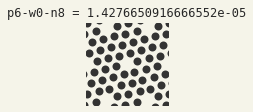

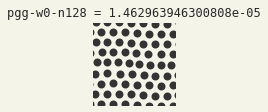

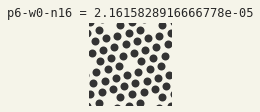

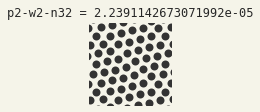

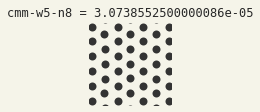

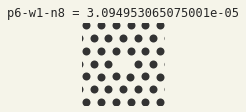

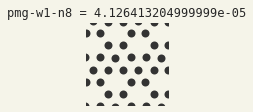

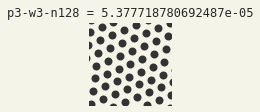

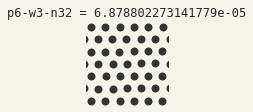

In [61]:
top = cdf[cdf.Time == cdf.Time.max()].sort_values(by=['RMSD'])[:25]
for r,t in zip(top.RMSD.values, top.Traj.values):
    plot_config(trajs[t][0])
    plt.title(f'{t} = {r}')

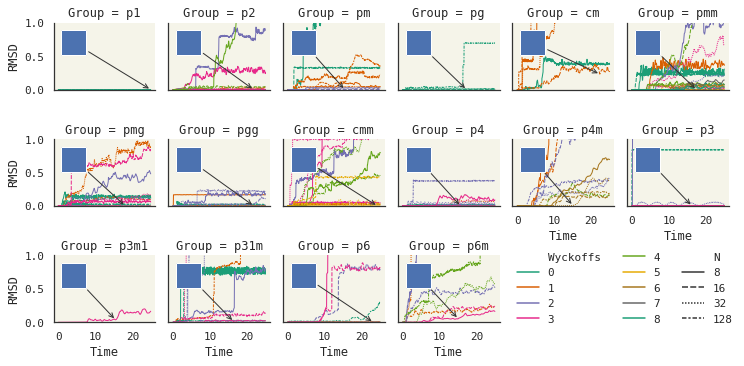

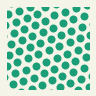

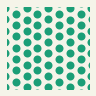

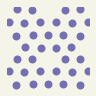

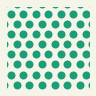

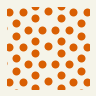

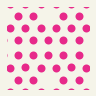

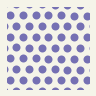

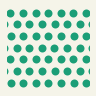

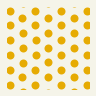

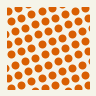

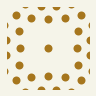

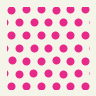

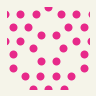

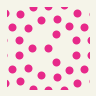

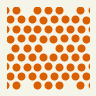

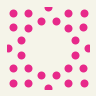

In [62]:
replaces = []
def annotate_config(rmsd, traj, time, wyckoffs, color):
    late_rmsd = rmsd.where(time > 15)
    idx = late_rmsd.argmin()
    label = traj.iloc[idx]
    w = wyckoffs.iloc[idx]
    replaces.append((label, f'C{w}'))
    x = time.iloc[idx]
    y = rmsd.iloc[idx]
    ax = plt.gca()
    box = skunk.Box(25, 25, label)    
    ab = mpl.offsetbox.AnnotationBbox(box, (x, y),
                        pad=0,
                        bboxprops=dict(edgecolor='#333', linewidth=1),
                        xybox=(0.2, 0.7),
                        xycoords='data',
                        boxcoords='axes fraction',
                        arrowprops=dict(arrowstyle="->",color='#333'))

    ax.add_artist(ab)

g = sns.relplot(data=cdf.query('rho > 0.5'), x='Time', y='RMSD', 
        kind='line', hue='Wyckoffs', col='Group', col_wrap=6,
        aspect=1, linewidth=1, style='N', height=1.75, palette='Dark2',
               hue_order=[str(i) for i in range(9)])
plt.ylim(0,1)
sns.move_legend(g, "lower right", bbox_to_anchor=(0.9,0.1), ncol=3)
g.map(annotate_config, 'RMSD', 'Traj', 'Time', 'Wyckoffs').set_axis_labels("Time", "RMSD")


main_svg = skunk.pltsvg()
svg = skunk.insert({l: plot_config(trajs[l][0], color=c) for l,c in replaces}, svg=main_svg)
skunk.display(svg)
with open('atlas.svg', 'w') as f:
    f.write(svg)

## Movie

In [63]:
# make a movie
import moviepy.editor as editor
from moviepy.video.io.bindings import mplfig_to_npimage


def plot_traj(traj, title='@_172135352171_', color='#333333', fps=60):
    T, N, D = traj.shape    
    fps = fps
    duration = T / fps
    dpi = 90
    fig, ax = plt.subplots(figsize=(1200 / dpi, 800 / dpi), dpi=dpi)    
    points = ax.plot(traj[0,:,0], traj[0,:,1], color=color, marker='o', markeredgewidth=0.0, linestyle='None', alpha=1.0)[0]
    ax.set_facecolor('#f5f4e9')
    fig.patch.set_facecolor('#f5f4e9')
    title = ax.set_title(title, fontsize=32, color='#333333',fontname='monospace')
    ax.axis('off')
    xlim = np.quantile(traj[:,:,0], [0.3, 0.8])
    ylim = np.quantile(traj[:,:,1], [0.3, 0.8])
    ax.set_aspect('equal')    
    ax.set_xlim(*xlim)
    ax.set_ylim(*ylim)
    #plt.tight_layout()
    def make_frame(t):
        i = int(t  * fps)
        i = min(i, T-1)
        points.set_data(traj[i,:,0], traj[i,:,1])    
        return mplfig_to_npimage(fig)

    return editor.VideoClip(make_frame, duration=duration)
def write_video(clips, output, fps=60, transition=0.25):
    composite = editor.concatenate(clips[:1] + [c.crossfadein(transition) for c in clips[1:]], 
                                   padding=-transition, method='compose')   
    composite.write_videofile(output, fps=fps, preset='slower', ffmpeg_params=['-tune', 'animation'])

Moviepy - Building video p3.mp4.
Moviepy - Writing video p3.mp4



Moviepy - Done !
Moviepy - video ready p3.mp4


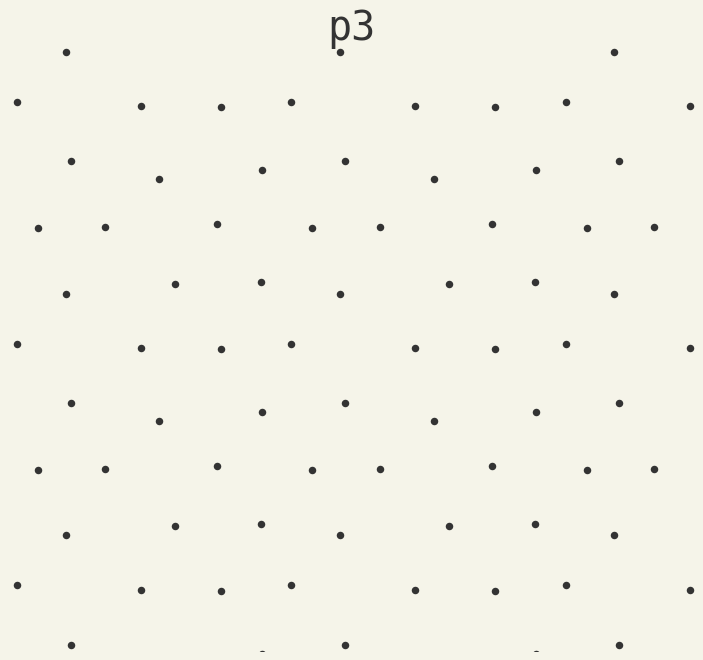

In [21]:
c = plot_traj(traj, title='p3')
write_video([c], f'p3.mp4')

Moviepy - Building video top.mp4.
Moviepy - Writing video top.mp4



Moviepy - Done !
Moviepy - video ready top.mp4


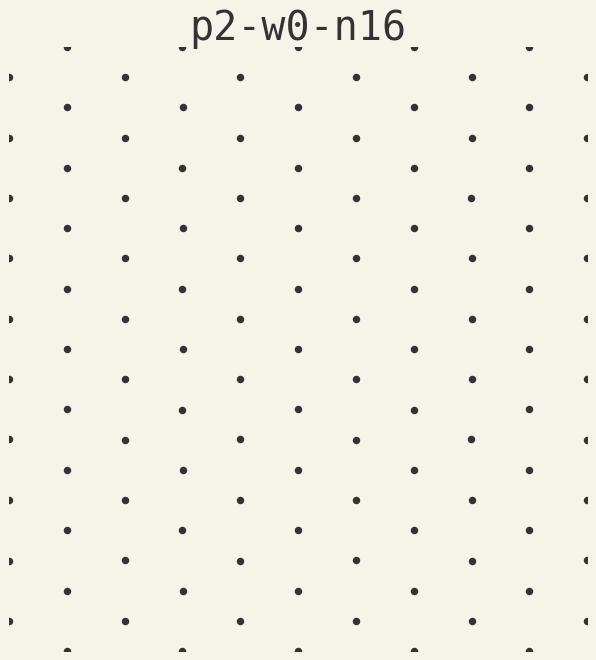

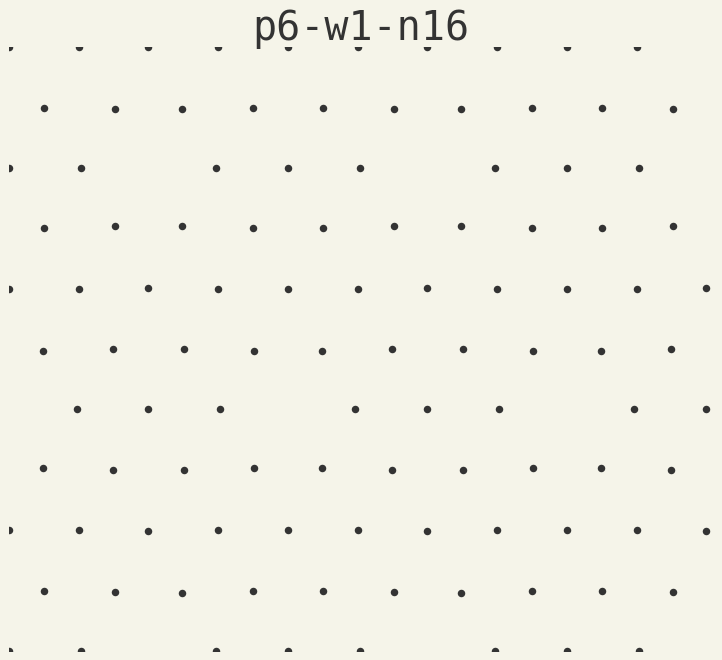

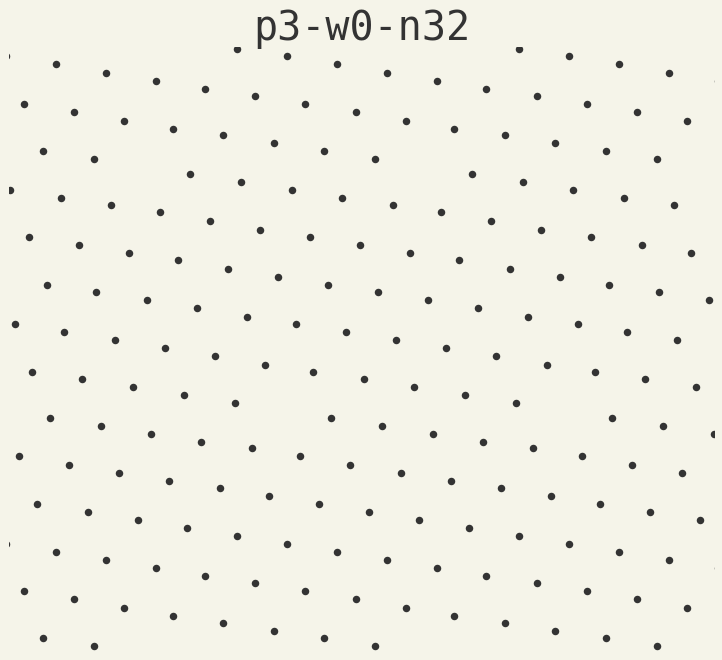

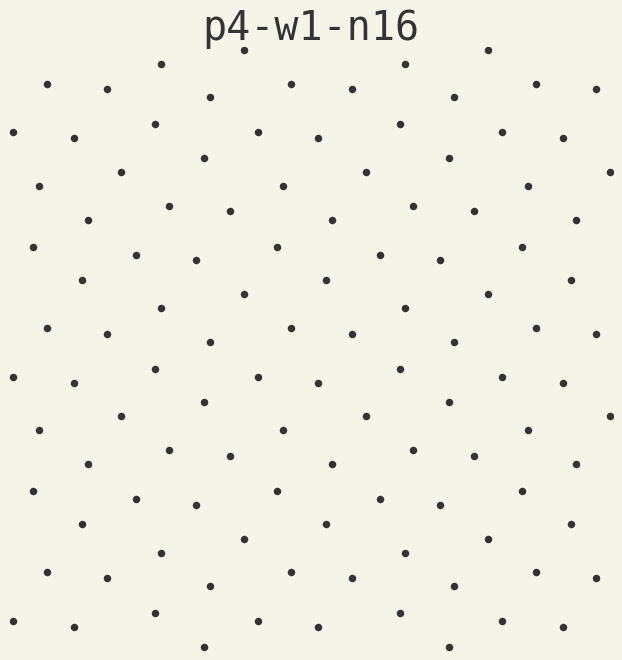

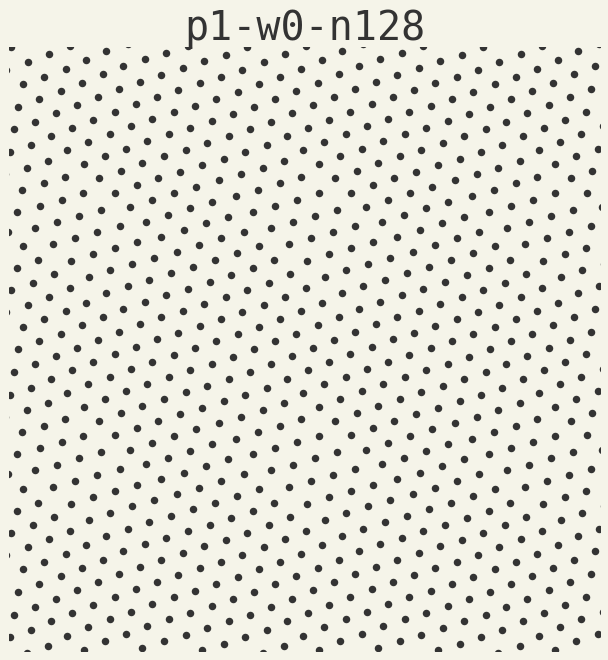

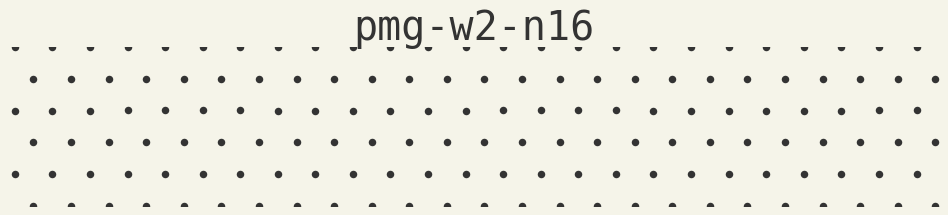

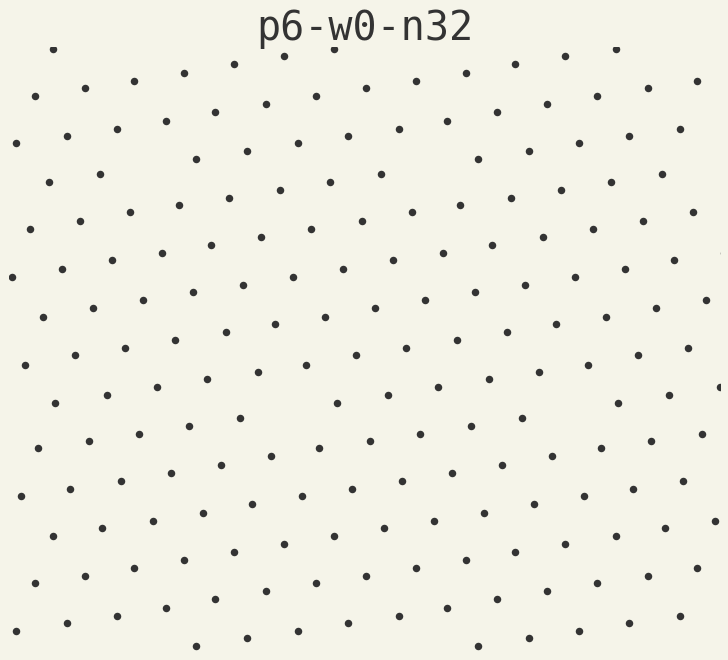

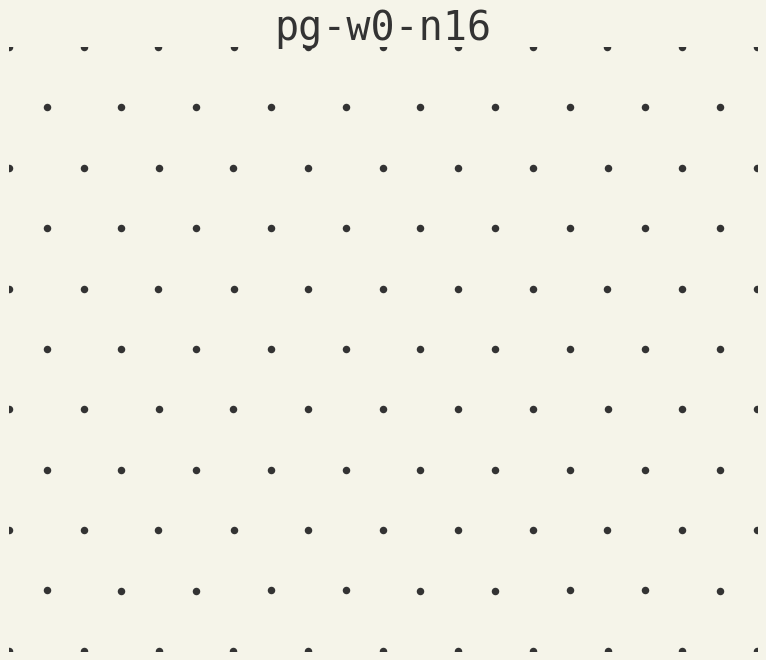

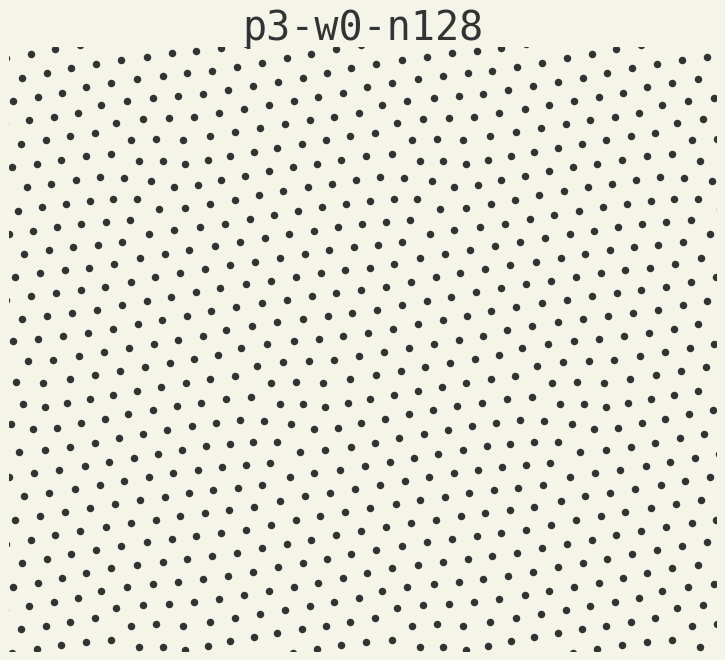

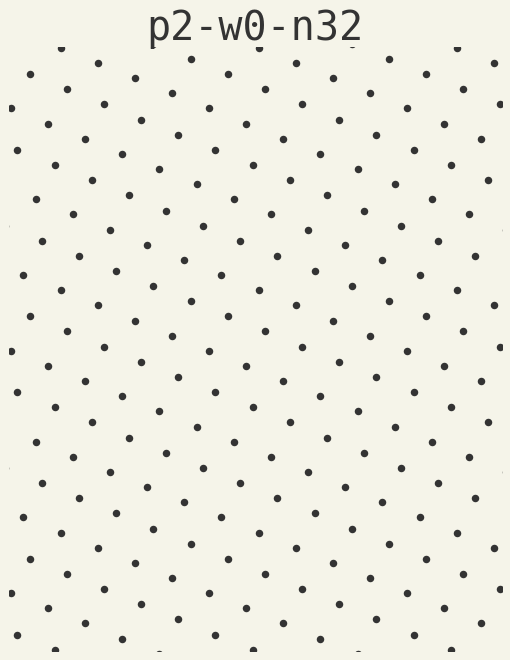

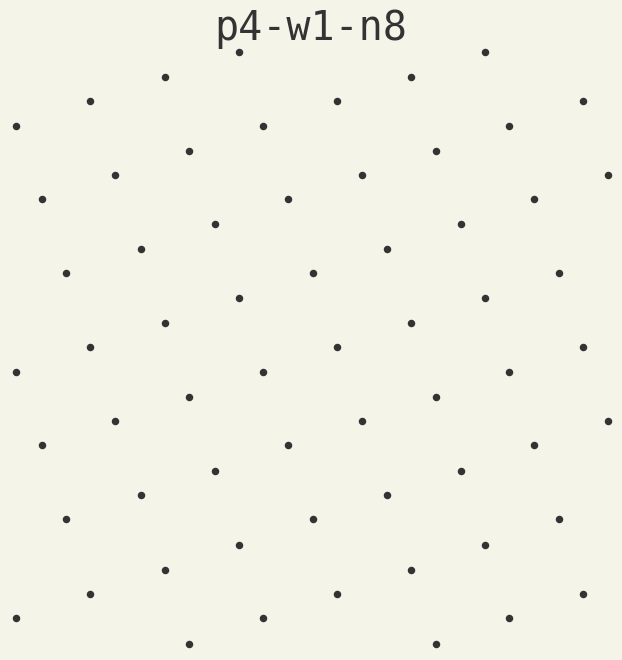

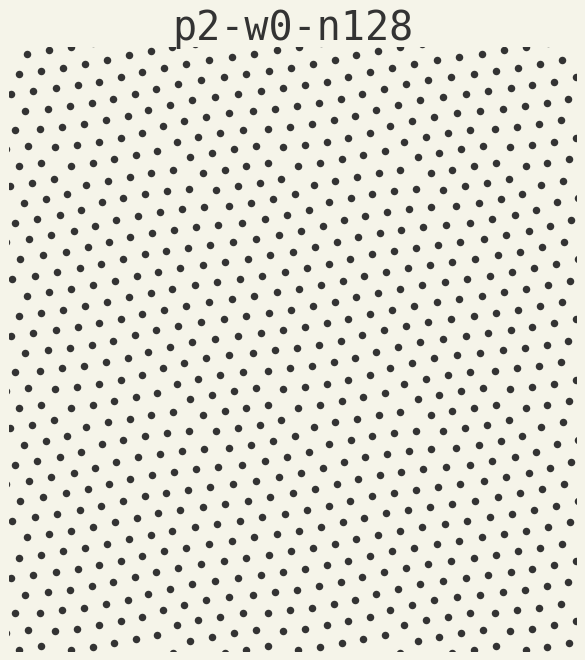

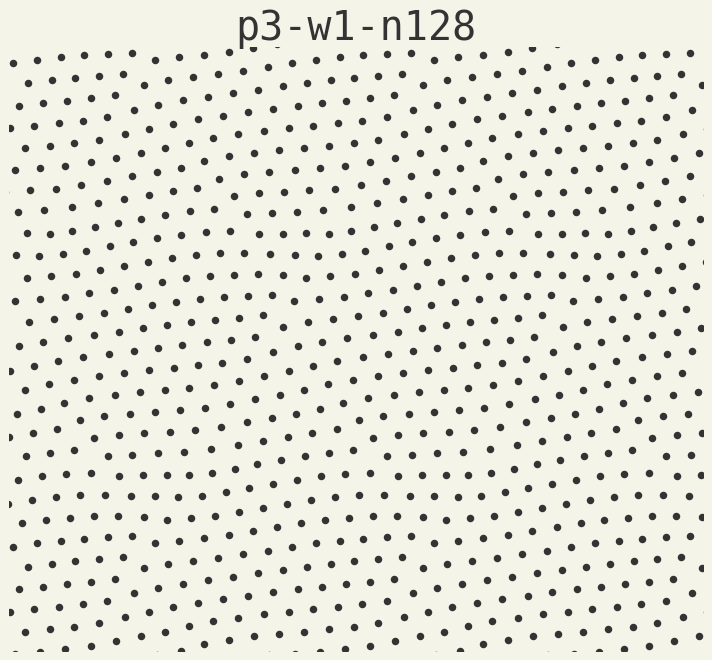

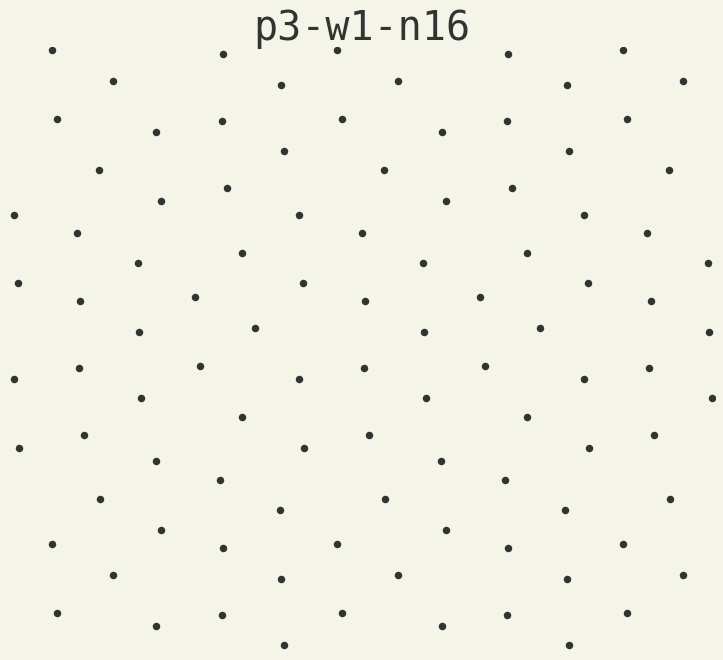

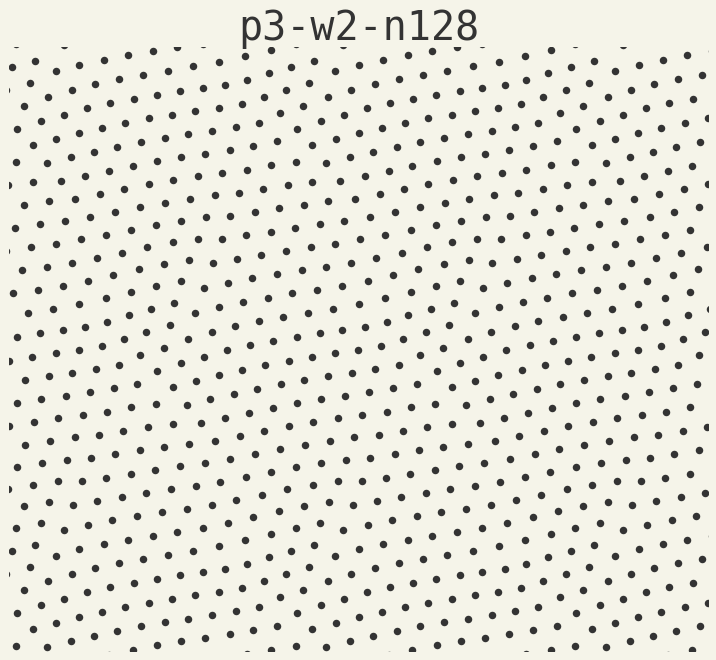

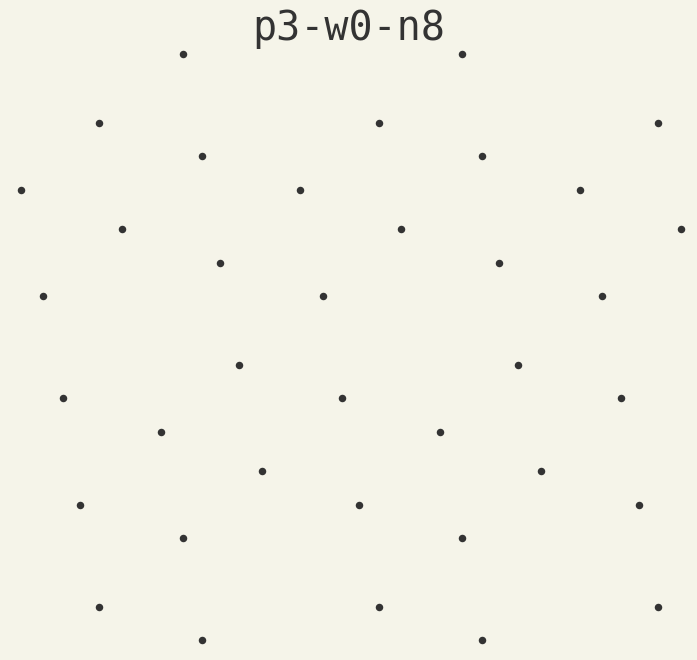

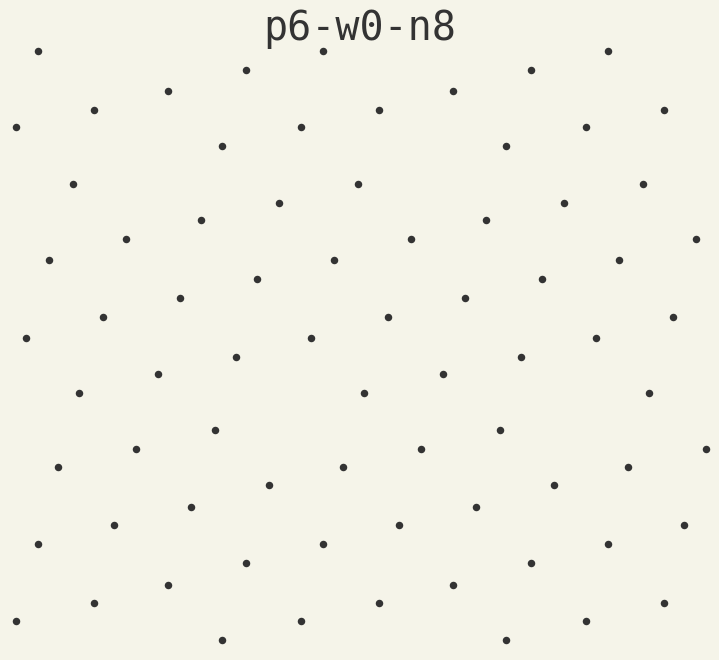

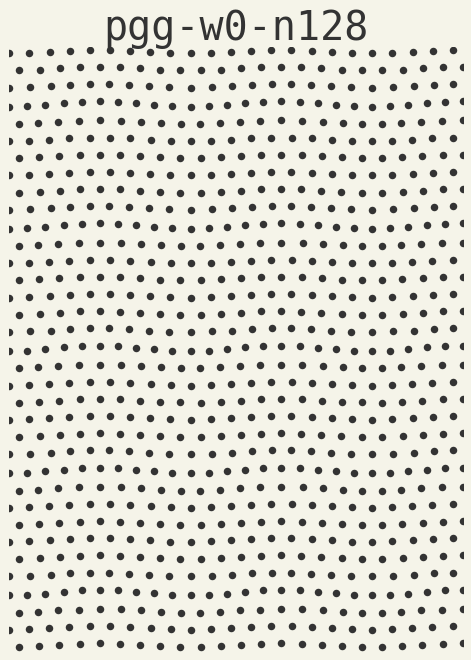

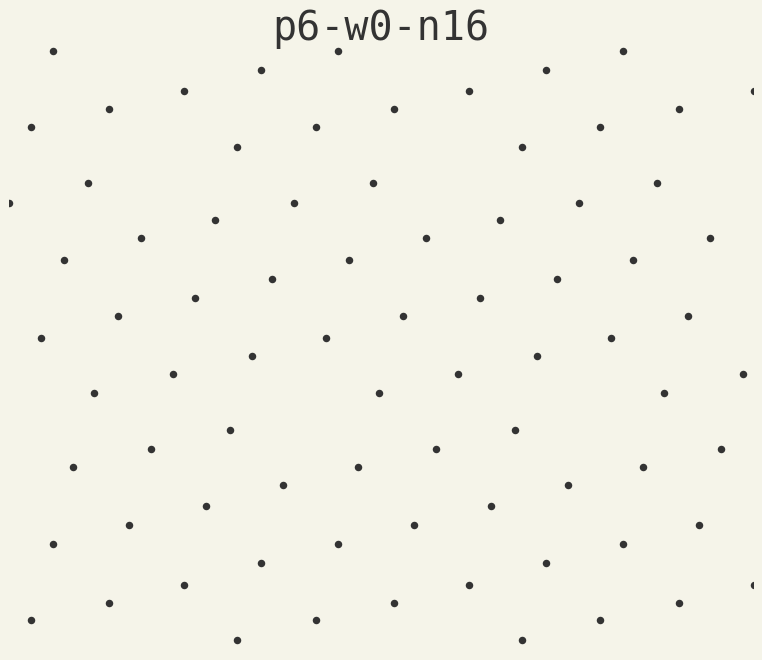

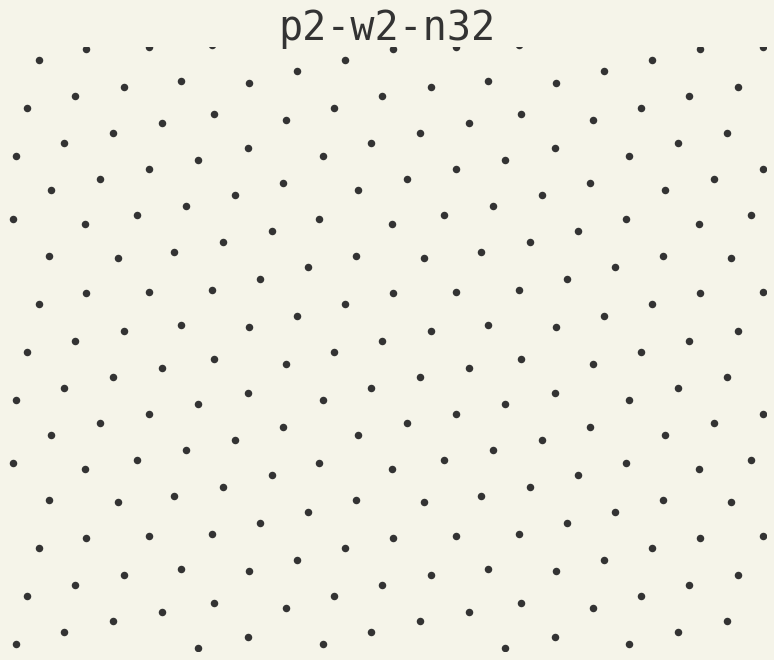

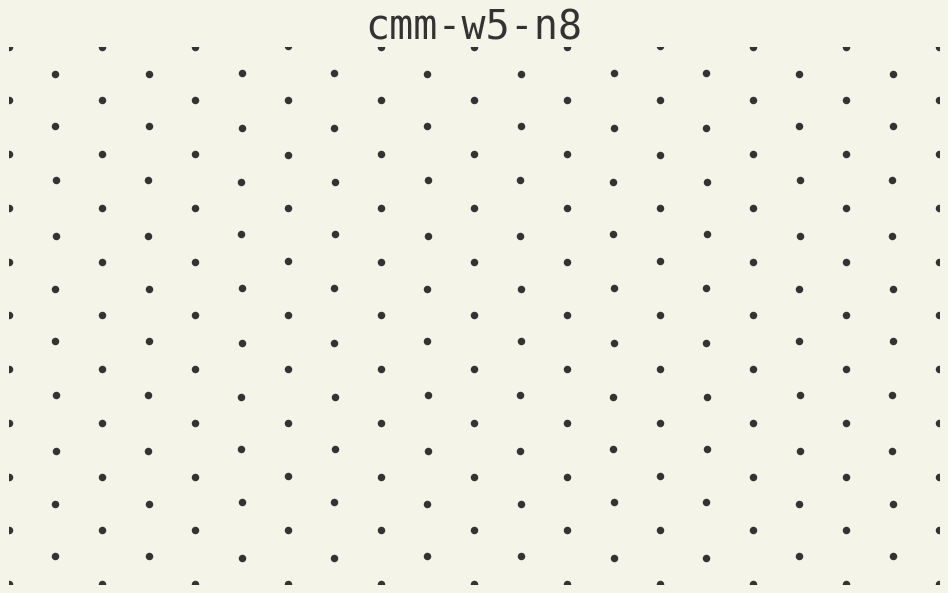

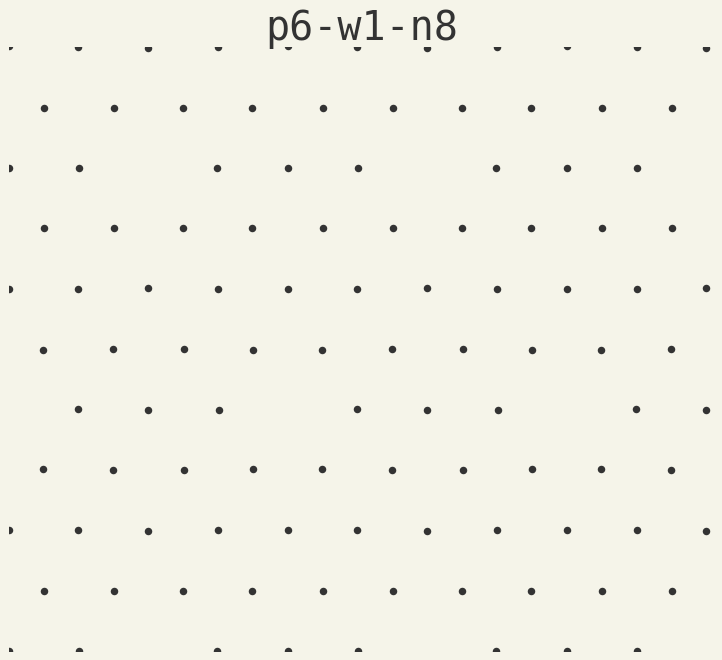

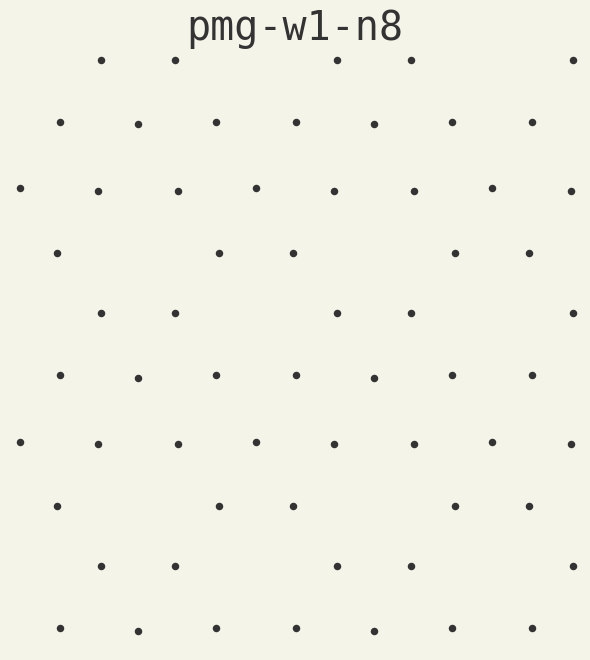

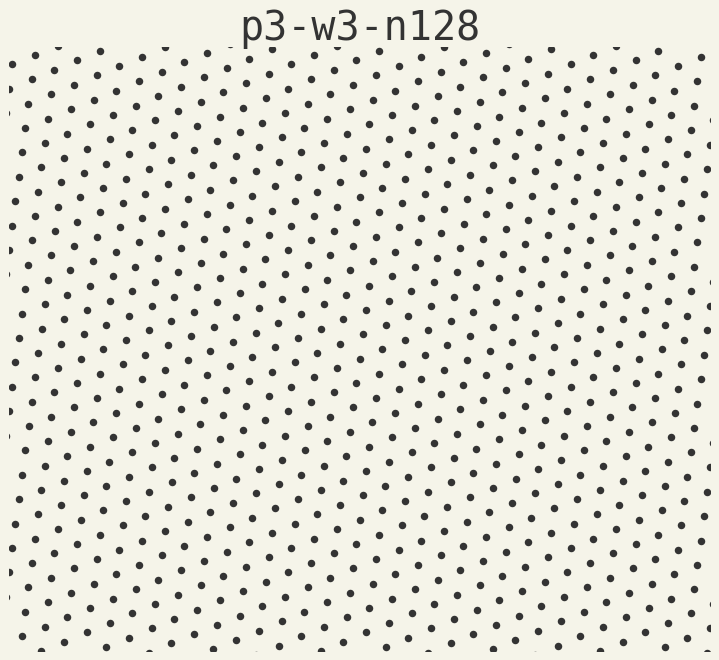

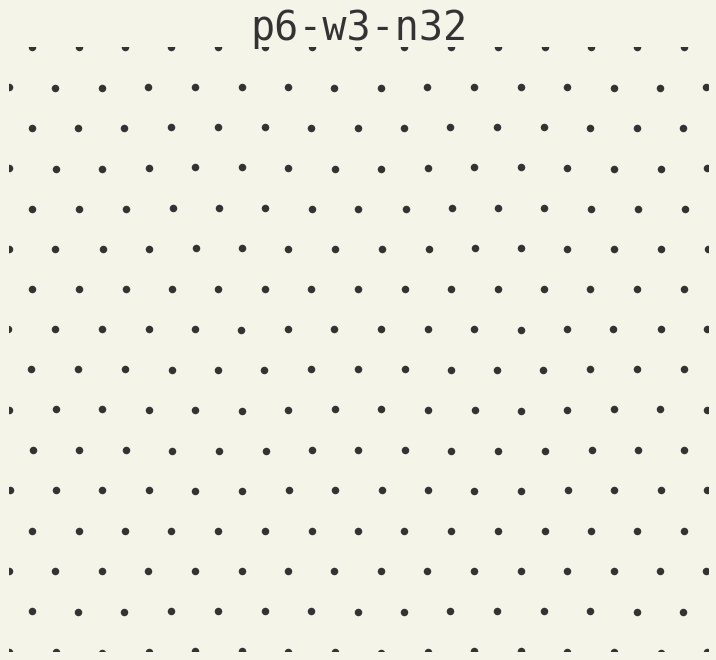

In [64]:
k = 25
top = cdf[cdf.Time == cdf.Time.max()].sort_values(by=['RMSD']).Traj.values[:k]

clips = []
for t in top:
    c = plot_traj(trajs[t][:60 * 3], title=t)
    clips.append(c)
write_video(clips, 'top.mp4')